In [1]:
# Libraries to import
import numpy as np
import pandas as pd
import requests
import time
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from scipy import stats

### Check for Alpha Vantage API requests functions and limitations
### Put your Alpha Vantage API Key here:
APIKEY = ''

In [2]:
#########1#########2#########3#########4#########5#########6#########7#########8
###                    FIRST PART: VARIABLES DECLARATION                    ###8
#########1#########2#########3#########4#########5#########6#########7#########8

In [3]:
## Variables declaration

columns_to_drop = ['open', 'high', 'low']

globalpar = {
    ## 1 minute steps
    'test1' : { 
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '1min',
            'minutes' : 1,
            'sma_range' : 30, ## A half hour   
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 9600,
            'sequence_size' : 30,
            'batch_size' : 64,
            'input_size' : 4,
            'weight_decay' : 0.
        },
        'training' : {
            'sequence_size' : 30,
            'batch_size' : 64,
            'model_input_size' : 4,
            'model_lstm_layers' : 3,
            'model_lstm_size' : 128,
            'model_dropout' : 0.3,
            'model_output' : 1,
            'epochs' : 300,
            'optimizer' : 'Adam', 
            'lrs': [0.005,0.001],
            'lr_change': True,
            'epochs_change' : 200,
            'weight_decay' : 0.
        },
    },
    ## 5 minutes steps
    'test5' : {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '5min',
            'minutes' : 5,
            'sma_range' : 24, ## Three hours  
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 9600,
            'sequence_size' : 24,
            'batch_size' : 64,
            'input_size' : 4,
            'weight_decay' : 0.
        },
        'training' : {
            'sequence_size' : 24,
            'batch_size' : 64,
            'model_input_size' : 4,
            'model_lstm_layers' : 3,
            'model_lstm_size' : 128,
            'model_dropout' : 0.3,
            'model_output' : 1,
            'epochs' : 300,
            'optimizer' : 'Adam',
            'lrs': [0.005,0.001],
            'lr_change': True,
            'epochs_change' : 220,
            'weight_decay' : 0.
        },
    },
    ## 30 minutes steps
    'test30' : {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '30min',
            'minutes' : 30,
            'sma_range' : 32, ## A day  
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 4800,
            'sequence_size' : 32,
            'batch_size' : 64,
            'input_size' : 4,
            'weight_decay' : 0.
        },
        'training' : {
            'sequence_size' : 32,
            'batch_size' : 64,
            'model_input_size' : 4,
            'model_lstm_layers' : 3,
            'model_lstm_size' : 128,
            'model_dropout' : 0.3,
            'model_output' : 1,
            'epochs' : 300,
            'optimizer' : 'Adam',
            'lrs': [0.001,0.0005],
            'lr_change': True,
            'epochs_change' : 220,
            'weight_decay' : 0.
        },
    },
    # Final parameters
    'test_f' : {
        'data' : {
            'ticker' : 'AAPL',
            'interval' : '1min',
            'minutes' : 1,
            'sma_range' : 30, ## A half hour
        },
        'structure' : {
            'training_size' : 0.8,
            'test_size' : 0.2,
            'total_size' : 38400,
            'sequence_size' : 30,
            'batch_size' : 64,
            'input_size' : 4,
            'weight_decay' : 0.
        },
        'training' : {
            'sequence_size' : 30,
            'batch_size' : 64,
            'model_input_size' : 4,
            'model_lstm_layers' : 3,
            'model_lstm_size' : 128,
            'model_dropout' : 0.25,
            'model_output' : 1,
            'epochs' : 600,
            'optimizer' : 'Adam', 
            'lrs': [0.001, 0.0001, 0.00001],
            'lr_change': True,
            'epochs_change' : 450,
            'weight_decay' : 0.
        },
    },
    
}

In [4]:
#########1#########2#########3#########4#########5#########6#########7#########8
###                SECOND PART: GATHERING & CLEANING THE DATA               ###8
#########1#########2#########3#########4#########5#########6#########7#########8

In [5]:
# Lets'collect and clean the data from Apple in the last two years daily
# from Alpha Advantage API we have this function request.

def get_Intraday24m(param, period, adjusted='True', apikey=APIKEY):
    '''
    This function returns historical intraday time series for the trailing 2
    years, covering over 2 million data points per ticker. The intraday data is
    computed directly from the Securities Information Processor (SIP) market-
    aggregated data feed. You can query both raw (as-traded) and split/dividend-
    adjusted intraday data from this endpoint. Common use cases for this API
    include data visualization, trading simulation/backtesting, and machine
    learning and deep learning applications with a longer horizon.

    Function Parameters:

    * Required: param: a Dictionary with at least the next items:
    
            ** ticker: The name of the equity of your choice. Example: 'IBM'
            ** interval: '1min', '5min', '15min', '30min', '60min'

    * Required: period: 'year1month1',...,'year1month12',
                       'year2month1',...,'year2month12'

    * Optional: adjusted: True or False

    * Required: apikey

    Returns:
        A Dataframe with the next columns: time, open, high, low, close, volume
    '''
    # AV (Alpha Vantage) API function declaration
    function = 'TIME_SERIES_INTRADAY_EXTENDED'
    # Creating the URL request
    url = 'https://www.alphavantage.co/query?function='+function+            \
                                            '&symbol='+param['ticker']+      \
                                            '&interval='+param['interval']+  \
                                            '&slice='+period+                \
                                            '&adjusted='+adjusted+           \
                                            '&apikey='+apikey
    # Sending back the request call and results
    return pd.read_csv(url, index_col='time').dropna()

In [6]:
# Now let's declare the function responsible for collect the minute prices data 
# from Alpha Advantage for the last 24 months

def collecting_all_data(param, apikey=APIKEY):
    '''
    This function use the function get_Intraday24m() that calls for an Alpha
    Vantage API instruction to collect all the data for a specific period=month.
    The data is for a specific interval of time and for a specific ticker.
    It will collect the adjusted prices.
  
    Function Parameters:

    * Required: param: a Dictionary with at least the next items:
    
            ** ticker: The name of the equity of your choice. Example: 'IBM'
            ** interval: '1min', '5min', '15min', '30min', '60min'

    * Required: apikey

    Returns:
        A Dataframe with the next columns: time, open, high, low, close, volume
                                           for the last 24 months.
    '''
    
    # Requesting the first period to initialize the dataframe
    period = 'year1month1'
    raw_data = get_Intraday24m(param, period, apikey = APIKEY)

    # A list of tuples to create all the periods to be requested
    periods = [(str(year), str(month)) for year in range(1,3) 
                                       for month in range(1,13)]
    # A loop to request every period except the first one already requested
    for (year, month) in periods[1:]:
        period = 'year' + year + 'month' + month
        # API request and concatenation with the past results
        raw_data = pd.concat([raw_data, get_Intraday24m(param, period)])
        # A delay to guarantee 5 request per minute maximum
        time.sleep(13)
    # Returning the collected data
    return raw_data.sort_values(by='time')
        

In [7]:
# Let's make a first attempt
apple_raw_1min = collecting_all_data(globalpar['test1']['data'])
apple_raw_1min

open        high         low       close  volume
time                                                                       
2020-05-20 04:01:00   77.780648   77.783117   77.780648   77.780648    3240
2020-05-20 04:03:00   77.788055   77.788055   77.788055   77.788055    1112
2020-05-20 04:14:00   77.894225   77.894225   77.894225   77.894225    2300
2020-05-20 04:15:00   77.923854   77.923854   77.923854   77.923854    4892
2020-05-20 04:16:00   77.923854   77.923854   77.923854   77.923854    7424
...                         ...         ...         ...         ...     ...
2022-05-09 19:56:00  152.320000  152.500000  152.320000  152.420000    8116
2022-05-09 19:57:00  152.490000  152.520000  152.490000  152.520000    1353
2022-05-09 19:58:00  152.600000  152.750000  152.600000  152.750000   11469
2022-05-09 19:59:00  152.690000  152.690000  152.600000  152.620000    2070
2022-05-09 20:00:00  152.620000  152.750000  152.580100  152.750000   10150

[407818 rows x 5 columns]

In [8]:
# And let's see more info about it
apple_raw_1min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407818 entries, 2020-05-20 04:01:00 to 2022-05-09 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    407818 non-null  float64
 1   high    407818 non-null  float64
 2   low     407818 non-null  float64
 3   close   407818 non-null  float64
 4   volume  407818 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 18.7+ MB


In [9]:
# Let's repeat the process for 5 minutes and 30 minutes data and use
# the next function to save all raw data to save time in the future.
apple_raw_5min = collecting_all_data(globalpar['test5']['data'])
apple_raw_30min = collecting_all_data(globalpar['test30']['data'])

In [10]:
# Lets save them all for future implementations
def saving_ticker_data(dataset, param):
    '''
    Function prepared to save data with a specific filename.
    
    Function Parameters:
    
    * Required: data: a dataframe with the raw data.
    
    * Required: param: a Dictionary with at least the next items:
    
            ** ticker: the ticker of the represented dataset
            ** interval: '1min', '5min', '15min', '30min', '60min'
    
    '''
    # Let's decalre first the filepath for the future file
    dit = os.getcwd()
    filepath = dit + '/' + param['ticker'] + '_allf_' + param['interval']
    # Finally saving the data as a csv file.
    dataset.to_csv(filepath)

In [11]:
# Let's make a function for future loadings of the raw data
def loading_ticker_data(param):
    '''
    Function prepared to load a dataframe from a specific
    filepath.
    
    Function Parameters:
    
    * Required: param: a Dictionary with at least the next items:
    
            ** ticker: the ticker of the dataset to be read.
            ** interval: '1min', '5min', '15min', '30min', '60min'
            
    Returns:
        A Dataframe with the raw data of the specific ticker and the
        interval specified.
    
    '''
    # Let's declare first the filepath for the file to be read.
    dit = os.getcwd()
    filepath = dit + '/' + param['ticker'] + '_allf_' + param['interval']
    
    # Returning the read file.
    return pd.read_csv(filepath, index_col = 'time')

In [12]:
# Saving the raw data
saving_ticker_data(apple_raw_30min, globalpar['test30']['data'])
saving_ticker_data(apple_raw_5min, globalpar['test5']['data'])
saving_ticker_data(apple_raw_1min, globalpar['test1']['data'])

In [64]:
# Let's load a file 
apple_raw_1min = loading_ticker_data(globalpar['test1']['data'])
apple_raw_5min = loading_ticker_data(globalpar['test5']['data'])
apple_raw_30min = loading_ticker_data(globalpar['test30']['data'])

In [65]:
# Defining the general style
plt.style.use('seaborn-colorblind')

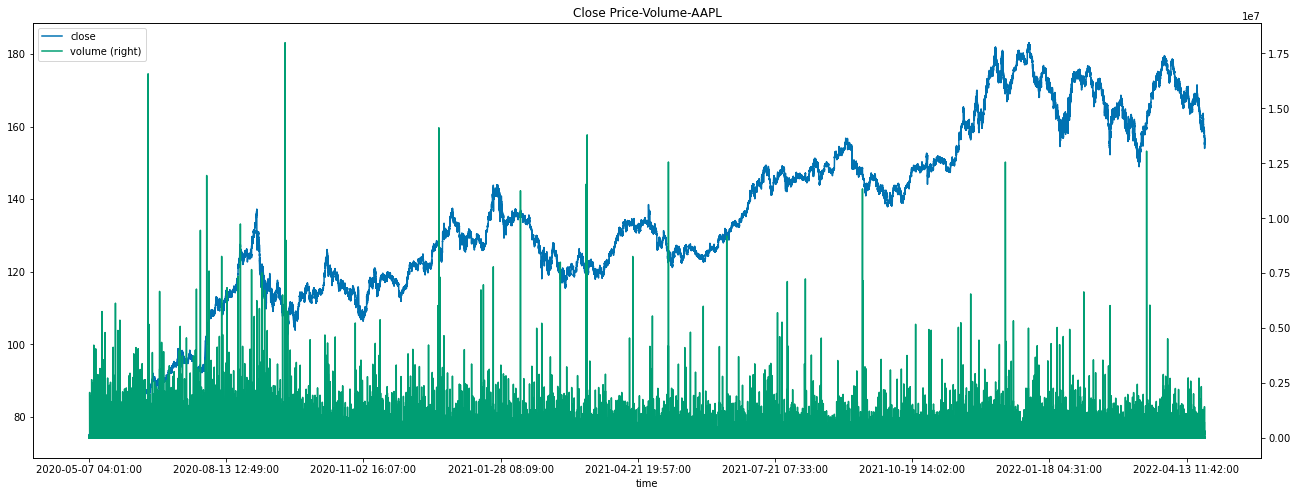

In [67]:
# Some graphing to enjoy the numbers downloaded. Just close price and
# volume for the moment.
apple_raw_1min['close'].plot(figsize=(22,8), title='Close Price-Volume-AAPL', 
                             legend=True)
apple_raw_1min['volume'].plot(figsize=(22,8), secondary_y=True, legend=True)
plt.savefig('original close-volume-AAPL.png', bbox_inches='tight')

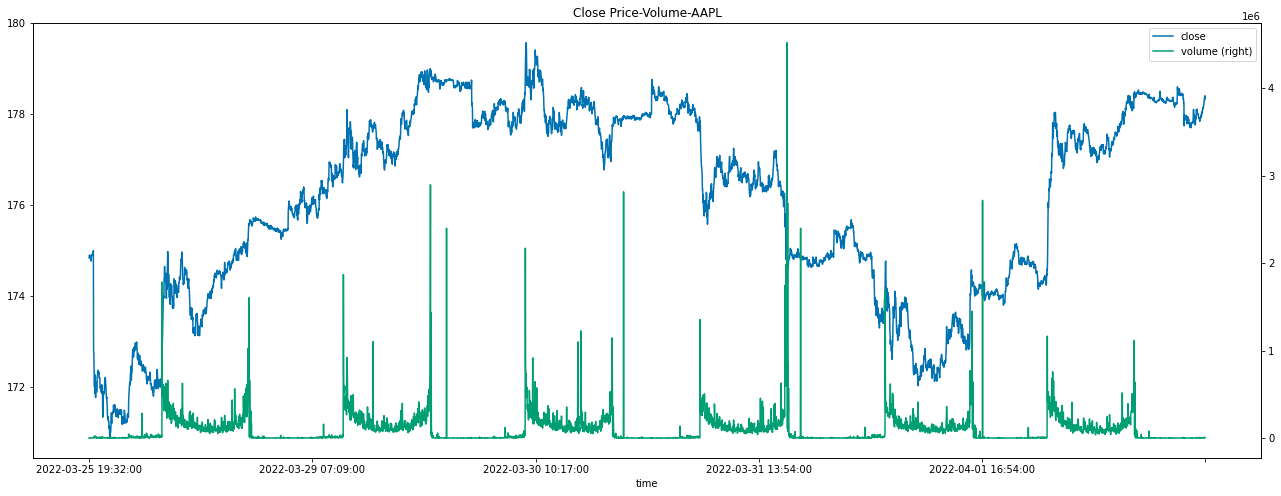

In [69]:
# And a closer look to that graph:
apple_raw_1min[390000:395000]['close'].plot(figsize=(22,8), legend=True,
                                           title='Close Price-Volume-AAPL')
apple_raw_1min[390000:395000]['volume'].plot(figsize=(22,8), secondary_y=True,
                                            legend=True)
plt.savefig('zoom1 close-volume-AAPL.png', bbox_inches='tight')

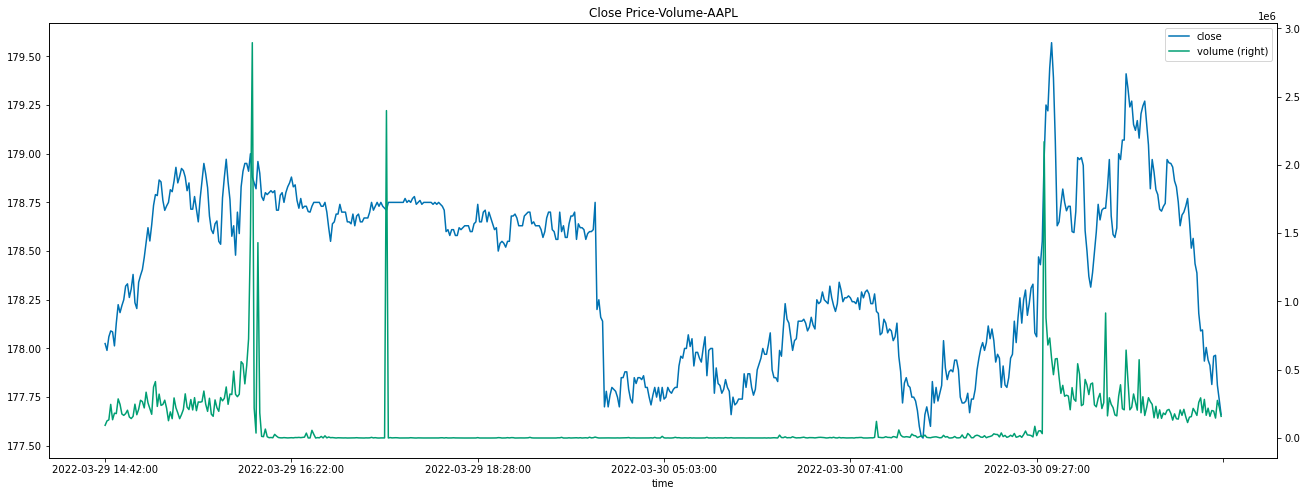

In [70]:
# Closer
apple_raw_1min[391450:392050]['close'].plot(figsize=(22,8), legend=True,
                                           title='Close Price-Volume-AAPL')
apple_raw_1min[391450:392050]['volume'].plot(figsize=(22,8), secondary_y=True,
                                            legend=True)
plt.savefig('zoom2 close-volume-AAPL.png', bbox_inches='tight')

We need a continuous data. In many stock data like this we have some 
periods where there is no trading at all, meaning no volume and the same stock 
price.

For filling the empty spaces of time where the stock wasn't traded,
we first create a market data column with the values of -1,0 or 1 
depending on the trading hours: pre-market, market or post-market hours.
That will create NaN values in the originally empty data periods
that we will later fill with te previous values.

In [71]:
# Let's crate the 'market' column
def filling_blank_periods_and_adding_market(data, param):
    '''
    This function creates first the new column 'market' data.
    It apply a -1 value for pre-market periods, 0 for market periods and
    1 for post-market periods.
    First creates a complete range of time for all the dates involved.
    Later determine the market data and finally concat the resulting
    database that will fill the empty rows in the original data with NaN
    values.
    
    Function Parameters:
    
    * Required: data: a dataframe with the original stock data.

    * Required: param: a Dictionary with at least the next items:
    
            ** minutes: number of minutes per period in the data
            ** interval: '1min', '5min', '15min', '30min', '60min'

    Returns:
        A Dataframe with the 'market' column added, with the full
        row periods for the entire range of dates.
    
    '''
    # This cut variable defines the number of values at the first hour
    # upon the interval selected.
    cut = {
        '1min' : -59,
        '5min' : -11,
        '30min' : -1,
        '60min' : None
    }
    
    # the complete range of dates
    dates = pd.DataFrame(set(data.index.map(lambda x: x.split(' ')[0])), 
                         columns=['date']).sort_values(by='date')
    # the complete range of interval periods during a day
    timing = [str(hour).zfill(2) + ':' + str(minutes).zfill(2) \
                               for hour in range(4,21,1) \
                               for minutes in range(0, 60, 
                                                    param['minutes'])]\
                                                    [1:cut[param['interval']]]
    # the market values related to each interval period
    market_time = [-.1 if time<'09:30' else .1 if time>'16:00' \
                                      else 0 for time in timing]
    # The dataframe for the market values
    data_market = pd.DataFrame(market_time * len(dates), 
                               index=[date + ' ' + time + ':00' \
                                      for date in dates.date    \
                                      for time in timing], columns=['market'])
    # The final dataframe merging the original data wiht the market data
    full_data = data_market.merge(data.copy(), how = 'left', left_index = True,
                                                  right_index = True)
    return full_data

In [72]:
# Let's test this function
apple_raw_1min = filling_blank_periods_and_adding_market(apple_raw_1min, 
                                        globalpar['test1']['data'])
apple_raw_1min

market        open        high         low       close  \
2020-05-07 04:01:00    -0.1   74.761645   74.761645   74.749314   74.749314   
2020-05-07 04:02:00    -0.1   74.741916   74.761645   74.741916   74.761645   
2020-05-07 04:03:00    -0.1         NaN         NaN         NaN         NaN   
2020-05-07 04:04:00    -0.1         NaN         NaN         NaN         NaN   
2020-05-07 04:05:00    -0.1   74.761645   74.761645   74.761645   74.761645   
...                     ...         ...         ...         ...         ...   
2022-04-26 19:56:00     0.1  156.120000  156.150000  156.120000  156.140000   
2022-04-26 19:57:00     0.1  156.120000  156.150000  156.120000  156.150000   
2022-04-26 19:58:00     0.1  156.140000  156.150000  156.100000  156.100000   
2022-04-26 19:59:00     0.1  156.140000  156.150100  156.140000  156.150100   
2022-04-26 20:00:00     0.1  156.200000  156.200000  156.120000  156.120000   

                     volume  
2020-05-07 04:01:00  3492.0  
2020-05-07 04:02:00  1616.0  
2020-05-07 04:03:00     NaN  
2020-05-07 04:04:00     NaN  
2020-05-07 04:05:00  5756.0  
...                     ...  
2022-04-26 19:56:00  1576.0  
2022-04-26 19:57:00  3748.0  
2022-04-26 19:58:00  2490.0  
2022-04-26 19:59:00  2481.0  
2022-04-26 20:00:00  4360.0  

[477120 rows x 6 columns]

In [73]:
apple_raw_1min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 477120 entries, 2020-05-07 04:01:00 to 2022-04-26 20:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   market  477120 non-null  float64
 1   open    406784 non-null  float64
 2   high    406784 non-null  float64
 3   low     406784 non-null  float64
 4   close   406784 non-null  float64
 5   volume  406784 non-null  float64
dtypes: float64(6)
memory usage: 41.6+ MB


Let's plot the previous graph again.

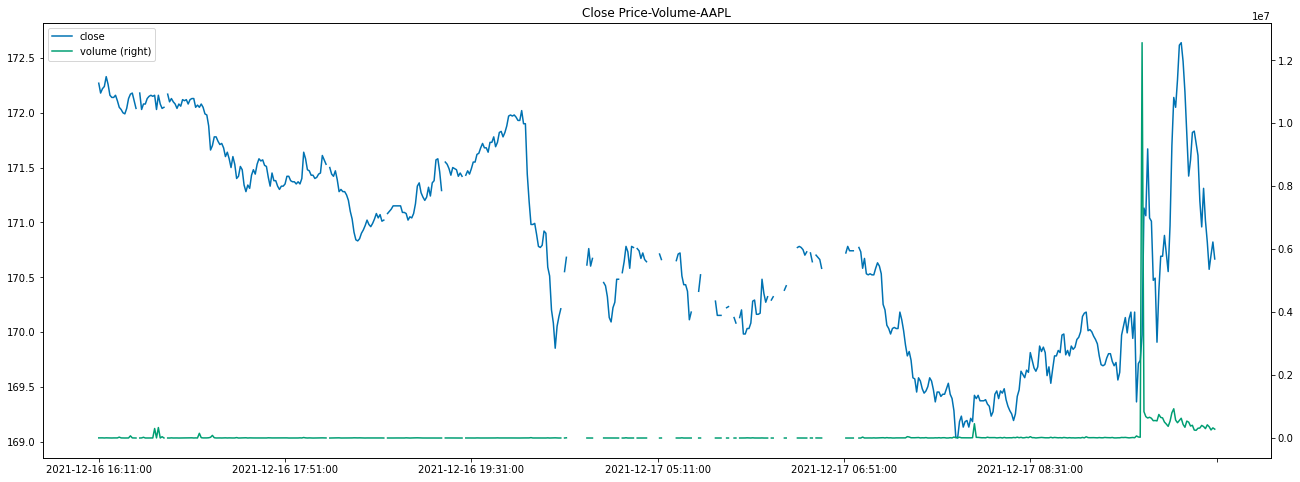

In [74]:
#Previous plot
apple_raw_1min[391450:392050]['close'].plot(figsize=(22,8), legend=True,
                                           title='Close Price-Volume-AAPL')
apple_raw_1min[391450:392050]['volume'].plot(figsize=(22,8), secondary_y=True,
                                            legend=True)
plt.savefig('NaN values close-volume-AAPL.png', bbox_inches='tight')

As you can see there is a lot of NaN values that we will fill with the
next function. With a value of zero for empty volumes spaces, because there were nothing traded
in those moments, and the previous value for close price, because the same price remain.

In [75]:
# Now let's fill the NaN values with the previous values of price
# and 0 for volume data.
def filling_nas(data):
    '''
    This function simply check for the volume or not volume data to
    fill its NaN values with 0 or its last value respectively.

    Function Parameters:
    
    * Required: data: a dataframe with the full periods stock data.

    Returns:
        A Dataframe with the NaN values filled.

    '''
    
    # Just running along the columns to check the proper method to
    # apply in the filling.
    for col in data.columns:
        if col == 'volume':
            data[col] = data[col].fillna(0)
        elif col != 'market':
            data[col] = data[col].fillna(method='ffill')
    return data

In [76]:
# And the next test:
apple_raw_1min = filling_nas(apple_raw_1min)
# Let's drop the columns we will not use in this analysis
apple_pre_1min = apple_raw_1min.drop(columns=columns_to_drop)
apple_pre_1min

market       close  volume
2020-05-07 04:01:00    -0.1   74.749314  3492.0
2020-05-07 04:02:00    -0.1   74.761645  1616.0
2020-05-07 04:03:00    -0.1   74.761645     0.0
2020-05-07 04:04:00    -0.1   74.761645     0.0
2020-05-07 04:05:00    -0.1   74.761645  5756.0
...                     ...         ...     ...
2022-04-26 19:56:00     0.1  156.140000  1576.0
2022-04-26 19:57:00     0.1  156.150000  3748.0
2022-04-26 19:58:00     0.1  156.100000  2490.0
2022-04-26 19:59:00     0.1  156.150100  2481.0
2022-04-26 20:00:00     0.1  156.120000  4360.0

[477120 rows x 3 columns]

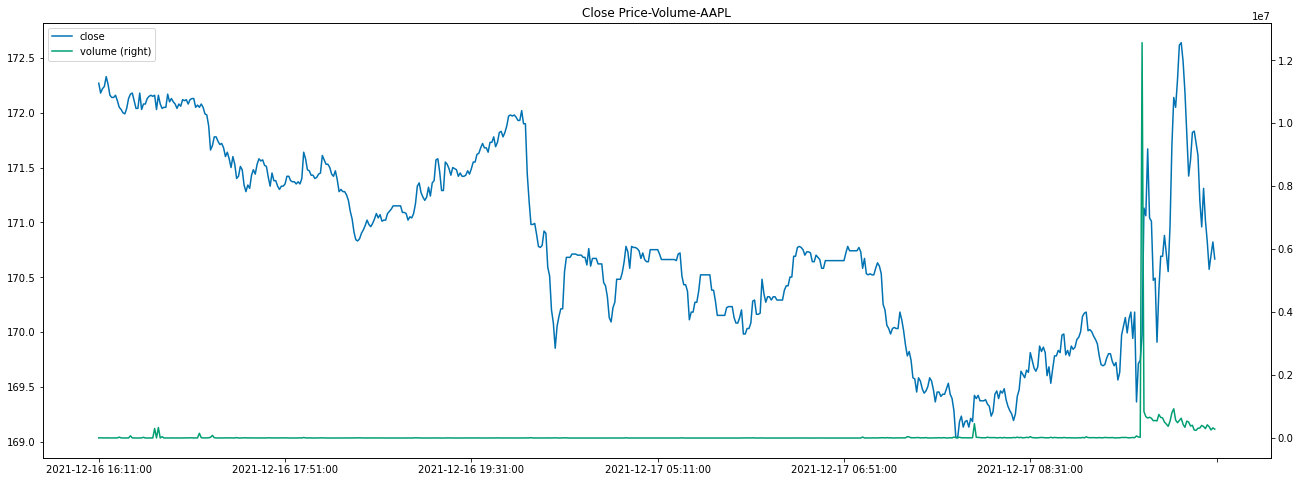

In [77]:
# Let's see it graphically:
apple_raw_1min[391450:392050]['close'].plot(figsize=(22,8), legend=True,
                                           title='Close Price-Volume-AAPL')
apple_raw_1min[391450:392050]['volume'].plot(figsize=(22,8), secondary_y=True,
                                            legend=True)
plt.savefig('NaN filled close-volume-AAPL.png', bbox_inches='tight')

In [78]:
apple_pre_1min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 477120 entries, 2020-05-07 04:01:00 to 2022-04-26 20:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   market  477120 non-null  float64
 1   close   477120 non-null  float64
 2   volume  477120 non-null  float64
dtypes: float64(3)
memory usage: 30.7+ MB


PROBLEM SOLVED!... at the moment.

Now let's add a new value: SMA stated for Simple Moving Average, and more
than that, let's calculate the 'momentum' of that value. The momentum will be
calculated as the logarithm of the return between the sma and the same sma
X steps before. In other words we are calculating the logarithm of the
relation between two values X stpes away. Where X is defined in our
global parameters variable as the 'sma_range'. 

In [79]:
def sma_and_momentum(data, param):
    '''
    This function creates two new columns in the dataframe.
    The SMA or Simple Moving Average, famous signal in the 
    stock market, and the momentum of that SMA for a range of
    X periods of time or rows.
    
    Function Parameters:
    
    * Required: data: a dataframe with the close price data.

    * Required: param: a Dictionary with at least the next items:
    
            ** sma_range: number of rows or periods to calculate
                          the SMA and momentum.
    Returns:
        A Dataframe with the 'sma' and 'momentum' columns added.
    
    '''
    # Let's take the momentum range
    momentum = param['sma_range']
    # Now the SMA for the last 'momentum' rows and the further momentum for
    # the resulting SMA data.
    data['sma'] = data.close.rolling(momentum).mean()
    data['momentum'] = 10 * np.log(data['sma'] / data['sma'].shift(momentum))
    # Let's remove the firts two momentum periods data becuase to garantee no
    # NaN values in the final data.
    data = data.iloc[momentum * 2:]
    
    return data

In [80]:
# The new features:
apple_mom_1min = sma_and_momentum(apple_pre_1min, globalpar['test1']['data'])
apple_mom_1min

market       close  volume         sma  momentum
2020-05-07 05:01:00    -0.1   74.971269     0.0   74.899997  0.015443
2020-05-07 05:02:00    -0.1   74.971269     0.0   74.904600  0.015739
2020-05-07 05:03:00    -0.1   74.971269     0.0   74.909204  0.016035
2020-05-07 05:04:00    -0.1   74.971269     0.0   74.913807  0.016331
2020-05-07 05:05:00    -0.1   74.971269     0.0   74.918411  0.016626
...                     ...         ...     ...         ...       ...
2022-04-26 19:56:00     0.1  156.140000  1576.0  155.986333  0.006498
2022-04-26 19:57:00     0.1  156.150000  3748.0  155.997333  0.006883
2022-04-26 19:58:00     0.1  156.100000  2490.0  156.006667  0.007160
2022-04-26 19:59:00     0.1  156.150100  2481.0  156.014003  0.007352
2022-04-26 20:00:00     0.1  156.120000  4360.0  156.022337  0.007523

[477060 rows x 5 columns]

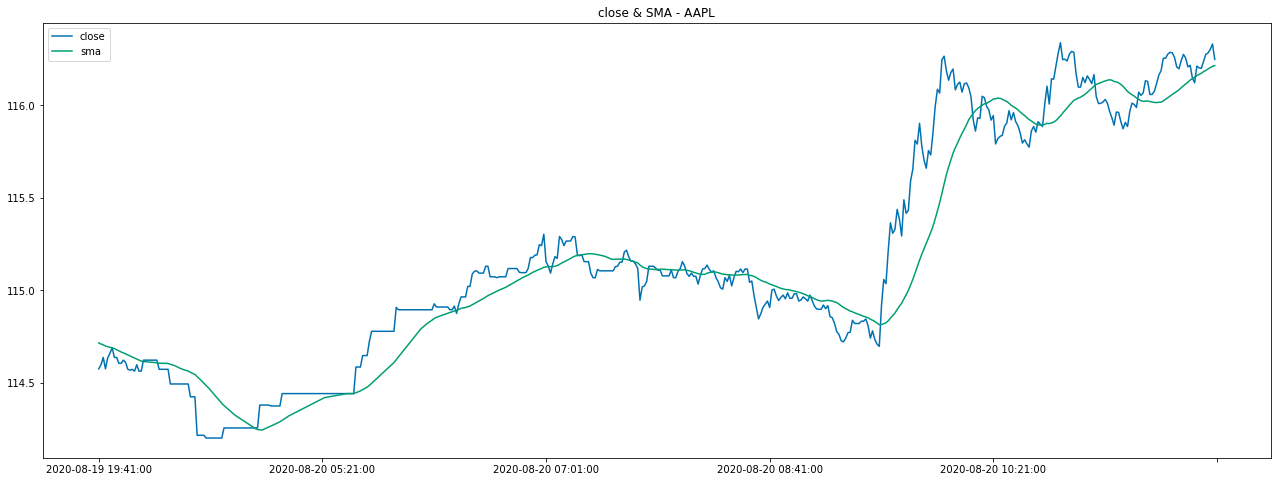

In [81]:
# The graphical representation of the SMA:
apple_mom_1min[['close','sma']][70000:70500].plot(figsize=(22,8),
                                                 title='close & SMA - AAPL')
plt.savefig('SMA close-AAPL.png', bbox_inches='tight')

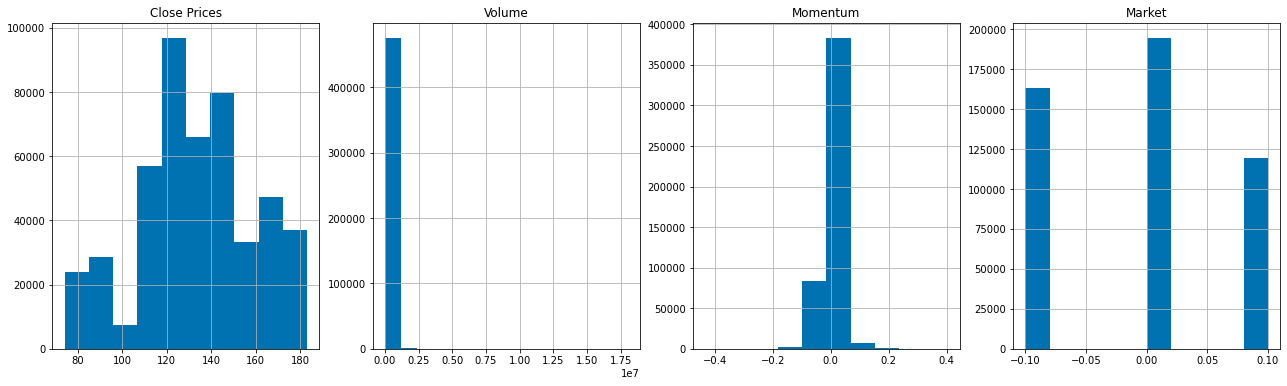

In [82]:
# Let's do some final graphs to visualize better the data we use:
%matplotlib inline
fig, ax = plt.subplots(1, 4, figsize=(22, 6))
apple_mom_1min.close.hist(ax=ax[0])
apple_mom_1min.volume.hist(ax=ax[1], bins=15)
apple_mom_1min.momentum.hist(ax=ax[2])
apple_mom_1min.market.hist(ax=ax[3])

ax[0].set_title("Close Prices")
ax[1].set_title("Volume")
ax[2].set_title("Momentum")
ax[3].set_title("Market")

plt.savefig('CVMM AAPL-data.png', bbox_inches='tight')

Checking the characteristics of the data and their values, we need now, 
as a final task, to scale and normalize it. Specifically the close and volume data.
We will implement a linear scaler for the price and a standarized procedure
for the volume data.

At the same time and in the same function we will add the 'next' column. That column 
refers to the same 'close' price but one step in advance. As this is a
supervised modeling, when we want to predict the future value for the stock 
price, then  we need to prepare this expected value to feed our model in
the training and testing process.

Finally we will implement a change of the data types as float32, widely 
recommended when training neural networks.

In [83]:
def final_set(data):
    '''
    This function scale and normalize the data depends on
    if is volume or close price data, applying a Standard Scaler 
    or a linear scaler respectively.
    It also creates a new column with the 'next' or expected value
    to be predicted.
    Finally it changes all the data types to float32, very 
    recommended to work with neural networks.
    
    Function Parameters:
    
    * Required: data: a dataframe with the close and volume data.
    
    Returns:
        A Dataframe with the 'volume' and 'close' columns added.
        The scalers for volume and close data.
    
    '''
    dataset = data.copy()
    
    # Defining the scalers.
    scaler_vol = StandardScaler()
    scaler_close = MinMaxScaler()

    # And fit_transforming the data accordingly
    dataset['volume'] = scaler_vol.fit_transform(np.array(dataset['volume']).\
                                                 reshape(-1,1))
    dataset['close'] = scaler_close.fit_transform(np.array(dataset['close']).\
                                                  reshape(-1,1))

    # Lets add the expected value or the next period price
    dataset['next'] = dataset['close'].shift(-1)
    # let's guarantee we have them all in a float32 data type
    for col in dataset.columns:
        dataset[col] = dataset[col].astype('float32')
    # As a final step let's drop the 'sma' column
    dataset.drop(columns='sma', inplace=True)
    
    return dataset[:-1], scaler_vol, scaler_close

In [84]:
# Check it out the results
apple_set_1min, volscaler_1, closescaler_1 = final_set(apple_mom_1min)
apple_set_1min.describe()

market          close         volume       momentum  \
count  477059.000000  477059.000000  477059.000000  477059.000000   
mean       -0.009264       0.544230       0.000041       0.000462   
std         0.076421       0.236829       0.999582       0.028177   
min        -0.100000       0.000000      -0.473545      -0.433498   
25%        -0.100000       0.403629      -0.469756      -0.009329   
50%         0.000000       0.528725      -0.437080       0.000323   
75%         0.100000       0.697252       0.194453       0.010840   
max         0.100000       1.000000      80.661255       0.404003   

                next  
count  477059.000000  
mean        0.544231  
std         0.236827  
min         0.000000  
25%         0.403629  
50%         0.528725  
75%         0.697252  
max         1.000000

In [85]:
apple_set_1min

market     close    volume  momentum      next
2020-05-07 05:01:00    -0.1  0.007101 -0.473545  0.015443  0.007101
2020-05-07 05:02:00    -0.1  0.007101 -0.473545  0.015739  0.007101
2020-05-07 05:03:00    -0.1  0.007101 -0.473545  0.016035  0.007101
2020-05-07 05:04:00    -0.1  0.007101 -0.473545  0.016331  0.007101
2020-05-07 05:05:00    -0.1  0.007101 -0.473545  0.016626  0.007101
...                     ...       ...       ...       ...       ...
2022-04-26 19:55:00     0.1  0.751890 -0.446186  0.006199  0.752257
2022-04-26 19:56:00     0.1  0.752257 -0.466437  0.006498  0.752349
2022-04-26 19:57:00     0.1  0.752349 -0.456641  0.006883  0.751890
2022-04-26 19:58:00     0.1  0.751890 -0.462315  0.007160  0.752350
2022-04-26 19:59:00     0.1  0.752350 -0.462355  0.007352  0.752073

[477059 rows x 5 columns]

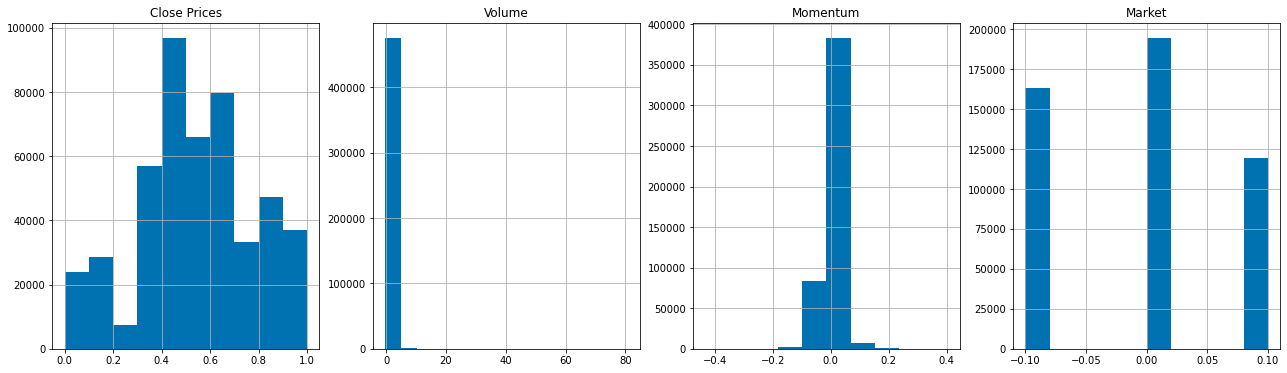

In [87]:
# Let's do some final graphs to visualize better the data we use:
%matplotlib inline
fig, ax = plt.subplots(1, 4, figsize=(22, 6))
apple_set_1min.close.hist(ax=ax[0])
apple_set_1min.volume.hist(ax=ax[1], bins=15)
apple_set_1min.momentum.hist(ax=ax[2])
apple_set_1min.market.hist(ax=ax[3])

ax[0].set_title("Close Prices")
ax[1].set_title("Volume")
ax[2].set_title("Momentum")
ax[3].set_title("Market")

plt.savefig('CVMM AAPL-data.png', bbox_inches='tight')

We are ready to prepare our data and fit our model.

But before that, let's repeat this process for 5 minutes and 30 minutes
data.

In [88]:

# Let's download and prepare the 5 minutes periods data
apple_raw_5min = loading_ticker_data(globalpar['test5']['data'])
apple_raw_5min = filling_blank_periods_and_adding_market(apple_raw_5min, 
                                            globalpar['test5']['data'])
apple_raw_5min = filling_nas(apple_raw_5min)
apple_pre_5min = apple_raw_5min.drop(columns=columns_to_drop)
apple_mom_5min = sma_and_momentum(apple_pre_5min, globalpar['test5']['data'])
apple_set_5min, volscaler_5, closescaler_5 = final_set(apple_mom_5min)

# Now 30 minutes period.
apple_raw_30min = loading_ticker_data(globalpar['test30']['data'])
apple_raw_30min = filling_blank_periods_and_adding_market(apple_raw_30min, 
                                            globalpar['test30']['data'])
apple_raw_30min = filling_nas(apple_raw_30min)
apple_pre_30min = apple_raw_30min.drop(columns=columns_to_drop)
apple_mom_30min = sma_and_momentum(apple_pre_30min, globalpar['test30']['data'])
apple_set_30min, volscaler_30, closescaler_30 = final_set(apple_mom_30min)

In [89]:
# Checking the 5 minutes
apple_set_5min.describe()

market         close        volume      momentum          next
count  95375.000000  95375.000000  95375.000000  95375.000000  95375.000000
mean      -0.008809      0.544241      0.000007      0.001833      0.544249
std        0.076193      0.236754      1.000034      0.055145      0.236748
min       -0.100000      0.000000     -0.580231     -0.555420      0.000000
25%       -0.100000      0.403595     -0.573678     -0.021575      0.403603
50%        0.000000      0.528602     -0.527848      0.002224      0.528602
75%        0.100000      0.697220      0.289157      0.027021      0.697220
max        0.100000      1.000000     27.049465      0.537064      1.000000

In [90]:
# Now the 30 minutes
apple_set_30min.describe()

market         close        volume      momentum          next
count  15839.000000  15839.000000  15839.000000  15839.000000  15839.000000
mean      -0.006257      0.546435      0.000040      0.015343      0.546481
std        0.074740      0.235190      1.000049      0.155965      0.235159
min       -0.100000      0.000000     -0.655294     -0.801059      0.000000
25%       -0.100000      0.405483     -0.646247     -0.074073      0.405501
50%        0.000000      0.529738     -0.565455      0.014074      0.529738
75%        0.000000      0.698063      0.359776      0.106794      0.698109
max        0.100000      1.000000     14.153949      0.790867      1.000000

In [91]:
#########1#########2#########3#########4#########5#########6#########7#########8
###                         THIRD PART: MODELING                            ###8
#########1#########2#########3#########4#########5#########6#########7#########8

In this part we will initially implement a function to convert the prepared
dataframes into torch arrays, and later separate the data into training and 
testing data sets, depending on the parameters passed through the function.
Also we will separate the data into input(X) and target(y) arrays to finally
group the input data in a new dimension of batches.

Later in this part we will create our LSTM RNN model with pytorch, and will start
to train and enjoy analyzing the results

In [92]:
# We first implement the function to define the pytroch arrays.
def final_array(data, param):
    '''
    This function calculates the number of batches for testing and training
    data and round the info to take those groups from the last dates.
    
    Function Parameters:
    
    * Required: data: a dataframe with the original stock data and as many
                      columns as input features declared in 'param' and with 
                      a target column.

    * Required: param: a Dictionary with at least the next items:
    
            ** total_size: The total of rows or steps to be used to train.
            ** batch_size: The number of groups of sequence_size per batch
                           to be used to train.
            ** test_size: The size in percentage of the data that will be
                          used for testing.
            ** sequence_size: The sequence or number of steps to be part of
                              use in every group in a batch.
            ** input_size: Number of features in the input data.

    Returns:
        train_X : Pytorch Tensor for training's input.
        test_X  : Pytorch Tensor for testing's input.
        train_y : Pytorch Tensor for training's target.
        test_y  : Pytorch Tensor for testing's target.
    
    '''
    
    # First step to calculate the rounded quantity of batches in test and
    # training sets.
    dataset = data[-param['total_size']-param['sequence_size']:].values
    total_batches = (param['total_size'] // param['batch_size'])
    total_test_batches = int(total_batches * param['test_size']) 
    total_train_batches = total_batches - total_test_batches
    
    # Second we separate the two sets datasets
    train_values = dataset[-total_batches * param['batch_size'] - \
                           param['sequence_size'] + 1: \
                           -total_test_batches * param['batch_size']]
    
    test_values = dataset[(-total_test_batches * param['batch_size'] - \
                           param['sequence_size'] + 1):]
    
    # Finally we separate the input and target arrays
    train_X, train_y = train_values[:,:-1], train_values[\
                                            param['sequence_size']-1:,-1]
    train_batches = len(train_X) - param['sequence_size'] + 1
    
    # And separate the training input set in an array with an extra dimension of
    # batches.
    train_X = np.lib.stride_tricks.as_strided(train_X.flatten(), 
                                              shape=(train_batches, 
                                                     param['sequence_size'], 
                                                     param['input_size']), 
                                              strides=(param['input_size']*4,
                                                       param['input_size']*4,
                                                       4))
    print('final train X shape: {}, train y shape: {}'.format(train_X.shape, 
                                                              train_y.shape))

    # Same process with testing set
    test_X, test_y = test_values[:,:-1], test_values[\
                                        param['sequence_size']-1:,-1]
    test_batches = len(test_X) - param['sequence_size'] + 1
    test_X = np.lib.stride_tricks.as_strided(test_X.flatten(), 
                                             shape=(test_batches, 
                                                    param['sequence_size'], 
                                                    param['input_size']), 
                                             strides=(param['input_size']*4,
                                                      param['input_size']*4,
                                                      4))
    print('final test X shape: {}, test y shape: {}'.format(test_X.shape, 
                                                            test_y.shape))
    
    # To tensors:
    train_X = torch.Tensor(train_X)
    test_X = torch.Tensor(test_X)
    train_y = torch.Tensor(train_y)
    test_y = torch.Tensor(test_y)

    return train_X, train_y, test_X, test_y



In [93]:
# Let's test the function above
train_X, train_y, test_X, test_y = final_array(apple_set_1min, 
                                               globalpar['test1']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

final train X shape: (7680, 30, 4), train y shape: (7680,)
final test X shape: (1920, 30, 4), test y shape: (1920,)
torch.Size([7680, 30, 4]) torch.Size([7680]) torch.Size([1920, 30, 4]) torch.Size([1920])


In [94]:
# Our model will be feeded by a DataLoader part of the pytorch library.
# This Dataloader demands that the data must be a class Data_Prep with
# the characteristics below. This class should have the __len__ and 
# __getitem__ methods as showed.

class Data_Prep(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [95]:
# Now let's do the magic happen
class Model_LSTM(torch.nn.Module):
    '''
    Here is the model of a LSTM neural network.
    Here we declare initially the constants and the RNN methods in the
    Pytorch library, to be implemented in our model.
    Later we declare the method forward were we execute those methods
    in a specific order.
    '''
    
    def __init__(self, param, init_wgs=True):
        super().__init__()
        # Initial variables
        self.input_size = param['model_input_size']
        self.hidden_size = param['model_lstm_size']
        self.num_layers = param['model_lstm_layers']
        self.output_size = param['model_output']
        self.drop_prob = param['model_dropout']

        # First layer to receive the features and output the LSTM size
        self.linear = torch.nn.Linear(param['model_input_size'], 
                                      param['model_lstm_size'])
        # Activation function
        self.relu = torch.nn.ReLU() 
        
        # LSTM RNN
        self.lstm = torch.nn.LSTM(param['model_lstm_size'], 
                                  hidden_size=self.hidden_size, 
                                  num_layers=self.num_layers,
                                  dropout=self.drop_prob, 
                                  batch_first=True,
                                  bias=True)
        
        # A Dropout in case we use only one layer in the LSTM
        self.dropout = torch.nn.Dropout(param['model_dropout'])
        
        # Final layer to change from LSTM output to 1 target price
        self.linear_end = torch.nn.Linear(self.hidden_size*self.num_layers,
                                          self.output_size)
        
        if init_wgs:
            self.init_weights()
        
    # The method that do the magic
    # recieve the hidden and cell states to give the chance no to 
    # initialize them every batch
    def forward(self, x):
        
        batchsize = x.shape[0]
        
        # now apply every step in order
        x = self.linear(x)
        
        x = self.relu(x) 
        
        # LSTM layer
        lstm_out, (hn, cn) = self.lstm(x) 
        
        x = hn.permute(1,0,2).reshape(batchsize, -1)
        
        x = self.dropout(x)
        
        out = self.linear_end(x)
                
        return out[:,-1]
    
    # This method to initialize the weights
    def init_weights(self):
        for name, pm in self.lstm.named_parameters():
            if 'bias_ih' in name:
                torch.nn.init.constant_(pm, 0.0)
            elif 'weight_ih' in name:
                torch.nn.init.kaiming_normal_(pm)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(pm)

In [96]:
# here I separate trainin and testing in two differente functions:
def train_model(model, data, criterion, opt, param):
    '''
    This function do the training.
    
    Function Parameters:
    
    * Required: model: The RNN model to be trained.
    
    * Required: data: a DataLoader iterator with the input and targe data.
    
    * Required: criterion: The criterion function to calculate the loss.
    
    * Required: opt: The optimizer function to be implemented.

    * Required: param: a Dictionary with at least the next items:
    
            ** model_lstm_layers: The number of layers in our LSTM model.
            ** batch_size:  The number of groups of sequence_size per batch
                            to be used to train.
            ** model_lstm_size:   The size of our LSTM network.

    Returns:
        epoch_loss : The loss calculated at the end of every training epoch.
    '''
    epoch_loss = 0
    # Activating the training process on the model sent
    model.train()
   
    # The loop to iterate all the data once and train the model
    for n, (x, y) in enumerate(data):
        
        opt.zero_grad()

        batchsize = x.shape[0]
        
        out = model(x)
        
        loss = criterion(out, y)
        
        loss.backward()
        
        opt.step()

        epoch_loss += (loss.detach().item() / batchsize)

    return epoch_loss

def test_model(model, data, criterion, param):
    '''
    This function do the testing to the trained model.
    
    Function Parameters:
    
    * Required: model: The RNN model to be trained.
    
    * Required: data: a DataLoader iterator with the input and targe data.
    
    * Required: criterion: The criterion function to calculate the loss.

    * Required: param: a Dictionary with at least the next items:
   
            ** model_lstm_layers: The number of layers in our LSTM model.
            ** batch_size:   The number of groups of sequence_size per batch
                             to be used to train.
            ** model_lstm_size:   The size of our LSTM network.

    Returns:
        epoch_loss : The loss calculated at the end of every testing epoch.
    '''
    epoch_loss = 0
    # Activating the testing process on the model sent
    model.eval()

    # The loop to iterate all the data once and test the model
    for x, y in data:

        batchsize = x.shape[0]
        
        out = model(x)
        
        loss = criterion(out, y)

        epoch_loss += (loss.detach().item() / batchsize)

    return epoch_loss

In [97]:
def training_model(train_X, train_y, test_X, test_y, param, init_wgs=True):
    '''
    This functions creates the dataloader, creates the model, select the 
    optimizer and then train and test the model for every epoch
    we declare.
    
    Function Parameters:
    
    * Required: train_X, train_y, test_X, test_y: All de input and target
                                                  training and testing
                                                  sets.

    * Required: param: a Dictionary with at least the next items:
    
            ** batch_size: The number of groups of sequence_size per batch
                           to be used to train.
            ** optimizer:  The optimizer selected for the training.
            ** epochs:     The number of epochs to or loops to train the model.
            ** lrs:        The learning rate list.
            ** weight_decay:   The weight_decay parameter for the optimizer.
            ** optimizer:      The optimizer selected for the training.
            ** lr_change:      The variable that define if iterates for the
                               learning rate list.
            ** other params:The other parameters needs for the training and
                            test functions.

    Returns:
        model : Model trained.
        losses_training: The losses during all the epochs in a list.
        losses_testing:  The losses during all the epochs in a list.
        
    '''
    
    
    # Declare of train and test sets in Data_Prep class
    train_series = Data_Prep(train_X, train_y)
    test_series  = Data_Prep(test_X, test_y)
    
    # Initializing the dataloaders
    train_dataloader = DataLoader(train_series, batch_size=param['batch_size'],
                                  shuffle=True)
    test_dataloader  = DataLoader(test_series, batch_size=param['batch_size'], 
                                 shuffle=True)
    # Creating the model
    model = Model_LSTM(param, init_wgs)

    # Defining the optimizer
    if param['optimizer'] == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=param['lrs'][0], 
                              momentum=0.9)
    elif param['optimizer'] == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=param['lrs'][0], 
                               weight_decay=param['weight_decay'])
    elif param['optimizer'] == 'Adagrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=param['lrs'][0])

    # Creating the criterion for measuring the losses
    criterion = torch.nn.MSELoss()
    losses_training = []
    losses_testing = []

    print("Optimizer: {}, Leaning rate: {}".format(param['optimizer'], 
                                                   param['lrs'][0]))

    # The final epoch loop
    for epoch in range(param['epochs']):
        
        # Changing the learning rate if applies
        if param['lr_change']:
            change = int(epoch // param['epochs_change'])
            opt.param_groups[0]['lr'] = param['lrs'][change]

        # Training and saving the losses    
        loss_train = train_model(model, train_dataloader, criterion, opt, param)
        
        losses_training.append(loss_train)
        
        # Testing and saving the losses
        loss_test = test_model(model, test_dataloader, criterion, param)
        
        losses_testing.append(loss_test)

        # Printing the losses results every X epochs
        if (epoch+1)%10 == 0:
            print('Epoch[{}/{}] | loss train:{:.8f}, test:{:.8f}, lr: {}'
                  .format(epoch+1, param['epochs'], loss_train, loss_test, 
                          opt.param_groups[0]['lr']))

    print('last train: {}, minimo train: {} '.\
          format(losses_training[-1], np.array(losses_training).min()))
    print('last test: {}, minimo test: {}'.\
          format(losses_testing[-1], np.array(losses_testing).min()))
        
    return model, losses_training, losses_testing


Starting with training, we will iterate for different optimizers,
with different learning rates and with a fixed sample size to verify
which is more efficient for this type of data.

We will check the results later.

Next, we'll create a function to iterate over multiple parameters for the future purpose of testing multiple design models at once.

In [98]:
def multivariate_model_train(data, param):
    '''
    This function creates nested loops to iterate for many of the training 
    variables in our global parameter structure, to them make training of every
    possible combination with them.
    
    Function Parameters:
    
    * Required: data :  a Dataframe with the required data already processed.

    * Required: param: a Dictionary with at least the next items:
    
            ** structure: a Dictionary with the data necessary for creates the
                          torch arrays for training and testing.
            ** training:  a Dictionary with the already known data for training 
                          purposes.
    Returns:
        tests : It only return the parameters and losses of every test. Don't 
                return the model. You will to repeat a training but only with 
                the model with best results.
        
    '''
    
    # Initial values for our saving variables
    tests = {}
    test = 1
    wds = param['training']['weight_decay']
    eps = param['training']['epochs']
    dos = param['training']['model_dropout']
    lrs = param['training']['lrs']
    szs = param['structure']['total_size']
    bchs = param['structure']['batch_size']
    lstm_ss = param['training']['model_lstm_size']
    lstm_ls = param['training']['model_lstm_layers']
    opts = param['training']['optimizer']
    seq = param['training']['sequence_size']
    
    # A new param to not to change 
    new_param = param.copy()

    # Now the loops to iterate for every desired variable
    for sz in szs:
        for bch in bchs:
            new_param['structure']['batch_size'] = bch
            new_param['structure']['total_size'] = sz
            # Processing our final arrays for every test
            train_X, train_y, test_X, test_y = final_array(data, 
                                               new_param['structure'])
            print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            for lstm_s in lstm_ss:
                for lstm_l in lstm_ls:
                    for opt in opts:
                        for lr in lrs:
                            for wd in wds:
                                for ep in eps:
                                    for do in dos:

                                        # Parameters to train
                                        new_param['training']\
                                        ['batch_size'] = bch
                                        new_param['training']\
                                        ['model_lstm_layers'] = lstm_l
                                        new_param['training']\
                                        ['model_lstm_size'] = lstm_s
                                        new_param['training']\
                                        ['model_dropout'] = do
                                        new_param['training']\
                                        ['epochs'] = ep
                                        new_param['training']\
                                        ['lrs'] = lr
                                        new_param['training']\
                                        ['lr_change'] = False
                                        new_param['training']\
                                        ['optimizer'] = opt
                                        new_param['training']\
                                        ['weight_decay'] = wd   

                                        # Training
                                        model, loss_train, loss_test = \
                                                        training_model(train_X, 
                                                                       train_y, 
                                                                       test_X, 
                                                                       test_y,
                                                        new_param['training'])
                                        # Saving the results
                                        tests['test-'+str(test)] = \
                                               {'opt' : opt,
                                                'lr' : lr,
                                                'size' : sz,
                                                'seq' : seq,
                                                'batches' : bch,
                                                'weight_decay' : wd,
                                                'epochs' : ep,
                                                'dropout' : do,
                                                'lstm_size' : lstm_s,
                                                'lstm_layer' : lstm_l,
                                                'training' : loss_train,
                                                'testing' : loss_test,
                                                'min_train' : \
                                                np.array(loss_train).min(),
                                                'min_test' : \
                                                np.array(loss_test).min(),
                                                'last_train' : loss_train[-1],
                                                'last_test' : loss_test[-1]}
                                        test += 1

    return tests, model

In [100]:
# Create a globalpar dictionary with iterables values for the purpose 
# mention above
multipar = globalpar['test1']
multipar['structure']['total_size'] = [4800]
multipar['structure']['batch_size'] = [64]
multipar['training']['model_lstm_size'] = [128]
multipar['training']['model_lstm_layers'] = [3]
multipar['training']['model_dropout'] = [0.3]
multipar['training']['epochs'] = [100]
multipar['training']['lrs'] = [[0.05], [0.01], [0.005], [0.001]]
multipar['training']['weight_decay'] = [0.]
multipar['training']['optimizer'] = ['SGD', 'Adagrad', 'Adam']

tests, _ = multivariate_model_train(apple_set_1min, multipar)

final train X shape: (3840, 30, 4), train y shape: (3840,)
final test X shape: (960, 30, 4), test y shape: (960,)
torch.Size([3840, 30, 4]) torch.Size([3840]) torch.Size([960, 30, 4]) torch.Size([960])
Optimizer: SGD, Leaning rate: 0.05
Epoch[10/100] | loss train:0.00042627, test:0.00022349, lr: 0.05
Epoch[20/100] | loss train:0.00021253, test:0.00007574, lr: 0.05
Epoch[30/100] | loss train:0.00013290, test:0.00003281, lr: 0.05
Epoch[40/100] | loss train:0.00008820, test:0.00001897, lr: 0.05
Epoch[50/100] | loss train:0.00007514, test:0.00001593, lr: 0.05
Epoch[60/100] | loss train:0.00006022, test:0.00001196, lr: 0.05
Epoch[70/100] | loss train:0.00005613, test:0.00000952, lr: 0.05
Epoch[80/100] | loss train:0.00004826, test:0.00000809, lr: 0.05
Epoch[90/100] | loss train:0.00004844, test:0.00000498, lr: 0.05
Epoch[100/100] | loss train:0.00004403, test:0.00000789, lr: 0.05
last train: 4.403251946882847e-05, minimo train: 4.225184935080506e-05 
last test: 7.893604305309054e-06, minimo

Epoch[80/100] | loss train:0.00002114, test:0.00003015, lr: 0.01
Epoch[90/100] | loss train:0.00001570, test:0.00001601, lr: 0.01
Epoch[100/100] | loss train:0.00001588, test:0.00001498, lr: 0.01
last train: 1.5879574604582558e-05, minimo train: 1.2818847849871418e-05 
last test: 1.4975397448324657e-05, minimo test: 1.1519981597984952e-05
Optimizer: Adam, Leaning rate: 0.005
Epoch[10/100] | loss train:0.00101764, test:0.00011617, lr: 0.005
Epoch[20/100] | loss train:0.00069801, test:0.00026921, lr: 0.005
Epoch[30/100] | loss train:0.00042593, test:0.00006531, lr: 0.005
Epoch[40/100] | loss train:0.00029850, test:0.00000631, lr: 0.005
Epoch[50/100] | loss train:0.00017737, test:0.00000981, lr: 0.005
Epoch[60/100] | loss train:0.00008803, test:0.00000901, lr: 0.005
Epoch[70/100] | loss train:0.00003834, test:0.00000458, lr: 0.005
Epoch[80/100] | loss train:0.00002661, test:0.00000354, lr: 0.005
Epoch[90/100] | loss train:0.00001065, test:0.00000365, lr: 0.005
Epoch[100/100] | loss train:

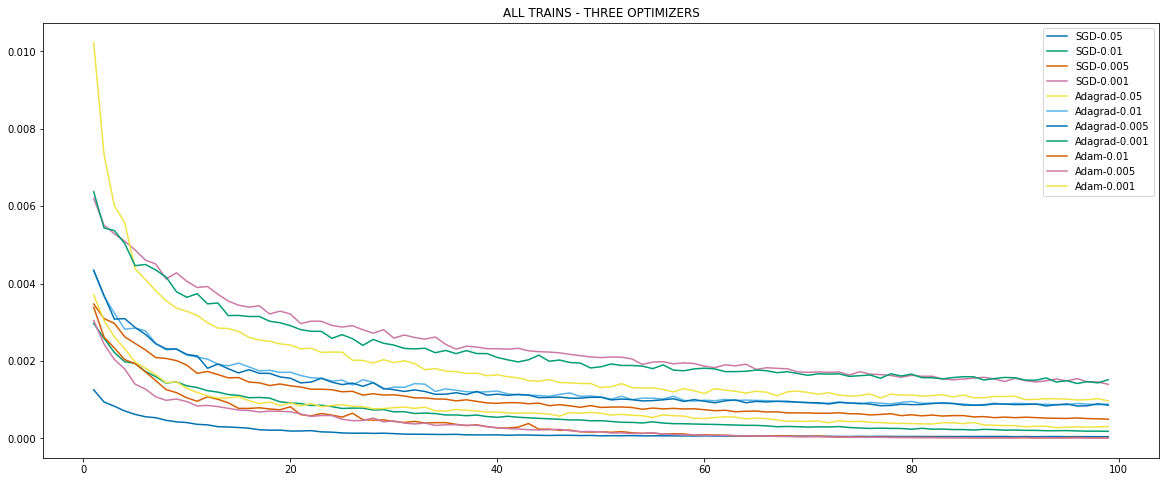

In [120]:
# Let's transform the results in a dataframe and plot the different training 
# tests
df = pd.DataFrame(tests)
data_train = pd.DataFrame(df.loc['training','test-1'])

for test in list(tests.keys())[1:]:
    data_train[test] = pd.DataFrame(df.loc['training',test])

data_train.rename(columns={0:'SGD-0.05', 'test-2':'SGD-0.01', 
                           'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                           'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 
                           'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                           'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 
                           'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, 
                  inplace=True)
to_print = ['SGD-0.05', 'SGD-0.01', 'SGD-0.005', 'SGD-0.001', 'Adagrad-0.05',
            'Adagrad-0.01', 'Adagrad-0.005', 'Adagrad-0.001', 
            'Adam-0.01','Adam-0.005','Adam-0.001']
data_train.loc[1:,to_print].\
                  plot(title='ALL TRAINS - THREE OPTIMIZERS',figsize=(20,8))
plt.savefig('MultiOptimizers Train AAPL.png', bbox_inches='tight')

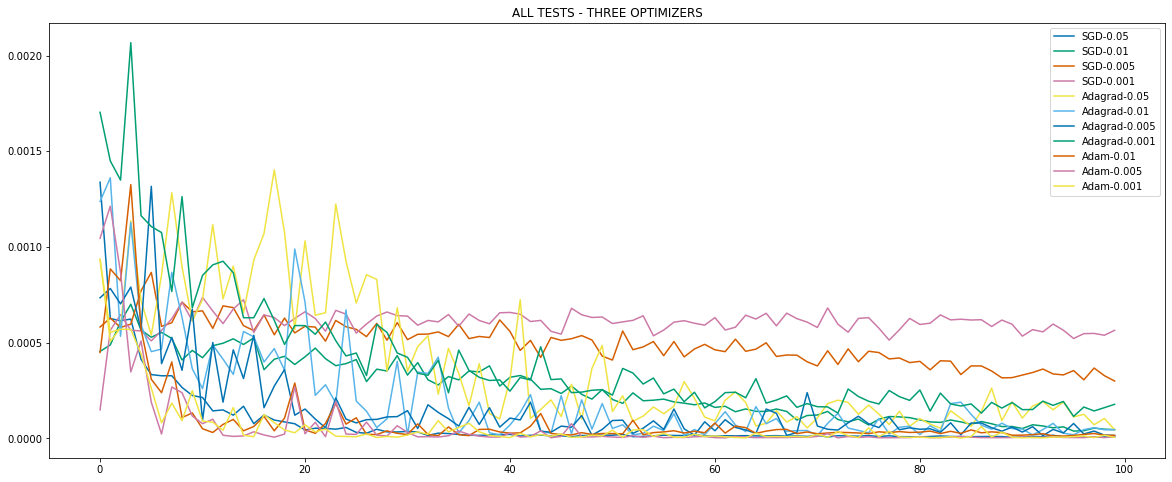

In [121]:
# Let's do the same with the testing results
data_test = pd.DataFrame(df.loc['testing','test-1'])

for test in list(tests.keys())[1:]:
    data_test[test] = pd.DataFrame(df.loc['testing',test])

data_test.rename(columns={0:'SGD-0.05', 'test-2':'SGD-0.01', 
                           'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                           'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 
                           'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                           'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 
                           'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, 
                 inplace=True)

data_test.loc[:,to_print].\
                plot(title='ALL TESTS - THREE OPTIMIZERS', figsize=(20,8))
plt.savefig('MultiOptimizers Test AAPL.png', bbox_inches='tight')

In [122]:
# Now some changes to the names and transpose the dataframe
df.rename(columns={'test-1':'SGD-0.05', 'test-2':'SGD-0.01', 
                   'test-3':'SGD-0.005', 'test-4':'SGD-0.001',
                   'test-5':'Adagrad-0.05', 'test-6':'Adagrad-0.01', 
                   'test-7':'Adagrad-0.005', 'test-8':'Adagrad-0.001',
                   'test-9':'Adam-0.05', 'test-10':'Adam-0.01', 
                   'test-11':'Adam-0.005', 'test-12':'Adam-0.001'}, 
          inplace=True)

dfT = df.T
dfT

opt       lr  size seq batches weight_decay epochs dropout  \
SGD-0.05           SGD   [0.05]  4800  30      64          0.0    100     0.3   
SGD-0.01           SGD   [0.01]  4800  30      64          0.0    100     0.3   
SGD-0.005          SGD  [0.005]  4800  30      64          0.0    100     0.3   
SGD-0.001          SGD  [0.001]  4800  30      64          0.0    100     0.3   
Adagrad-0.05   Adagrad   [0.05]  4800  30      64          0.0    100     0.3   
Adagrad-0.01   Adagrad   [0.01]  4800  30      64          0.0    100     0.3   
Adagrad-0.005  Adagrad  [0.005]  4800  30      64          0.0    100     0.3   
Adagrad-0.001  Adagrad  [0.001]  4800  30      64          0.0    100     0.3   
Adam-0.05         Adam   [0.05]  4800  30      64          0.0    100     0.3   
Adam-0.01         Adam   [0.01]  4800  30      64          0.0    100     0.3   
Adam-0.005        Adam  [0.005]  4800  30      64          0.0    100     0.3   
Adam-0.001        Adam  [0.001]  4800  30      64          0.0    100     0.3   

              lstm_size lstm_layer  \
SGD-0.05            128          3   
SGD-0.01            128          3   
SGD-0.005           128          3   
SGD-0.001           128          3   
Adagrad-0.05        128          3   
Adagrad-0.01        128          3   
Adagrad-0.005       128          3   
Adagrad-0.001       128          3   
Adam-0.05           128          3   
Adam-0.01           128          3   
Adam-0.005          128          3   
Adam-0.001          128          3   

                                                        training  \
SGD-0.05       [0.049650428010863834, 0.0012543614393507596, ...   
SGD-0.01       [0.04785778264704277, 0.002970983816339867, 0....   
SGD-0.005      [0.06152283254414215, 0.0034708618732111063, 0...   
SGD-0.001      [0.09296242424898082, 0.006203499142429791, 0....   
Adagrad-0.05   [2.2262946728005772, 0.010223259741906077, 0.0...   
Adagrad-0.01   [0.11134711325212265, 0.004325882971897954, 0....   
Adagrad-0.005  [0.029603573595522903, 0.004345822002505884, 0...   
Adagrad-0.001  [0.0295774613332469, 0.0063713129493407905, 0....   
Adam-0.05      [2.751266360282898, 0.11104421387426555, 0.012...   
Adam-0.01      [0.11612356627301779, 0.0033861988049466163, 0...   
Adam-0.005     [0.023619993720785715, 0.003044414726900868, 0...   
Adam-0.001     [0.03025034816164407, 0.0037047006262582727, 0...   

                                                         testing min_train  \
SGD-0.05       [0.0013380885138758458, 0.0006256644555833191,...  0.000042   
SGD-0.01       [0.00045371082705969457, 0.0004876024322584271...   0.00018   
SGD-0.005      [0.0005811754926980939, 0.0006281169262365438,...  0.000495   
SGD-0.001      [0.0001483196288063482, 0.0005636093592329416,...  0.001396   
Adagrad-0.05   [0.0009341715995105915, 0.0005056083391536959,...   0.00097   
Adagrad-0.01   [0.0012370054319035262, 0.001361310285574291, ...   0.00086   
Adagrad-0.005  [0.0007340176416619215, 0.0007827637818991207,...  0.000836   
Adagrad-0.001  [0.001703426125459373, 0.0014492217596853152, ...  0.001416   
Adam-0.05      [0.001868379840743728, 0.003440331929596141, 0...  0.000106   
Adam-0.01      [0.000448246259111329, 0.0008848915931594092, ...  0.000013   
Adam-0.005     [0.0010448931752762292, 0.001212657181895338, ...  0.000008   
Adam-0.001     [0.0009356382724945433, 0.0005528688961931039,...  0.000276   

               min_test last_train last_test  
SGD-0.05       0.000005   0.000044  0.000008  
SGD-0.01       0.000037    0.00018  0.000045  
SGD-0.005      0.000299   0.000495  0.000299  
SGD-0.001      0.000148   0.001396  0.000564  
Adagrad-0.05   0.000045    0.00097  0.000045  
Adagrad-0.01   0.000014   0.000886  0.000044  
Adagrad-0.005  0.000013   0.000855  0.000014  
Adagrad-0.001  0.000114   0.001515  0.000177  
Adam-0.05      0.000006   0.000331  0.000007  
Adam-0.01      0.000012   0.000016  0.000015  
Adam-0.005     0.000002   0.000008  0.000008  
Adam-0

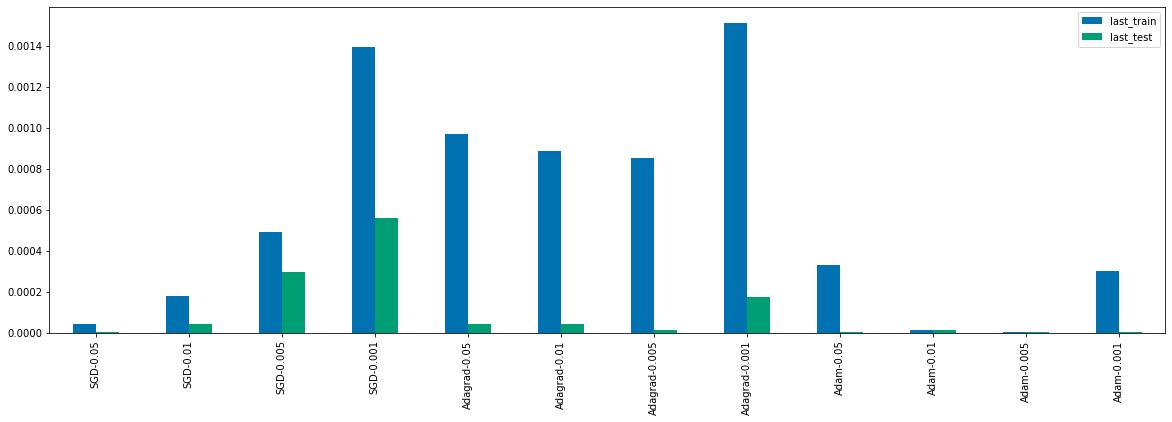

In [123]:
# To have a better view of the results let's make a bag graph with the final
# train and test losses in every iteration
dfT.loc[:,'last_train':'last_test'].plot(figsize=(20,6), kind='bar')
plt.savefig('MultiOptimizers Results AAPL.png', bbox_inches='tight')

Now and on we the will work with the Adam optimizer and a learning rate of 0.005 for having the best results.

In [124]:
# Some check to our data
globalpar['test1']

{'data': {'ticker': 'AAPL', 'interval': '1min', 'minutes': 1, 'sma_range': 30},
 'structure': {'training_size': 0.8,
  'test_size': 0.2,
  'total_size': 9600,
  'sequence_size': 30,
  'batch_size': 64,
  'input_size': 4,
  'weight_decay': 0.0},
 'training': {'sequence_size': 30,
  'batch_size': 64,
  'model_input_size': 4,
  'model_lstm_layers': 3,
  'model_lstm_size': 128,
  'model_dropout': 0.3,
  'model_output': 1,
  'epochs': 300,
  'optimizer': 'Adam',
  'lrs': [0.005, 0.001],
  'lr_change': True,
  'epochs_change': 200,
  'weight_decay': 0.0}}

In [125]:
# Let's do a test of the LSTM with or without initializing the weights
# Without the initialization and a bigger size of 9600 rows (10 trading days):
train_X, train_y, test_X, test_y = final_array(apple_set_1min, 
                                               globalpar['test1']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y, 
                                              globalpar['test1']['training'], 
                                              init_wgs=False)

final train X shape: (7680, 30, 4), train y shape: (7680,)
final test X shape: (1920, 30, 4), test y shape: (1920,)
torch.Size([7680, 30, 4]) torch.Size([7680]) torch.Size([1920, 30, 4]) torch.Size([1920])
Optimizer: Adam, Leaning rate: 0.005
Epoch[10/300] | loss train:0.00135493, test:0.00030662, lr: 0.005
Epoch[20/300] | loss train:0.00053082, test:0.00001780, lr: 0.005
Epoch[30/300] | loss train:0.00015019, test:0.00001570, lr: 0.005
Epoch[40/300] | loss train:0.00002929, test:0.00002348, lr: 0.005
Epoch[50/300] | loss train:0.00001077, test:0.00001450, lr: 0.005
Epoch[60/300] | loss train:0.00001043, test:0.00001560, lr: 0.005
Epoch[70/300] | loss train:0.00000810, test:0.00002279, lr: 0.005
Epoch[80/300] | loss train:0.00001398, test:0.00002187, lr: 0.005
Epoch[90/300] | loss train:0.00001211, test:0.00002643, lr: 0.005
Epoch[100/300] | loss train:0.00001074, test:0.00005840, lr: 0.005
Epoch[110/300] | loss train:0.00001032, test:0.00002139, lr: 0.005
Epoch[120/300] | loss train:0

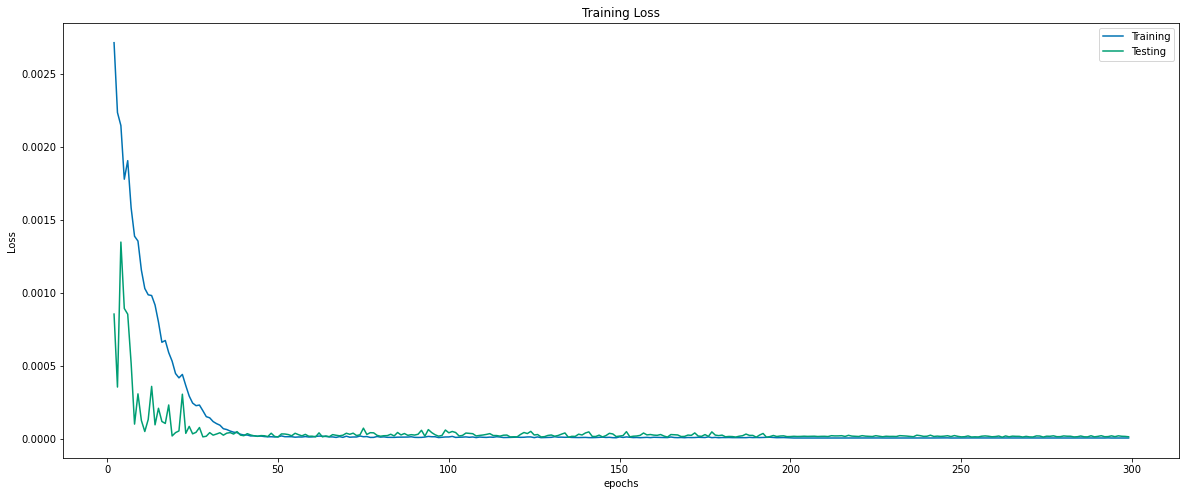

In [128]:
# Adam tests with 300 epochs and volume scaled as normal distribution and close 
# prices as a linear normalization and learning rate reduced after 200 epochs. 
# Without weights initialization.
graph_NoW = pd.DataFrame({'Training': loss_train, 'Testing' : loss_test})
graph_NoW.loc[2:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', 
                       ylabel='Loss')
plt.savefig('Final Adam losses AAPL.png', bbox_inches='tight')

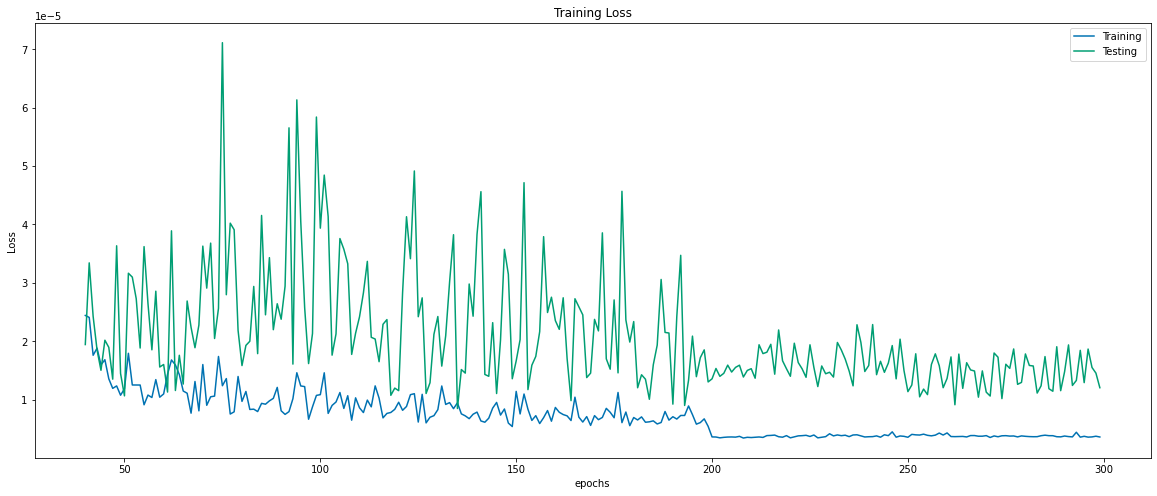

In [129]:
# Closer
graph_NoW.loc[40:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', 
                        ylabel='Loss')
plt.savefig('Final Adam losses closer AAPL.png', bbox_inches='tight')

In [130]:
# Now with the initialization:
train_X, train_y, test_X, test_y = final_array(apple_set_1min, 
                                               globalpar['test1']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model_w, loss_train_w, loss_test_w = training_model(train_X, train_y, test_X, 
                                                    test_y, 
                                                globalpar['test1']['training'])

final train X shape: (7680, 30, 4), train y shape: (7680,)
final test X shape: (1920, 30, 4), test y shape: (1920,)
torch.Size([7680, 30, 4]) torch.Size([7680]) torch.Size([1920, 30, 4]) torch.Size([1920])
Optimizer: Adam, Leaning rate: 0.005
Epoch[10/300] | loss train:0.00166137, test:0.00023887, lr: 0.005
Epoch[20/300] | loss train:0.00070003, test:0.00015368, lr: 0.005
Epoch[30/300] | loss train:0.00025264, test:0.00012448, lr: 0.005
Epoch[40/300] | loss train:0.00005690, test:0.00005040, lr: 0.005
Epoch[50/300] | loss train:0.00002356, test:0.00003992, lr: 0.005
Epoch[60/300] | loss train:0.00001372, test:0.00006855, lr: 0.005
Epoch[70/300] | loss train:0.00001141, test:0.00005778, lr: 0.005
Epoch[80/300] | loss train:0.00001040, test:0.00003405, lr: 0.005
Epoch[90/300] | loss train:0.00002306, test:0.00005380, lr: 0.005
Epoch[100/300] | loss train:0.00000853, test:0.00008094, lr: 0.005
Epoch[110/300] | loss train:0.00000821, test:0.00004709, lr: 0.005
Epoch[120/300] | loss train:0

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

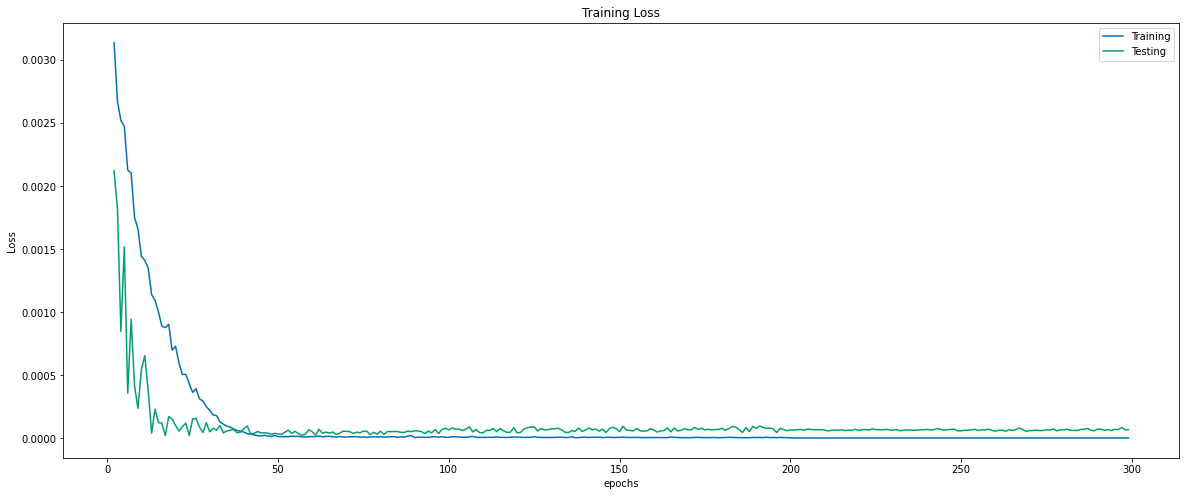

In [131]:
# Adam tests with 300 epochs and volume scaled as normal distribution and close 
# prices as a linear normalization and learning rate reduced after 200 epochs.
graph_YesW = pd.DataFrame({'Training': loss_train_w, 'Testing' : loss_test_w})
graph_YesW.loc[2:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', 
                        ylabel='Loss')

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

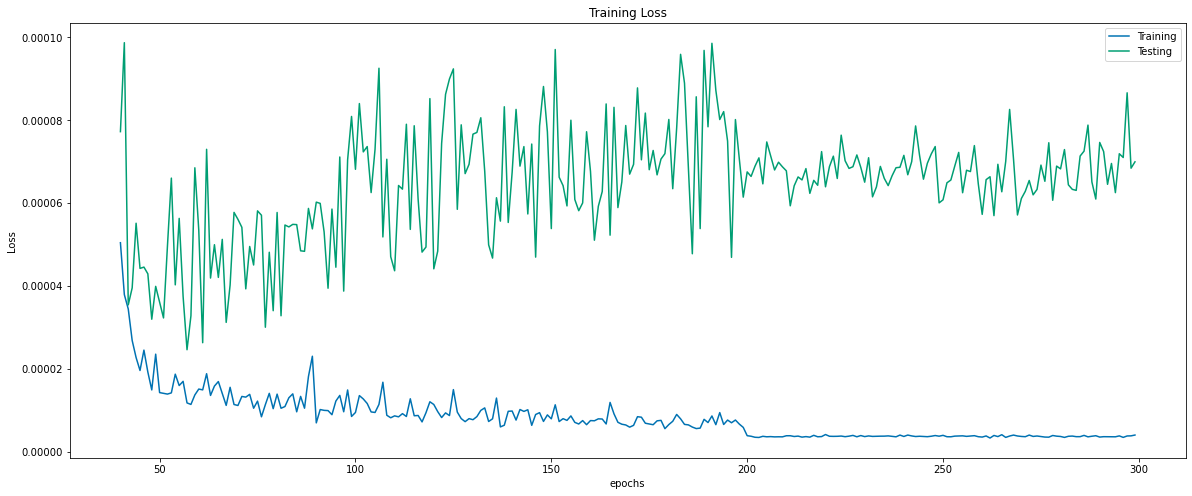

In [132]:
# Closer
graph_YesW.loc[40:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', 
                         ylabel='Loss')

Some conclusions about the results: Initialize the weights at the moment do not represent a big change in the final results except having a better starting point and better performance at the beginning of the training, but not a great finale. We will be working without weight initialization.

Let's now save the model we will be using further. And loading it again for the next analysis.

We will be creating a function to prepare data to feed the model and predict the prices, following by a function to predict the prices and a final function to denormalize the data predicted and check the original prices scales.

In [134]:
# Functions to save and load the trained model
def saving_model(model, filename):
    '''
    Function that save the pytorch model receive to the current directory with
    the filename provided.
    
    Function Parameters:
    
    * Required: model : the pytroch trained model.

    * Required: filename: filename to use as a .dat file
    
    '''
    path = os.getcwd() + '/' + filename + '.dat'
    torch.save(model, path)

def loading_model(filename):
    '''
    Function that load a pytorch model from the file with the name provided at
    the current directory.
    
    Function Parameters:

    * Required: filename: filename to use as a .dat file
    
    Return:
        A pytorch model.  
        
    '''
    path = os.getcwd() + '/' + filename + '.dat'
    return torch.load(path)

In [135]:
# Executing the above functions:
saving_model(model, 'aapl_predicting_model_1minute')

model_apple_1min = loading_model('aapl_predicting_model_1minute')

In [136]:
# Preparing all the data to predict and graph
# We use all the data, meaning the one used for training and the one used for 
# testing as one only time serie to predict. To see how the model really did it
# on both sets.
def data_to_predict(data, param):
    '''
    This function prepares all the data involved in training and testing to make
    a final multidimensional array to feed the model for prediction.
    
    Function Parameters:

    * Required: data: The original data used for training and testing sets.
    
    * Required: param: The structure parameters for the related test with at
                       least the next variables:
                            * total_size
                            * sequence_size
                            * input_size
    
    Returns:
        two arrays, the input array and the target array.  
        
    '''
    # Determining the number of rows and batches to produce
    total_rows = (param['total_size'] // param['sequence_size']) * \
                                         param['sequence_size']
    total_test_rows = int(((total_rows * param['test_size']) // \
                           param['sequence_size'] ) * param['sequence_size'])
    total_train_rows = total_rows - total_test_rows
    all_values = data.values[-(total_train_rows+total_test_rows+1):-1]
    batches_to_predict = len(all_values) - param['sequence_size'] + 1
    
    # Now separate the data from input and target
    x, y = all_values[:,:-1], all_values[:,-1]
    
    # Finally restructuring the array
    x = np.lib.stride_tricks.as_strided(x.flatten(), 
                                        shape=(batches_to_predict, 
                                               param['sequence_size'], 
                                               param['input_size']), 
                                               strides=(param['input_size'] * 4, 
                                                        param['input_size'] * 4, 
                                                        4))
    y = y[param['sequence_size']-1:]
    
    return x, y

In [137]:
# Now preparing the data
x_to_predict, y_to_predict = data_to_predict(apple_set_1min, 
                                             globalpar['test1']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(9571, 30, 4) (9571,)


In [138]:
def predicted_df(model, x, y): 
    '''
    This function takes the model and predicts all the x data sent.
    
    Function Parameters:

    * Required: model: The pytorch trained model to use for prediction.
    
    * Required: x, y : The input and target arrays for prediction.
    
    Returns:
        A Dataframe with the close price columnn and the predicted price
        
    '''
    model.eval()
   
    # Restarting the dataloader with shuffle in False to have all the data in 
    # one sequence
    predicting_series = Data_Prep(x, y)
    dataloader_to_predict = DataLoader(predicting_series, batch_size=1, 
                                       shuffle=False)
    # Now iterate for the data and check the predicted values
    results = np.array([[],[]])
    for n, (x, y) in enumerate(dataloader_to_predict):
        #y_predicted, (hn, cn) = model(x, hn, cn)
        y_predicted = model(x)
        results = np.concatenate((results, np.array([y.detach().numpy(), 
                                                     y_predicted.detach().\
                                                     numpy()])), axis = 1)

    return pd.DataFrame(results.T, columns=['close', 'close_predicted'])



In [139]:
# Predicting then
predicted_apple = predicted_df(model_apple_1min, x_to_predict, 
                               y_to_predict)
predicted_apple.tail(10)

close  close_predicted
9561  0.750972         0.759718
9562  0.751981         0.759950
9563  0.752808         0.760486
9564  0.753175         0.760871
9565  0.752349         0.761201
9566  0.751890         0.761081
9567  0.752257         0.760656
9568  0.752349         0.761126
9569  0.751890         0.761049
9570  0.752350         0.761023

In [140]:
# No we need to denormalize or turn back the prices to it original scale
def de_normalize(data, scaler_close):
    '''
    This function takes the dataframe with prices and predictions and the 
    denormalize it using the same scaler used before to scale this close price.
    
    Function Parameters:

    * Required: data: The dataframe with the prices to be denormalized.
    
    * Required: scaler_close : The scaler function used to normalized the
                               close prices.
    
    Returns:
        A Series with the close price columnn and the predicted price to its
        original scale
        
    '''
    
    return scaler_close.inverse_transform(np.array(data).reshape(-1,1))

In [141]:
# Now let's denormalize the data
predicted_apple_denorm = predicted_apple.copy()
predicted_apple_denorm['close'] = de_normalize(predicted_apple['close'], 
                                               closescaler_1)
predicted_apple_denorm['close_predicted'] = \
                de_normalize(predicted_apple['close_predicted'], closescaler_1)
predicted_apple_denorm

close  close_predicted
0     165.299999       165.255141
1     165.299999       165.288260
2     165.199999       165.289967
3     165.359997       165.200369
4     165.359997       165.337091
...          ...              ...
9566  156.100000       157.101147
9567  156.140001       157.054861
9568  156.150000       157.106133
9569  156.100000       157.097661
9570  156.150097       157.094882

[9571 rows x 2 columns]

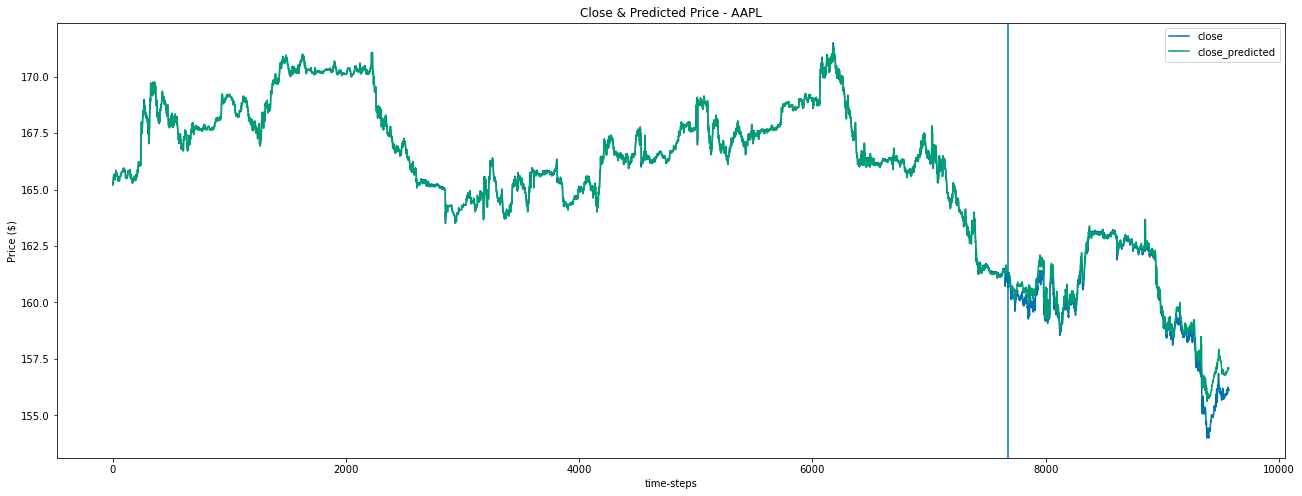

In [150]:
# Let's have a look to the prices graphically
predicted_apple_denorm[:].plot(figsize=(22,8), 
                               title='Close & Predicted Price - AAPL',
                               xlabel = 'time-steps',
                               ylabel = 'Price ($)')
plt.axvline(x=7680)
# The vertical blue line denotes the mid point between training and 
# testing set.
plt.savefig('Price Prediction AAPL.png', bbox_inches='tight')

<AxesSubplot:>

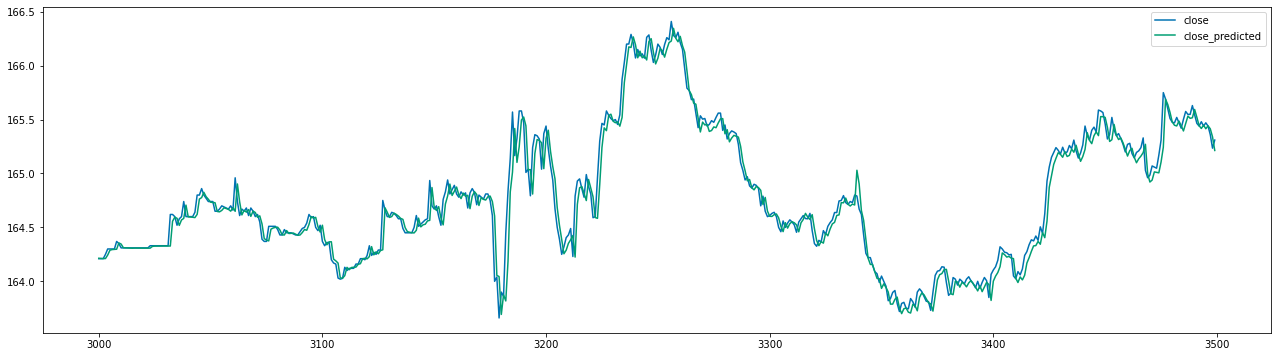

In [143]:
# Closer look to the training area
predicted_apple_denorm[3000:3500].plot(figsize=(22,6))

<AxesSubplot:>

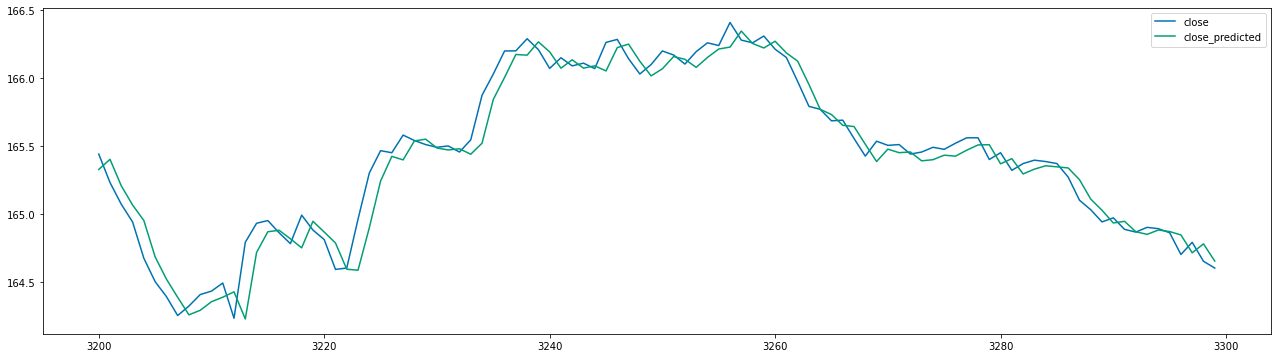

In [144]:
# Closer
predicted_apple_denorm[3200:3300].plot(figsize=(22,6))

<AxesSubplot:>

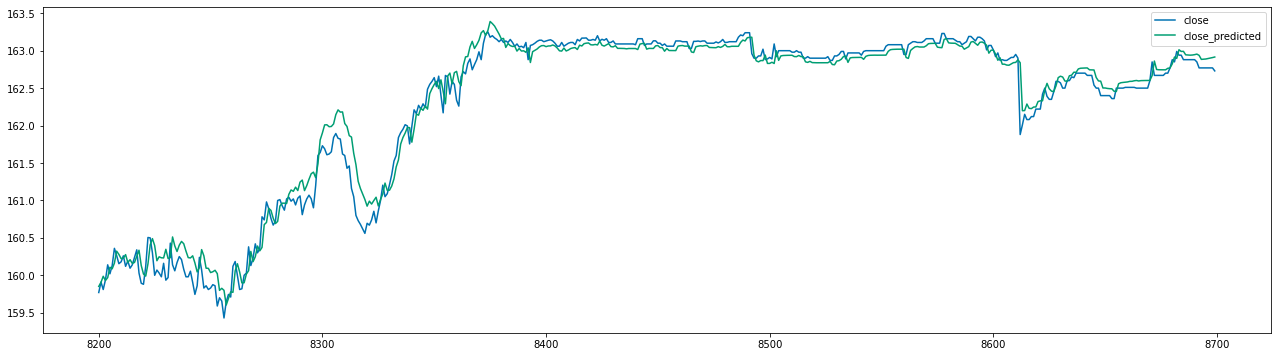

In [145]:
# And a closer look to the testing area
predicted_apple_denorm[8200:8700].plot(figsize=(22,6))

<AxesSubplot:>

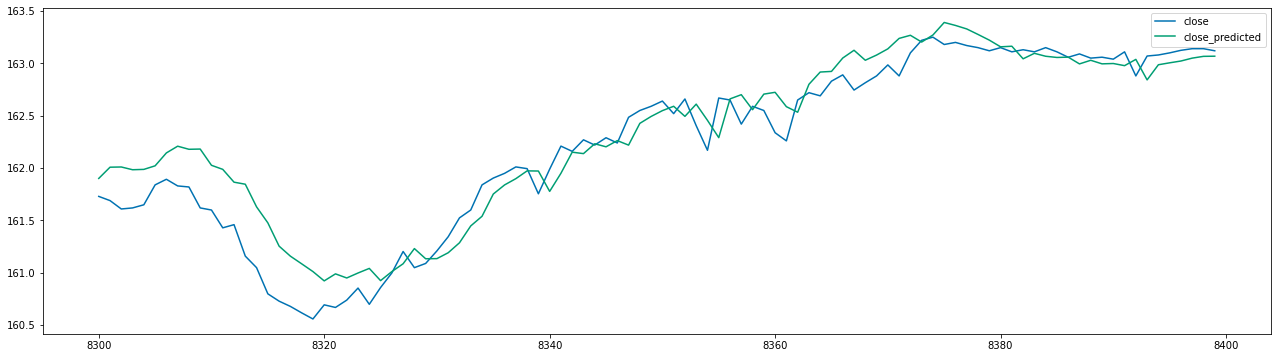

In [146]:
# Closer
predicted_apple_denorm[8300:8400].plot(figsize=(22,6))

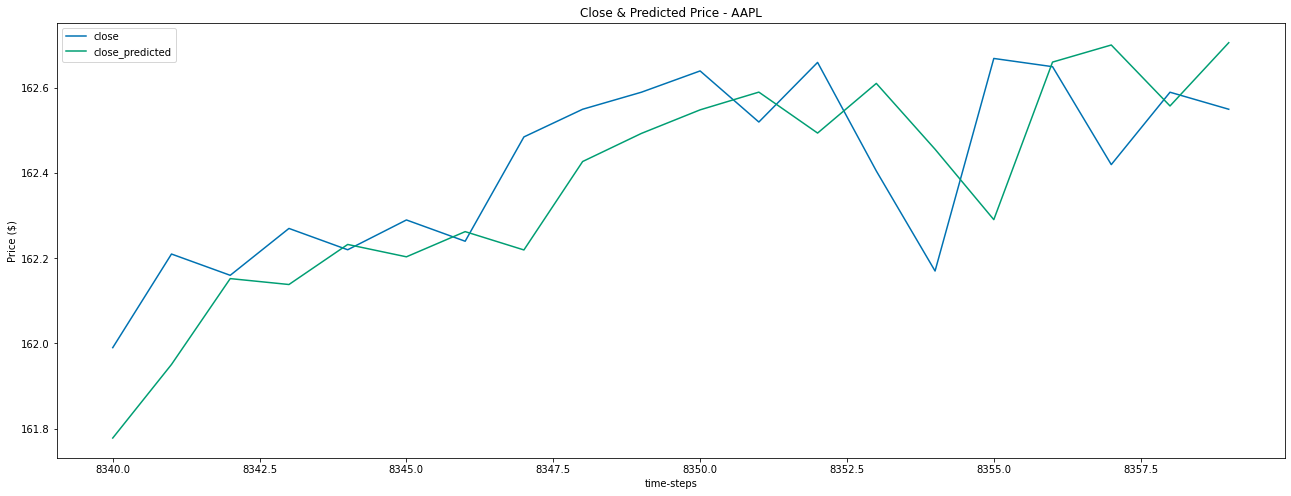

In [149]:
predicted_apple_denorm[8340:8360].plot(figsize=(22,8), 
                               title='Close & Predicted Price - AAPL',
                               xlabel = 'time-steps',
                               ylabel = 'Price ($)')
plt.savefig('Zoom Predicted Price Test-Area AAPL.png', bbox_inches='tight')

What it seems like a line echoing the price data, when you zoom in the plot closer and closer your realize that effectively the graph represents very precisely the original price line, but lagged one step late.

Before taking any conclusions let's first compare this results with a baseline. The best prediction baseline for a time series like this is the value that precedes it one step behind. That is called the persistence model. Let's then calculate this baseline and the error from the correct value. Later let's do the same with our predicted value and then compare both mean errors to compare both lines.

In [151]:
# First the baseline
predicted_apple_denorm['baseline'] = predicted_apple_denorm['close'].shift(1)
predicted_apple_denorm

close  close_predicted    baseline
0     165.299999       165.255141         NaN
1     165.299999       165.288260  165.299999
2     165.199999       165.289967  165.299999
3     165.359997       165.200369  165.199999
4     165.359997       165.337091  165.359997
...          ...              ...         ...
9566  156.100000       157.101147  156.150000
9567  156.140001       157.054861  156.100000
9568  156.150000       157.106133  156.140001
9569  156.100000       157.097661  156.150000
9570  156.150097       157.094882  156.100000

[9571 rows x 3 columns]

In [158]:
# Now let's calculate the return every minute for the baseline, the 
# predicted close price and the real close price
def check_accuracy(data, test = 0.2):
    '''
    Function that calculates the accuracy of predicting positive
    or negative returns in the data, and compares the results with
    a baseline performance line.
    
    Function parameters:
    
        * Required: data: the dataframe with the 'close', 'baseline' and 
                          'close_predicted' columns.
        
    Returns:
        A Dataframe with the new baseline and discrete returns if
                positive or negative return.
        Prints: the accuracy between predicted and real data, and
               the accuracy between the baseline prediction and the
               real data.
    '''
        
    # Some lambda helping lambda functions
    price_return = lambda x: (x - x.shift(1)) / x.shift(1)
    return_posneg = lambda x: (1 * (x >= 0))
    middle = int(len(data) * (1 - test))
    
    data['close_return'] = price_return(data['close'])
    data['predicted_return'] = price_return(data['close_predicted'])
    data['baseline_return'] = price_return(data['baseline'])

    # To measure some accuracy we need to have a discrete value. So we create 
    # a new column that only have a 0 if the return is negative and 1 if 
    # positive.
    data['close_posneg'] = return_posneg(data['close_return'])
    data['predicted_posneg'] = return_posneg(data['predicted_return'])
    data['baseline_posneg'] = return_posneg(data['baseline_return'])
    
    print('Accuracy on training set:')
    print('Pred/Close: {}'.format(accuracy_score(\
                                    data.loc[2:middle]['close_posneg'], 
                                    data.loc[2:middle]['predicted_posneg'])))
    print('Persist/Close: {}'.format(accuracy_score(\
                                    data.loc[2:middle]['close_posneg'], 
                                    data.loc[2:middle]['baseline_posneg'])))
    print('Accuracy on testing set:')
    print('Pred/Close: {}'.format(accuracy_score(\
                                    data.loc[middle:]['close_posneg'], 
                                    data.loc[middle:]['predicted_posneg'])))
    print('Persist/Close: {}'.format(accuracy_score(\
                                    data.loc[middle:]['close_posneg'], 
                                    data.loc[middle:]['baseline_posneg'])))
    
    return data

In [159]:
# now let's compare the accuracy from the predicted and close price and
# baseline and close price
predicted_apple_denorm = check_accuracy(predicted_apple_denorm)

Accuracy on training set:
Pred/Close: 0.49444807315480077
Persist/Close: 0.5665578053559764
Accuracy on testing set:
Pred/Close: 0.4966057441253264
Persist/Close: 0.5268929503916449


<AxesSubplot:>

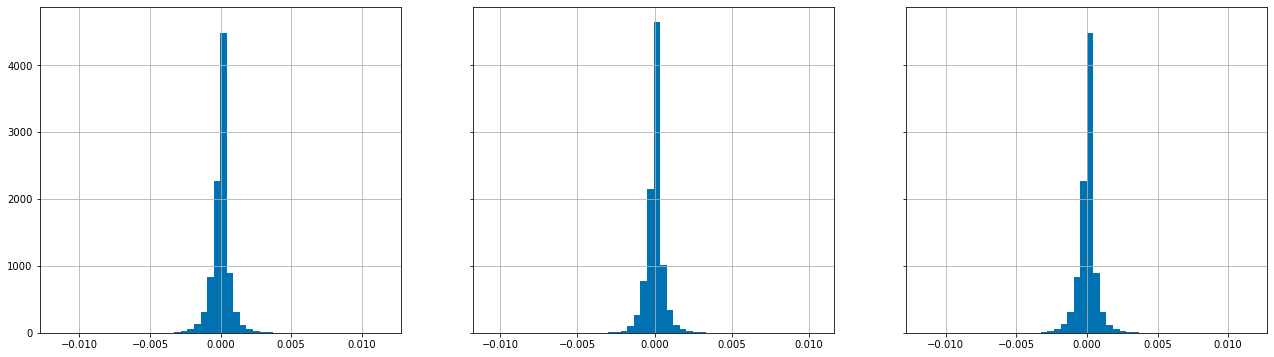

In [160]:
# some histrograms to check the results yet:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(22, 6))
predicted_apple_denorm['close_return'].hist(ax=ax[0], bins=50)
predicted_apple_denorm['predicted_return'].hist(ax=ax[1], bins=50)
predicted_apple_denorm['baseline_return'].hist(ax=ax[2], bins=50)

Histogram in the predicted returns is narrower than the other two, meaning a shorter variance on those results.

To have a final desition about this methodology let's do the same exercise for 5 minutes and 30 minutes periods.

In [161]:
# Some check to our data parameters for 5 minutes (resulting of 
# some value iterations)
globalpar['test5']

{'data': {'ticker': 'AAPL', 'interval': '5min', 'minutes': 5, 'sma_range': 24},
 'structure': {'training_size': 0.8,
  'test_size': 0.2,
  'total_size': 9600,
  'sequence_size': 24,
  'batch_size': 64,
  'input_size': 4,
  'weight_decay': 0.0},
 'training': {'sequence_size': 24,
  'batch_size': 64,
  'model_input_size': 4,
  'model_lstm_layers': 3,
  'model_lstm_size': 128,
  'model_dropout': 0.3,
  'model_output': 1,
  'epochs': 300,
  'optimizer': 'Adam',
  'lrs': [0.005, 0.001],
  'lr_change': True,
  'epochs_change': 220,
  'weight_decay': 0.0}}

In [246]:
# Let's do a test of the LSTM without initializing the weights for 5 minutes 
# period without the initialization and a size of 9600 rows (50 trading days):
train_X, train_y, test_X, test_y = final_array(apple_set_5min, 
                                               globalpar['test5']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y, 
                                              globalpar['test5']['training'], 
                                              init_wgs=False)

final train X shape: (7680, 24, 4), train y shape: (7680,)
final test X shape: (1920, 24, 4), test y shape: (1920,)
torch.Size([7680, 24, 4]) torch.Size([7680]) torch.Size([1920, 24, 4]) torch.Size([1920])
Optimizer: Adam, Leaning rate: 0.005
Epoch[10/300] | loss train:0.00161990, test:0.00003493, lr: 0.005
Epoch[20/300] | loss train:0.00089761, test:0.00000943, lr: 0.005
Epoch[30/300] | loss train:0.00045392, test:0.00001054, lr: 0.005
Epoch[40/300] | loss train:0.00015307, test:0.00000643, lr: 0.005
Epoch[50/300] | loss train:0.00006344, test:0.00000523, lr: 0.005
Epoch[60/300] | loss train:0.00005061, test:0.00000769, lr: 0.005
Epoch[70/300] | loss train:0.00004953, test:0.00000382, lr: 0.005
Epoch[80/300] | loss train:0.00006209, test:0.00000270, lr: 0.005
Epoch[90/300] | loss train:0.00005251, test:0.00000757, lr: 0.005
Epoch[100/300] | loss train:0.00005429, test:0.00000395, lr: 0.005
Epoch[110/300] | loss train:0.00005188, test:0.00000538, lr: 0.005
Epoch[120/300] | loss train:0

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

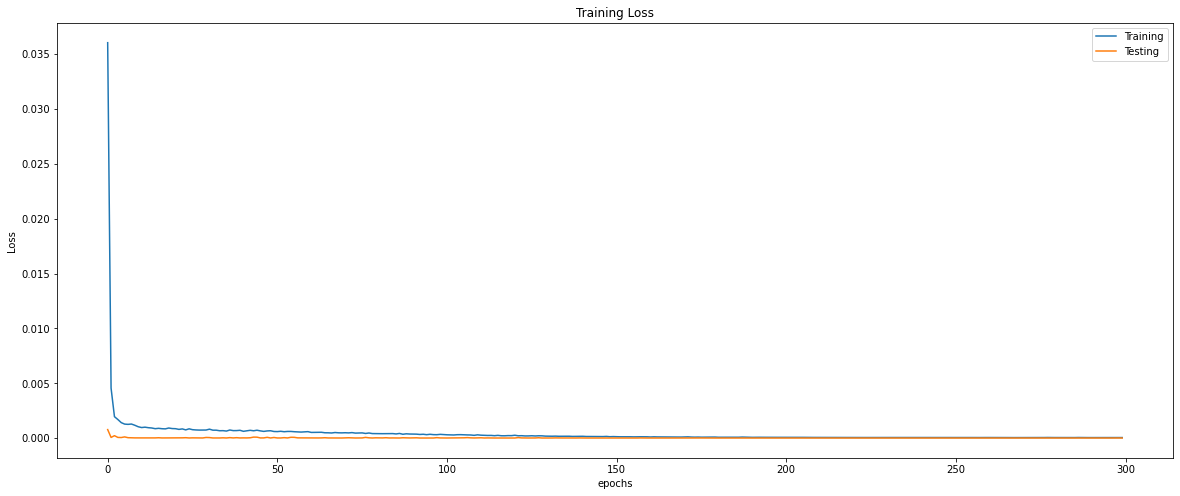

In [250]:
# Plotting results
graph_5min = pd.DataFrame({'Training': loss_train, 'Testing' : loss_test})
graph_5min.loc[:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', 
                       ylabel='Loss')

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

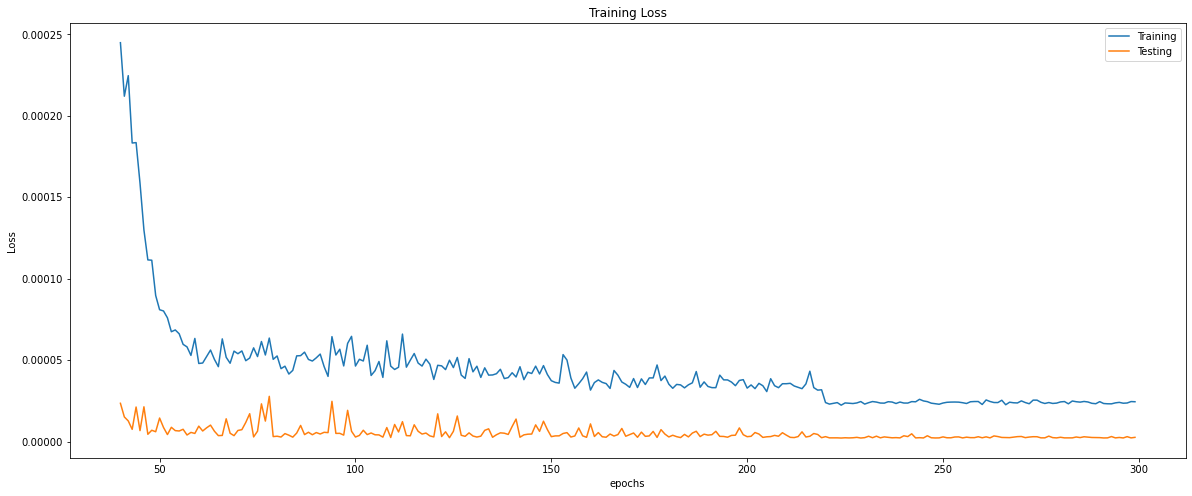

In [212]:
# Closer
graph_5min.loc[40:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', 
                         ylabel='Loss')

In [162]:
# Saving and reloading the model:
saving_model(model, 'aapl_predicting_model_5minute')

model_apple_5min = loading_model('aapl_predicting_model_5minute')

In [163]:
# Now preparing the data
x_to_predict, y_to_predict = data_to_predict(apple_set_5min, 
                                             globalpar['test5']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(9577, 24, 4) (9577,)


In [164]:
# Predicting then
predicted_apple_5 = predicted_df(model_apple_5min, x_to_predict, y_to_predict)
predicted_apple_5.tail(10)

close  close_predicted
9567  0.751605         0.751239
9568  0.750043         0.753168
9569  0.748574         0.751855
9570  0.749217         0.750545
9571  0.749676         0.751015
9572  0.750411         0.751375
9573  0.750411         0.752055
9574  0.750870         0.752117
9575  0.750870         0.752571
9576  0.751788         0.752590

In [165]:
# Now let's denormalize the data
predicted_apple_denorm_5 = predicted_apple_5.copy()

predicted_apple_denorm_5['close'] = de_normalize(predicted_apple_5['close'], 
                                                 closescaler_5)
predicted_apple_denorm_5['close_predicted'] = de_normalize(\
                            predicted_apple_5['close_predicted'], closescaler_5)
predicted_apple_denorm_5

close  close_predicted
0     166.270002       166.573656
1     166.390002       166.379955
2     166.220003       166.487345
3     165.939999       166.337543
4     166.100003       166.078670
...          ...              ...
9572  155.950000       156.054983
9573  155.950000       156.129085
9574  155.999999       156.135789
9575  155.999999       156.185237
9576  156.099997       156.187340

[9577 rows x 2 columns]

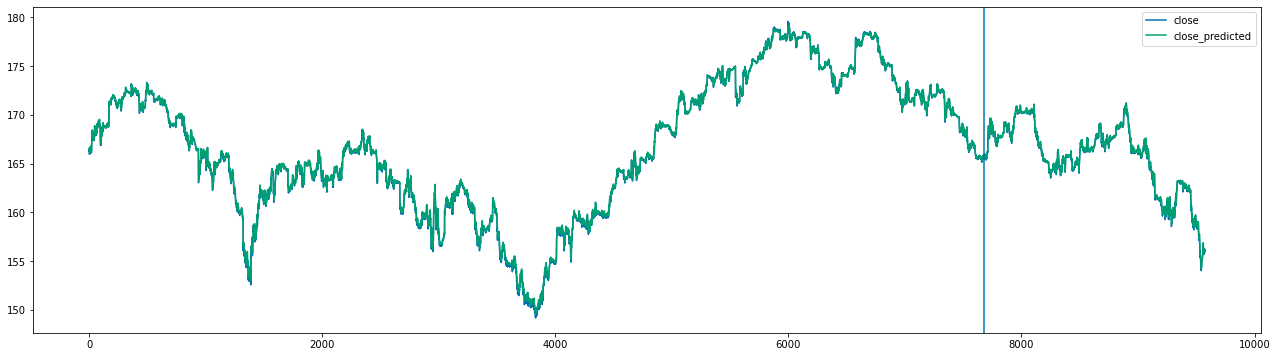

In [166]:
# Let's have a look to the prices graphically
predicted_apple_denorm_5[:].plot(figsize=(22,6))
plt.axvline(x=7680)
# The vertical blue line denotes the mid point between training and 
# testing set

<AxesSubplot:>

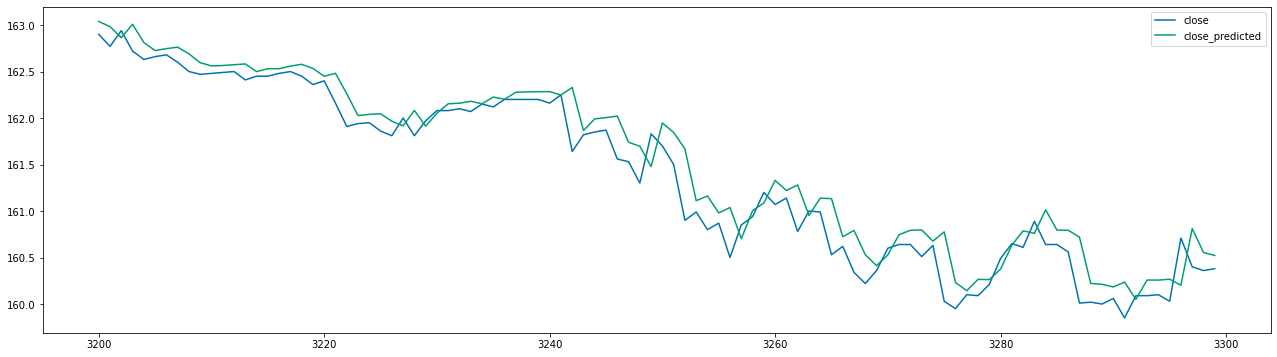

In [167]:
# Closer
predicted_apple_denorm_5[3200:3300].plot(figsize=(22,6))

<AxesSubplot:>

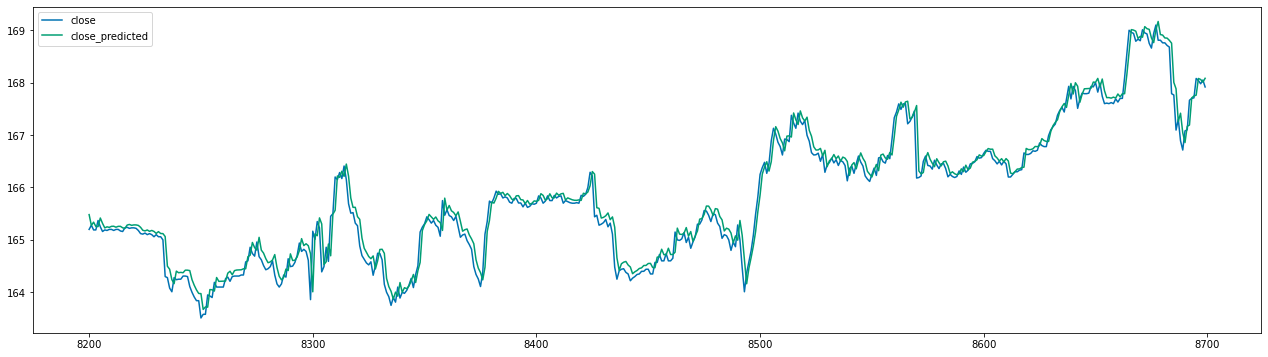

In [168]:
# And a closer look to the testing area
predicted_apple_denorm_5[8200:8700].plot(figsize=(22,6))

<AxesSubplot:>

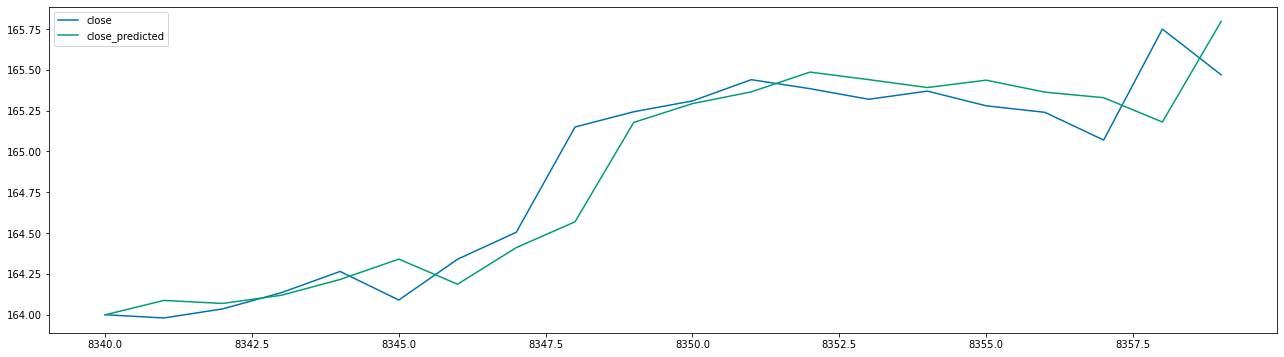

In [169]:
predicted_apple_denorm_5[8340:8360].plot(figsize=(22,6))

In [170]:
# First the baseline
predicted_apple_denorm_5['baseline'] = predicted_apple_denorm_5['close'].\
                                                                shift(1)
predicted_apple_denorm_5

close  close_predicted    baseline
0     166.270002       166.573656         NaN
1     166.390002       166.379955  166.270002
2     166.220003       166.487345  166.390002
3     165.939999       166.337543  166.220003
4     166.100003       166.078670  165.939999
...          ...              ...         ...
9572  155.950000       156.054983  155.869998
9573  155.950000       156.129085  155.950000
9574  155.999999       156.135789  155.950000
9575  155.999999       156.185237  155.999999
9576  156.099997       156.187340  155.999999

[9577 rows x 3 columns]

In [171]:
# Finally the accuracy for 5 minutes
predicted_apple_denorm_5 = check_accuracy(predicted_apple_denorm_5)

Accuracy on training set:
Pred/Close: 0.4725848563968668
Persist/Close: 0.47741514360313314
Accuracy on testing set:
Pred/Close: 0.49164926931106473
Persist/Close: 0.4989561586638831


In [172]:
# Some check to our data parameters for 30 min (resulting of some value 
# iterations)
globalpar['test30']

{'data': {'ticker': 'AAPL',
  'interval': '30min',
  'minutes': 30,
  'sma_range': 32},
 'structure': {'training_size': 0.8,
  'test_size': 0.2,
  'total_size': 4800,
  'sequence_size': 32,
  'batch_size': 64,
  'input_size': 4,
  'weight_decay': 0.0},
 'training': {'sequence_size': 32,
  'batch_size': 64,
  'model_input_size': 4,
  'model_lstm_layers': 3,
  'model_lstm_size': 128,
  'model_dropout': 0.3,
  'model_output': 1,
  'epochs': 300,
  'optimizer': 'Adam',
  'lrs': [0.001, 0.0005],
  'lr_change': True,
  'epochs_change': 220,
  'weight_decay': 0.0}}

In [247]:
# Let's do a test of the LSTM without initializing the weights for 30 minutes 
# period without the initialization and a smaller size of 4800 rows (150 
# trading days):
train_X, train_y, test_X, test_y = final_array(apple_set_30min, 
                                               globalpar['test30']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y, 
                                              globalpar['test30']['training'], 
                                              init_wgs=False)

final train X shape: (3840, 32, 4), train y shape: (3840,)
final test X shape: (960, 32, 4), test y shape: (960,)
torch.Size([3840, 32, 4]) torch.Size([3840]) torch.Size([960, 32, 4]) torch.Size([960])
Optimizer: Adam, Leaning rate: 0.001
Epoch[10/300] | loss train:0.00108885, test:0.00005097, lr: 0.001
Epoch[20/300] | loss train:0.00083511, test:0.00006917, lr: 0.001
Epoch[30/300] | loss train:0.00079131, test:0.00004884, lr: 0.001
Epoch[40/300] | loss train:0.00069734, test:0.00004425, lr: 0.001
Epoch[50/300] | loss train:0.00063765, test:0.00001269, lr: 0.001
Epoch[60/300] | loss train:0.00063007, test:0.00001725, lr: 0.001
Epoch[70/300] | loss train:0.00051138, test:0.00001999, lr: 0.001
Epoch[80/300] | loss train:0.00042750, test:0.00001783, lr: 0.001
Epoch[90/300] | loss train:0.00036396, test:0.00001053, lr: 0.001
Epoch[100/300] | loss train:0.00033286, test:0.00001840, lr: 0.001
Epoch[110/300] | loss train:0.00028588, test:0.00000978, lr: 0.001
Epoch[120/300] | loss train:0.000

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

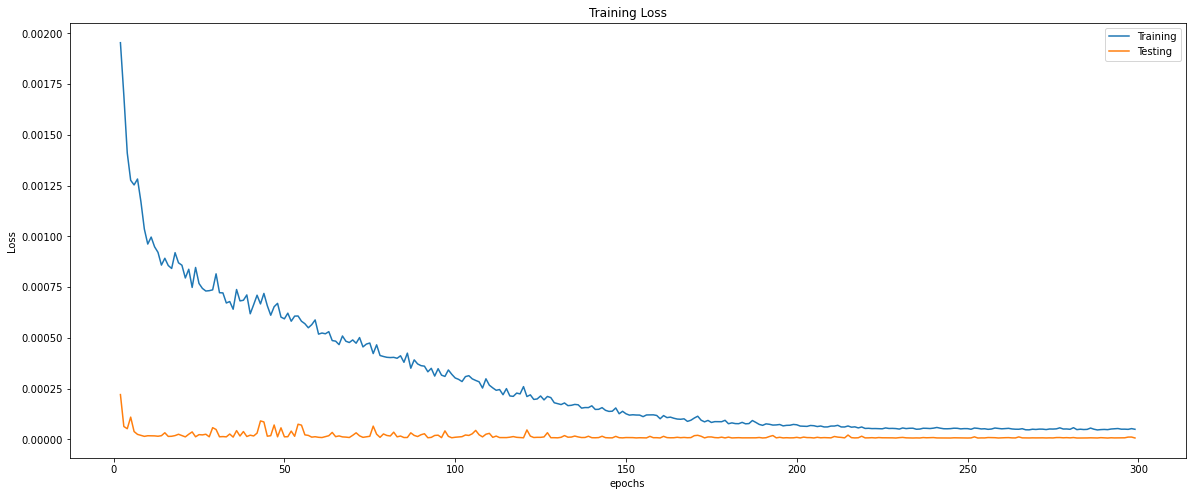

In [225]:
# Plotting results
graph_30min = pd.DataFrame({'Training': loss_train, 'Testing' : loss_test})
graph_30min.loc[2:].plot(figsize=(20,8), title='Training Loss', xlabel='epochs', 
                         ylabel='Loss')

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

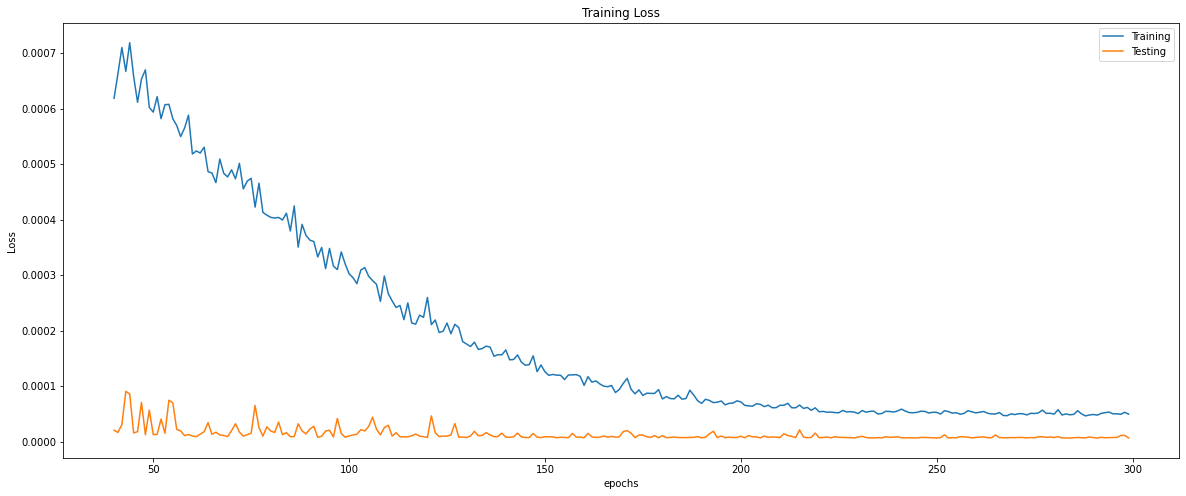

In [226]:
# Closer
graph_30min.loc[40:].plot(figsize=(20,8), title='Training Loss',xlabel='epochs', 
                          ylabel='Loss')

In [173]:
# Saving and reloading the model:
saving_model(model, 'aapl_predicting_model_30minute')

model_apple_30min = loading_model('aapl_predicting_model_30minute')

In [174]:
# Now preparing the data
x_to_predict, y_to_predict = data_to_predict(apple_set_30min, 
                                             globalpar['test30']['structure'])
print(x_to_predict.shape, y_to_predict.shape)

(4769, 32, 4) (4769,)


In [175]:
# Predicting then
predicted_apple_30 = predicted_df(model_apple_30min, x_to_predict, y_to_predict)
predicted_apple_30.tail(10)

close  close_predicted
4759  0.777932         0.777721
4760  0.763689         0.779127
4761  0.757900         0.766074
4762  0.745310         0.760100
4763  0.734283         0.752776
4764  0.741175         0.737571
4765  0.745862         0.740879
4766  0.758727         0.745604
4767  0.748527         0.756051
4768  0.750089         0.748193

In [176]:
# Now let's denormalize the data
predicted_apple_denorm_30 = predicted_apple_30.copy()
predicted_apple_denorm_30['close'] = de_normalize(predicted_apple_30['close'], 
                                                  closescaler_30)
predicted_apple_denorm_30['close_predicted'] = de_normalize(
                        predicted_apple_30['close_predicted'], closescaler_30)
predicted_apple_denorm_30

close  close_predicted
0     145.731817       145.605954
1     145.851491       145.627917
2     146.569532       145.725350
3     146.808875       146.152980
4     147.038247       146.484326
...          ...              ...
4764  154.900001       154.507793
4765  155.410002       154.867802
4766  156.810097       155.381994
4767  155.699997       156.518811
4768  155.870000       155.663693

[4769 rows x 2 columns]

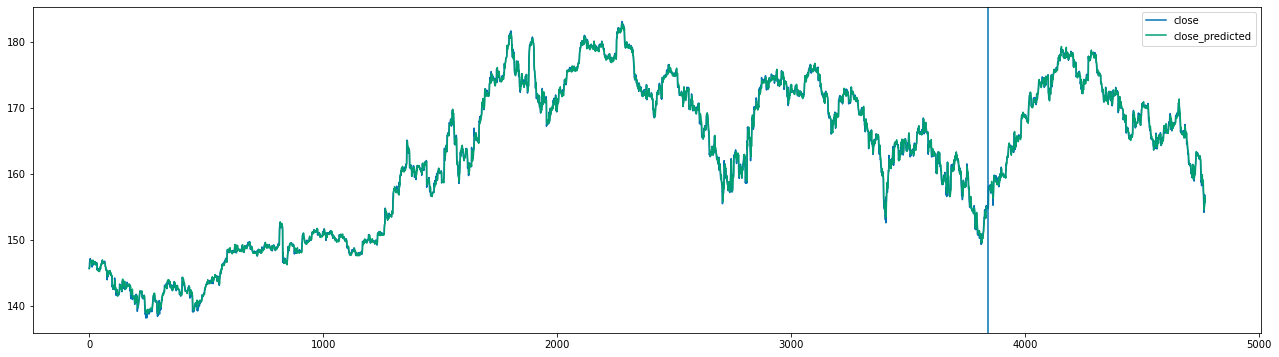

In [177]:
# Let's have a look to the prices graphically
predicted_apple_denorm_30[:].plot(figsize=(22,6))
plt.axvline(x=3840)
# The vertical blue line denotes the mid point between training and testing set

<AxesSubplot:>

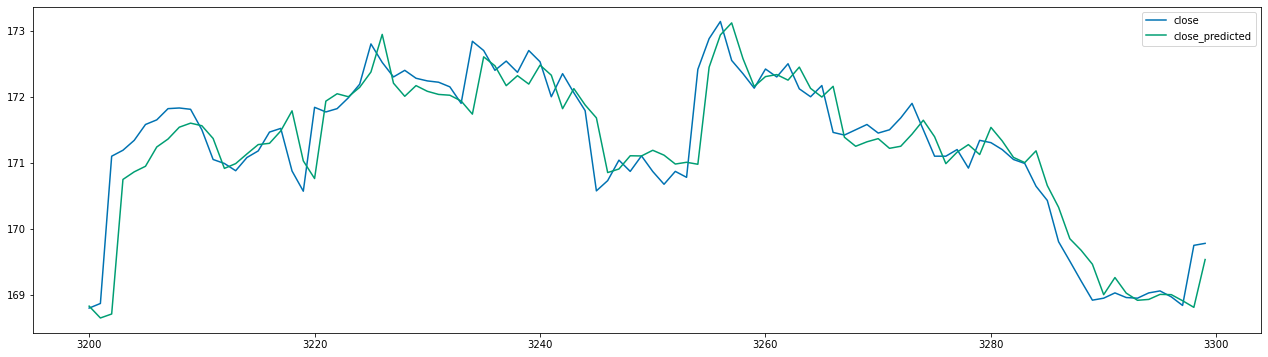

In [178]:
# Closer
predicted_apple_denorm_30[3200:3300].plot(figsize=(22,6))

<AxesSubplot:>

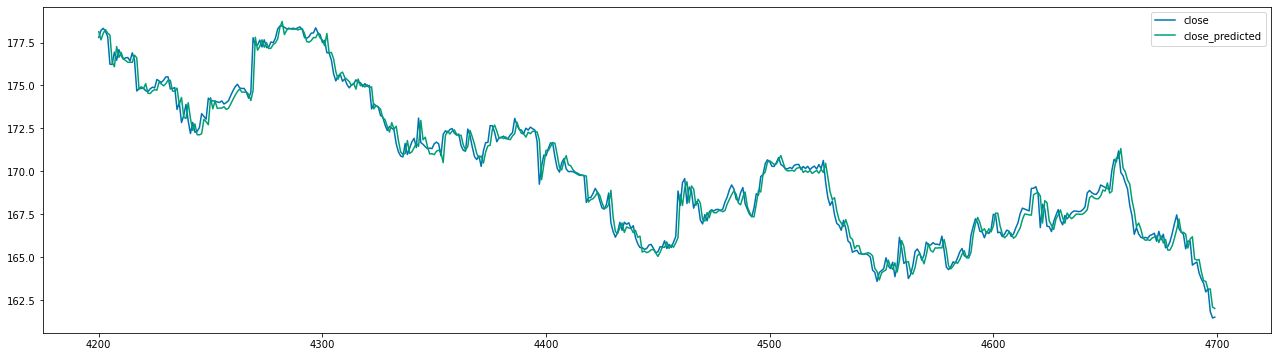

In [179]:
# And a closer look to the testing area
predicted_apple_denorm_30[4200:4700].plot(figsize=(22,6))

<AxesSubplot:>

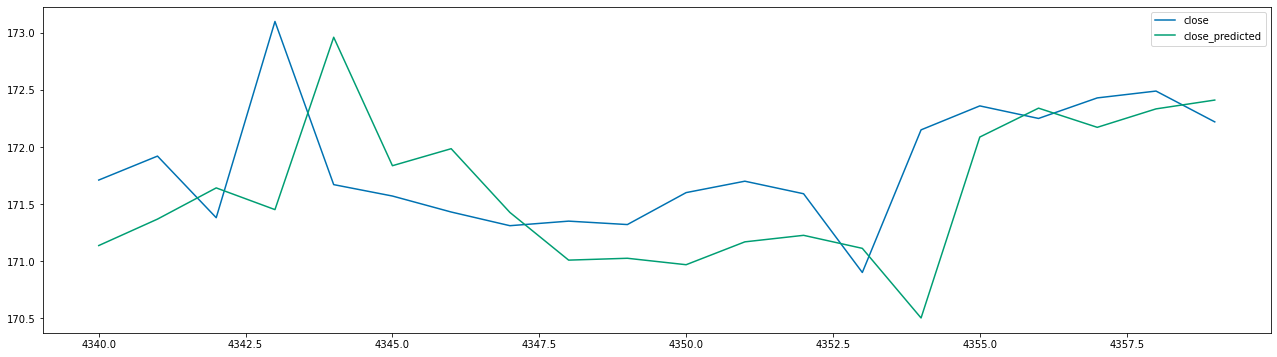

In [180]:
predicted_apple_denorm_30[4340:4360].plot(figsize=(22,6))

In [181]:
# First the baseline
predicted_apple_denorm_30['baseline'] = predicted_apple_denorm_30['close'].\
                                                                    shift(1)
predicted_apple_denorm_30

close  close_predicted    baseline
0     145.731817       145.605954         NaN
1     145.851491       145.627917  145.731817
2     146.569532       145.725350  145.851491
3     146.808875       146.152980  146.569532
4     147.038247       146.484326  146.808875
...          ...              ...         ...
4764  154.900001       154.507793  154.150001
4765  155.410002       154.867802  154.900001
4766  156.810097       155.381994  155.410002
4767  155.699997       156.518811  156.810097
4768  155.870000       155.663693  155.699997

[4769 rows x 3 columns]

In [182]:
predicted_apple_denorm_30 = check_accuracy(predicted_apple_denorm_30)

Accuracy on training set:
Pred/Close: 0.49632931305715783
Persist/Close: 0.480859989512323
Accuracy on testing set:
Pred/Close: 0.5041928721174004
Persist/Close: 0.4968553459119497


Well, this model is not working at all. The baseline performance has better results than the one predicted in some cases, and generally the accuracy, just for ups and down, is less than 50%.

This model is representing a Random Walk, a time series where the next value is always a representantion of the step before plus a white noise, where a white noise is a random number picked from a normal distribution with a mean of zero.


In [183]:
#########1#########2#########3#########4#########5#########6#########7#########8
###                   THIRD PART: LOOKING FOR STATIONARITY                  ###8
#########1#########2#########3#########4#########5#########6#########7#########8

This kind of statistical model occurs when the time series you are trying to predict is non-stationary, that means that the values of the series change in time, what implies that the variance and the mean change in time.

Theorically what this says is that if these values change in time, the values from the past turn irrelevant and doesn't help to teach the model or the model doesn't have relevant information to learn.

One way we have to check if this is checking for the mean and the variance in splitted sets. I mean, split the complete series in two parts and check for those values. If we check the plot for the close variable we can see graphically that the mean will be different.

<AxesSubplot:>

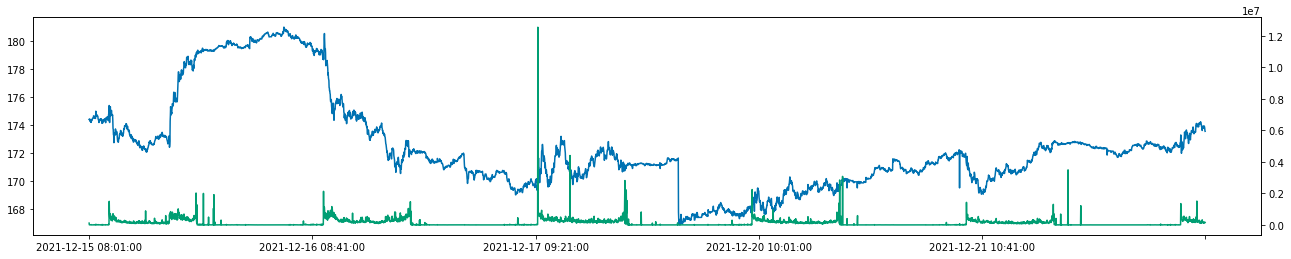

In [184]:
apple_raw_1min[390000:395000]['close'].plot(figsize=(22,4))
apple_raw_1min[390000:395000]['volume'].plot(figsize=(22,4), secondary_y=True)

Let's do a quick test over the close price data:

In [185]:
a1, a2 = apple_raw_1min[:240000]['close'], apple_raw_1min[240000:]['close']
print('a1 mean: {},  a2 mean: {}'.format(a1.mean(), a2.mean()))
print('a1 var: {},  a2 var: {}'.format(a1.var(ddof=0), a2.var(ddof=0)))


a1 mean: 113.90195264481036,  a2 mean: 153.28047533502956
a1 var: 301.8004294444194,  a2 var: 254.4806343088437


As you can see this kind of time-series perfectly shows the non-stationarity theory. The mean and the variance change in time

Other characteristic in non-stationarity time-series is the presence of seasonality, or a repeated behaviour in a fix number of time-steps. In the same plot showed above you can see the seasonality of the volume data. How the graph presents a repeated behavior during the same cycles.

But let's try another way to check for stationarity. The most famous way its the statistical analysis called: The Augmented Dickey-Fuller Test. Where the null-hyphotesis says that the time-series is non-stationary and the alternative-hyphotesis is that it is stationary. So, if we have a result of p-value less than 0.1 or better 0.05, we can reject the null-hyphotesys and then we can assure that our time-series is stationary.

Let's do the test with this 1 minutes time-series:


In [186]:
from statsmodels.tsa.stattools import adfuller

def checking_adf(data, size, maxlags=60):
    '''
    This function will check for the Augmented Dickey-Fuller Test and will 
    return a dataframe with the p-value, ADF value, the 1%-5%-10% values and 
    our final analysis if it is a stationary data or not.
    
    Function Parameters:
        * Required:  data: dataframe which columns will be analyse.
        
        * Required:  size: The size of the data or number of rows to analyse.
        
        * maxlags: The maximun number of time-steps to analyse. (default=60)
        
    Returns:
        A DataFrame with all the data related.
    '''
    # A dictionary to save the results
    adf = {}
    # a loop to check every columns adf test
    for col in data.columns:
        adf[col] = adfuller(data[-size:][col], maxlag=maxlags, autolag=None)
    adf_df = pd.DataFrame(adf).transpose()
    
    # Now just distributing the results
    adf_df['1%'] = adf_df.loc[:,4].apply(lambda x: x['1%'])
    adf_df['5%'] = adf_df.loc[:,4].apply(lambda x: x['5%'])
    adf_df['10%'] = adf_df.loc[:,4].apply(lambda x: x['10%'])
    adf_df.drop(columns=[3,4], inplace=True)
    adf_df.rename(columns={0:'ADF', 1: 'p-value', 2:'n_lags'}, inplace=True)
    # analysing results and checking if we can reject the null
    adf_df['stationary'] = adf_df.loc[:,'ADF'] < adf_df.loc[:,'5%']
    
    return(adf_df)

In [187]:
checking_adf(apple_mom_1min, globalpar['test1']['structure']['total_size'], 
                             globalpar['test1']['structure']['sequence_size'])

ADF   p-value n_lags        1%        5%       10%  stationary
market    -5.06172  0.000017     30 -3.431034 -2.861842 -2.566931        True
close    -0.133397  0.946009     30 -3.431034 -2.861842 -2.566931       False
volume   -8.285826       0.0     30 -3.431034 -2.861842 -2.566931        True
sma       1.089391  0.995125     30 -3.431034 -2.861842 -2.566931       False
momentum -5.661941  0.000001     30 -3.431034 -2.861842 -2.566931        True

From the ADF test we can interpret that 'close' is a non-stationary time-series, in contrast, volume and the market has enough evidence to reject the null. But volume data, as we said before, show clearly a seasonality, another non-stationarity characteristic.


Another test we can do to test the data for non-stationarity is the autocorrelation plot.
In a stationarity time series, it shouldn't have correlation between any data in time and its predecesors, or at least below a confidence level of 0,1 or a better 0.05.

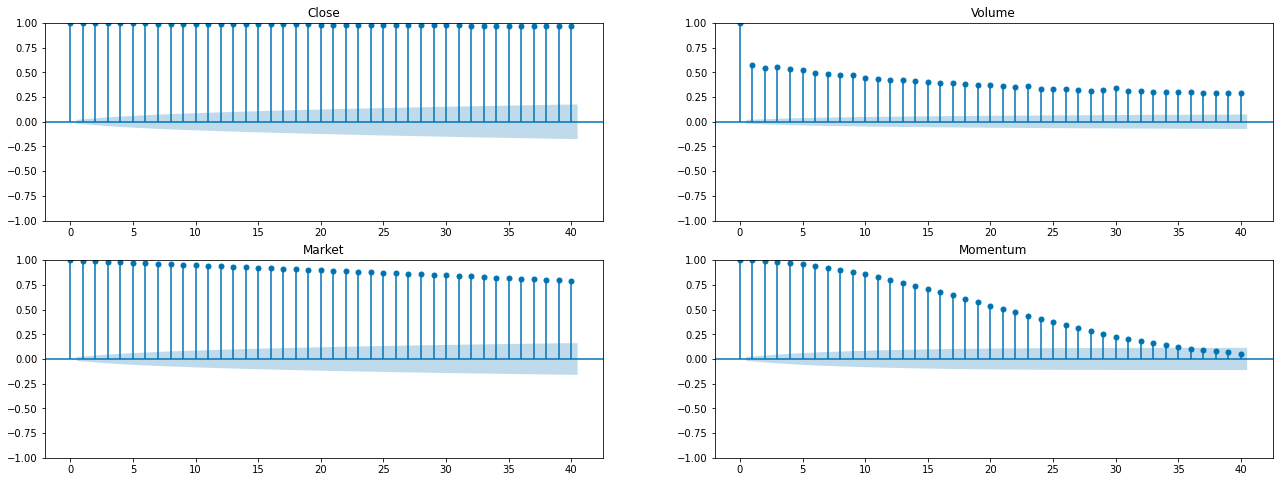

In [240]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# For the data we are training only:
size = globalpar['test1']['structure']['total_size']

fig, ax = plt.subplots(2,2,figsize=(22,8))
plot_acf(apple_mom_1min[-size:]['close'], ax=ax[0,0])
plot_acf(apple_mom_1min[-size:]['volume'], ax=ax[0,1])
plot_acf(apple_mom_1min[-size:]['market'], ax=ax[1,0])
plot_acf(apple_mom_1min[-size:]['momentum'], ax=ax[1,1])

ax[0,0].set_title('Close')
ax[0,1].set_title('Volume')
ax[1,0].set_title('Market')
ax[1,1].set_title('Momentum')

plt.savefig('Autocorrelation_1min_nonsta.png', bbox_inches='tight')

Ok, definitely non-stationarity for close and volume. What can we do then?

One very common practice to fix this issue is to calculate the difference between the t value and the t-1 value and test again for stationarity. If the problem persist repeat the formula with the new set of data.

But the quantitative analysts in the stock market prefers to use the log of the returns, meaning the log of t - (t-1) divided by (t-1), or better the log return that is the log of t / t-1.

Look in the previous ADF-table how 'momentum' that comes from the 'sma' data is inside our alternative hypothesis or stationarity. When we calculate the 'momentum' or return we eliminate the non-stationarity component.


We will try with this approach to guarantee a stationary data to train:

    1. We'll calculate the log return of the close price or log(t / t-1).
    2. We'll deseasonilize the volume data by the difference method with t-x, where x is the size of the cycle, in our case the volume repeat its form every 960 minutes, every time the market opens again.
    3. We'll introduce a new signal instead of momentum: RSI or Relative Strenght Index, a very popular trading momentum that results from the next formula: RSI = 100 - 100/(1 + RS) where RS = average gain/average loss. (You can check more about RSI here: https://www.omnicalculator.com/finance/rsi)
    
    

In [196]:
# Let's do first a calculation for RSI:
def rsi_momentum(data, steps=30, diff_level=0, unit=True):
    '''
    Function that calculates the rsi of the received data and adds the
    possibility to send back the first level of difference, just in case
    we don't achieve the stationarity in the resulting data.
    
    Function parameters:
        * Required: data: data with the specified column in it
        
        * steps: the number of steps to calculate the RSI.(default=30)
        
        * diff_level: 0 or 1: in case you want to apply an extra difference
                              calculation, for stationarity purposes.(default=0)
        * unit: True or False: if you want the normalized rsi or the original
                               one based on 0-100
                              
    Return
        A serie with the RSI calculated.
    '''
    # just applying the RSI formula
    data_diff = data-data.shift(1)
    data_gains = abs(data_diff) * (data_diff >= 0).astype(int)
    data_losses = abs(data_diff) * (data_diff < 0).astype(int)
    data_rs = data_gains.rolling(steps).mean()/data_losses.rolling(steps).mean()        

    # Originally RSI is calculated between 0-100, we'll calculate it between 0-1
    if unit:
        data_rsi = (1 - 1/(1 + data_rs))
    else:
        data_rsi = (100 - 100/(1 + data_rs))
    # To increase a level of stationarity we add the possibility to send back
    # the first level of difference meaning t and t-1
    if diff_level > 0:
        data_rsi = data_rsi - data_rsi.shift(diff_level)
    
    # There is a possibility to have NaN values in the middle of the data, then
    # we will have to fill those NaN values with the non NaN value just before.
    return data_rsi.fillna(method='ffill')

In [199]:
# We then start working again with the original data without
# SMA and momentum
apple_final = apple_pre_1min.copy()
apple_final.drop(columns=['sma', 'momentum'], inplace=True)
apple_final

market       close  volume
2020-05-07 04:01:00    -0.1   74.749314  3492.0
2020-05-07 04:02:00    -0.1   74.761645  1616.0
2020-05-07 04:03:00    -0.1   74.761645     0.0
2020-05-07 04:04:00    -0.1   74.761645     0.0
2020-05-07 04:05:00    -0.1   74.761645  5756.0
...                     ...         ...     ...
2022-04-26 19:56:00     0.1  156.140000  1576.0
2022-04-26 19:57:00     0.1  156.150000  3748.0
2022-04-26 19:58:00     0.1  156.100000  2490.0
2022-04-26 19:59:00     0.1  156.150100  2481.0
2022-04-26 20:00:00     0.1  156.120000  4360.0

[477120 rows x 3 columns]

In [200]:
# Then let's create the 'rsi' column and calculate the adf test
apple_final['rsi'] = rsi_momentum(apple_final['close'], steps=30, diff_level=0, 
                                  unit=True)
checking_adf(apple_final, globalpar['test1']['structure']['total_size'], 
                          globalpar['test1']['structure']['sequence_size'])

ADF   p-value n_lags        1%        5%       10%  stationary
market   -5.06172  0.000017     30 -3.431034 -2.861842 -2.566931        True
close   -0.133397  0.946009     30 -3.431034 -2.861842 -2.566931       False
volume  -8.285826       0.0     30 -3.431034 -2.861842 -2.566931        True
rsi    -11.807247       0.0     30 -3.431034 -2.861842 -2.566931        True

<AxesSubplot:>

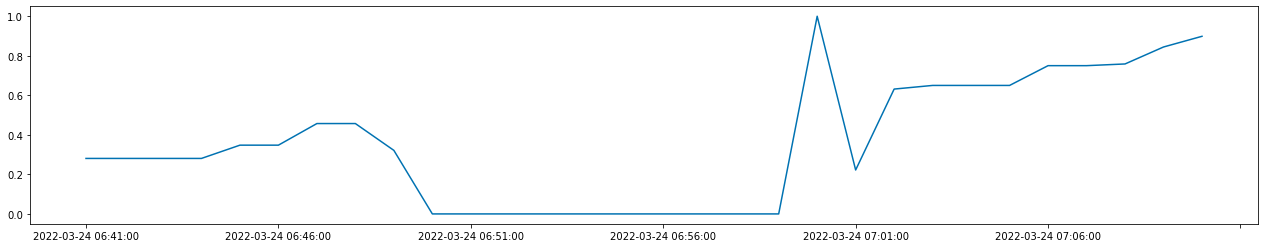

In [201]:
apple_final[-21920:-21890]['rsi'].plot(figsize=(22,4))

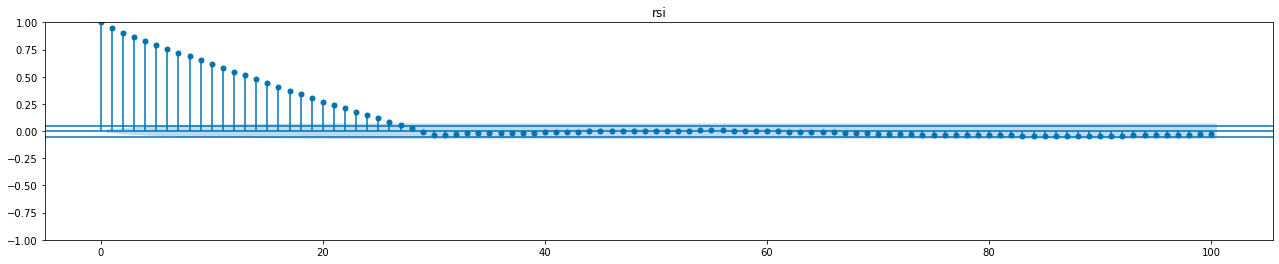

In [202]:
# How the autocorrelation works?
fig, ax = plt.subplots(1,1,figsize=(22,4))
plot_acf(apple_final[-size:]['rsi'], alpha=0.1, lags=100, title='rsi', ax=ax)
# Let's mark this time our confidence intervals.
plt.axhline(y=0.05)
plt.axhline(y=-0.05)

<AxesSubplot:>

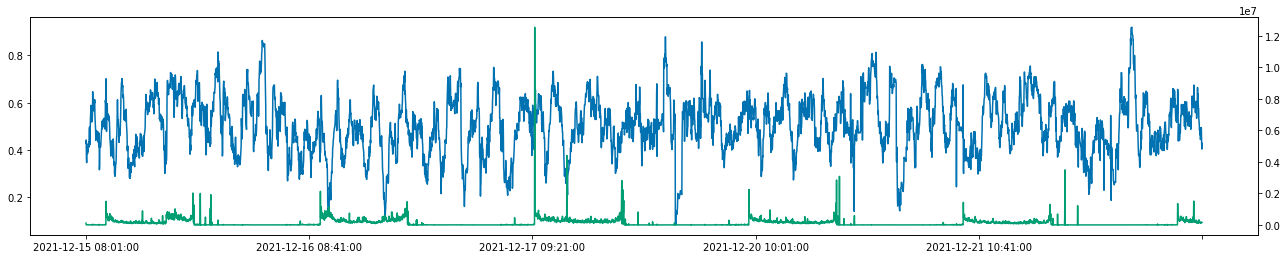

In [203]:
#Let's check about the RSI result data:
apple_final[390000:395000]['rsi'].plot(figsize=(22,4))
apple_final[390000:395000]['volume'].plot(figsize=(22,4), secondary_y=True)

In [204]:
# Let's apply the first difference level to see the results:
apple_final['rsi'] = rsi_momentum(apple_final['close'], 30, 1, True)
checking_adf(apple_final, globalpar['test1']['structure']['total_size'], 
                             globalpar['test1']['structure']['sequence_size'])

ADF   p-value n_lags        1%        5%       10%  stationary
market   -5.06172  0.000017     30 -3.431034 -2.861842 -2.566931        True
close   -0.133397  0.946009     30 -3.431034 -2.861842 -2.566931       False
volume  -8.285826       0.0     30 -3.431034 -2.861842 -2.566931        True
rsi    -28.052256       0.0     30 -3.431034 -2.861842 -2.566931        True

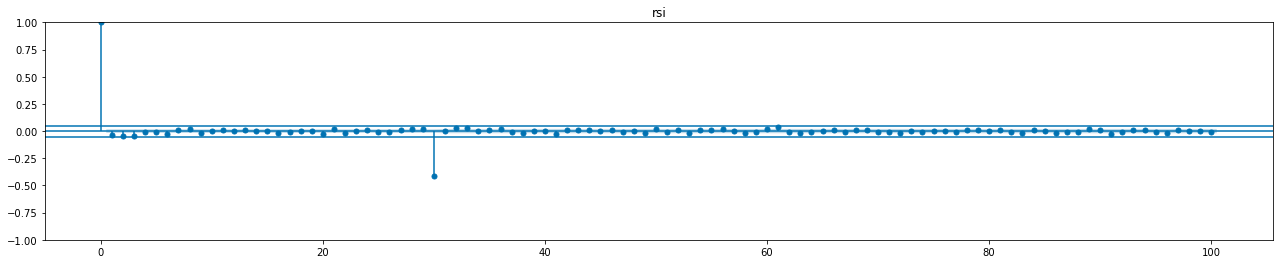

In [205]:
# And what we have with the autocorrelation plot:
fig, ax = plt.subplots(1,1,figsize=(22,4))
plot_acf(apple_final[-size:]['rsi'], alpha=0.1, lags=100, title='rsi', ax=ax)
plt.axhline(y=0.05)
plt.axhline(y=-0.05)

In [206]:
#Now let's do the proper thing with the close price:
def log_return(data):
    '''
    Function that returns the log-return of a time-series
    with a normalized scaling on it.
    
    Function parameters:
    
        *Required: data: the series to calculate
        
    Returns:
        new-data: A serie with the log-returns of the data.
        scaler: the scaler for future purposes.
    '''
    new_data = 10 * np.log(data / data.shift(1))
    # Scale Defining, fitting and transforming to the data
    scaler = StandardScaler()
    new_data = scaler.fit_transform(np.array(new_data).reshape(-1,1))
    
    return new_data, scaler

<AxesSubplot:>

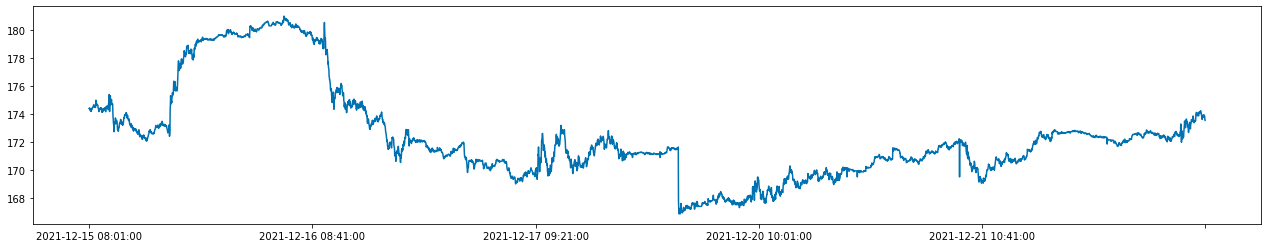

In [207]:
# This is what we have:
apple_final[390000:395000]['close'].plot(figsize=(22,4))

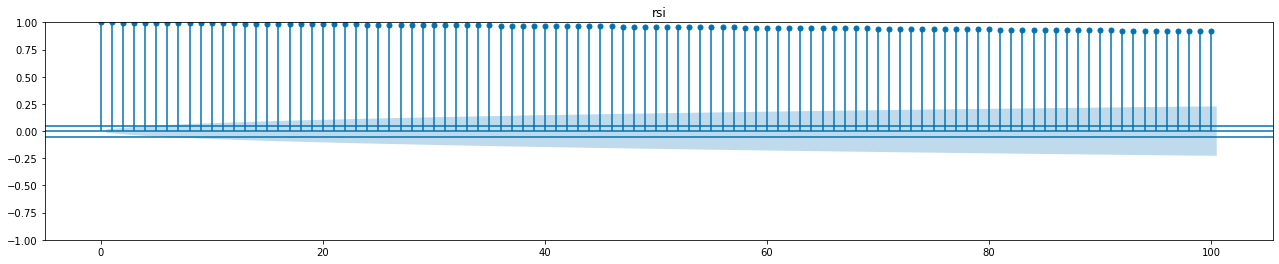

In [208]:
# And the autocorrelation
fig, ax = plt.subplots(1,1,figsize=(22,4))
plot_acf(apple_final[-size:]['close'], alpha=0.1, lags=100, title='rsi', ax=ax)
plt.axhline(y=0.05)
plt.axhline(y=-0.05)

<AxesSubplot:>

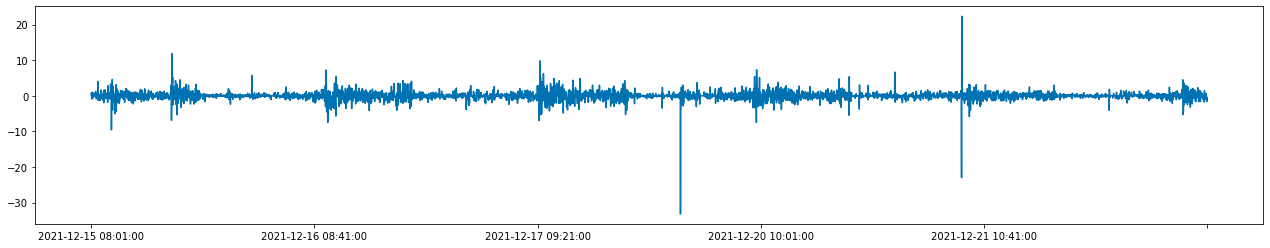

In [209]:
# Now let's see with the log return:
apple_final['close'], close_scaler = log_return(apple_final['close'])
apple_final[390000:395000]['close'].plot(figsize=(22,4))

In [210]:
# Now let's do the adf test and plot the autocorrelation:
checking_adf(apple_final, globalpar['test1']['structure']['total_size'], 
                          globalpar['test1']['structure']['sequence_size'])

ADF   p-value n_lags        1%        5%       10%  stationary
market   -5.06172  0.000017     30 -3.431034 -2.861842 -2.566931        True
close  -18.051515       0.0     30 -3.431034 -2.861842 -2.566931        True
volume  -8.285826       0.0     30 -3.431034 -2.861842 -2.566931        True
rsi    -28.052256       0.0     30 -3.431034 -2.861842 -2.566931        True

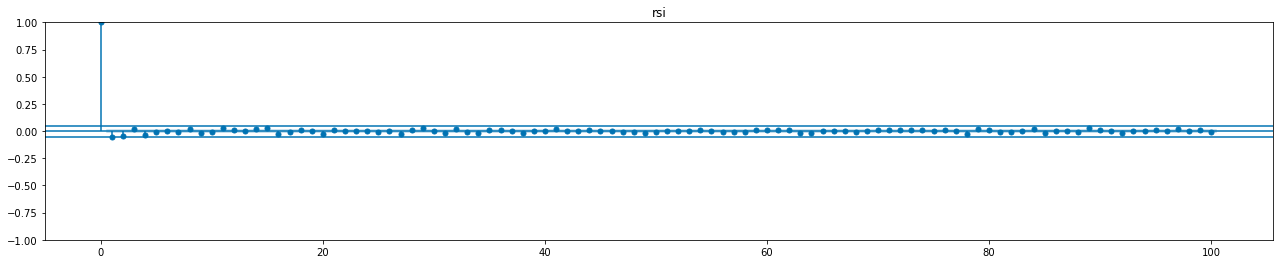

In [211]:
# And our autocorrelation graphic:
fig, ax = plt.subplots(1,1,figsize=(22,4))
plot_acf(apple_final[-size:]['close'], alpha=0.1, lags=100, title='rsi', ax=ax)
plt.axhline(y=0.05)
plt.axhline(y=-0.05)

It is working!.... for now.

In [212]:
# Let's finally deseasonalize the volume and normalize it too.
# Because we have big gaps of values here after deseasonilize the
# data we'll implement the box-cox transformation to have the data
# more normalized and without those big outliers.
# Let's see first how our data is doing and the big values of volume
#data:
apple_final.describe()

market         close        volume            rsi
count  477120.000000  4.771190e+05  4.771200e+05  477089.000000
mean       -0.009271 -1.231008e-15  1.049819e+05      -0.000516
std         0.076427  1.000001e+00  2.217107e+05       0.047542
min        -0.100000 -5.598547e+01  0.000000e+00      -1.000000
25%        -0.100000 -2.811766e-01  8.400000e+02      -0.018421
50%         0.000000 -2.236068e-03  8.080000e+03       0.000000
75%         0.025000  2.903213e-01  1.480920e+05       0.018254
max         0.100000  5.598100e+01  1.798932e+07       0.975000

<AxesSubplot:>

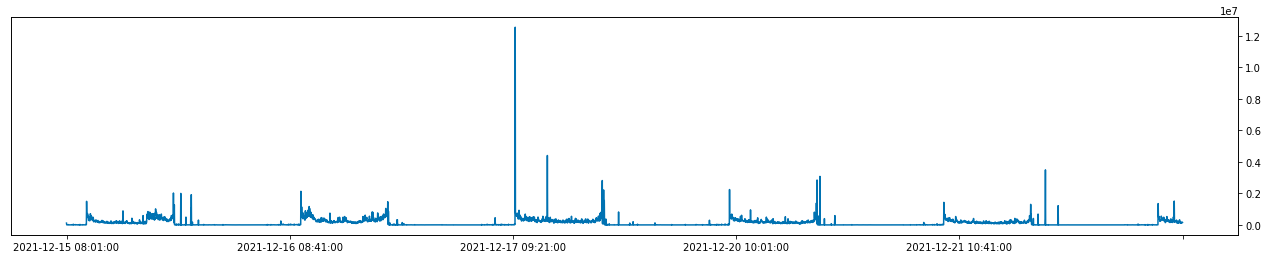

In [213]:
#Function to deseasonalize volume data and apply box-cox
#Let's se again the volume data:
apple_final[390000:395000]['volume'].plot(figsize=(22,4), secondary_y=True)

In [214]:
# Because we can have negative values after a deseasonalization we'll
# use the yeojohnson approach to get a better normalization.
def volume_deseason_yeojohnson(data,first_order_diff=1,second_order_diff=False,
                               doyeo=False, scale=False):
    '''
    Function that transform and desesasonalize the volume data.
    It have the option to apply a second differencing to the data in case
    is required for stationarity purposes, and also the option to apply
    the YeoJohnson transformation for a better normalized data.
    
    Function parameters:
    
        * Required: data: a series data to be transforme, usually volume data
        
        * Required: first_order_diff: the time steps or season period.
        
        * Optional: second_order_diff: True or False: if desired to apply a 
                                        second order differencing.
        * Optional: doyeo: True or False: In order to apply or not the 
                                          Yeo Johnson transformation process.
        * Optional: scaler: True or False: To scale or not the data to 0-1
                                          
    Returns:
    
        The series data transformed and deseasonalized.
    '''
    # First order differencing for deseasonilize:
    new_data = data - data.shift(first_order_diff)
    # Second order differencing (optional):
    if second_order_diff:
        new_data = new_data - new_data.shift(1)
    # The YeoJohnson transformation:
    if doyeo:
        new_data, _ = stats.yeojohnson(new_data.fillna(0))
    # Then scale as requested:
    if scale:
        scaler = StandardScaler()
        new_data = scaler.fit_transform(np.array(new_data).reshape(-1,1))
        
    return new_data
    

In [215]:
# Let's see the volume data after deseasonilization and other options:
apple_final['deseason'] = volume_deseason_yeojohnson(\
                          apple_final['volume'], 960, False, False, False)
apple_final['second_order'] = volume_deseason_yeojohnson(\
                              apple_final['volume'], 960, True, False, False)
apple_final['yeojohnson'] = volume_deseason_yeojohnson(\
                            apple_final['volume'], 960, False, True, False)
apple_final['scaled'] = volume_deseason_yeojohnson(\
                        apple_final['volume'], 960, False, False, True)
checking_adf(apple_final, globalpar['test1']['structure']['total_size'], 
                          globalpar['test1']['structure']['sequence_size'])

ADF   p-value n_lags        1%        5%       10%  \
market         -5.06172  0.000017     30 -3.431034 -2.861842 -2.566931   
close        -18.051515       0.0     30 -3.431034 -2.861842 -2.566931   
volume        -8.285826       0.0     30 -3.431034 -2.861842 -2.566931   
rsi          -28.052256       0.0     30 -3.431034 -2.861842 -2.566931   
deseason      -12.87445       0.0     30 -3.431034 -2.861842 -2.566931   
second_order -29.197575       0.0     30 -3.431034 -2.861842 -2.566931   
yeojohnson   -12.881656       0.0     30 -3.431034 -2.861842 -2.566931   
scaled        -12.87445       0.0     30 -3.431034 -2.861842 -2.566931   

              stationary  
market              True  
close               True  
volume              True  
rsi                 True  
deseason            True  
second_order        True  
yeojohnson          True  
scaled              True

In [216]:
apple_final.describe()

market         close        volume            rsi      deseason  \
count  477120.000000  4.771190e+05  4.771200e+05  477089.000000  4.761600e+05   
mean       -0.009271 -1.231008e-15  1.049819e+05      -0.000516 -4.522945e+01   
std         0.076427  1.000001e+00  2.217107e+05       0.047542  1.983693e+05   
min        -0.100000 -5.598547e+01  0.000000e+00      -1.000000 -1.458825e+07   
25%        -0.100000 -2.811766e-01  8.400000e+02      -0.018421 -6.663000e+03   
50%         0.000000 -2.236068e-03  8.080000e+03       0.000000  0.000000e+00   
75%         0.025000  2.903213e-01  1.480920e+05       0.018254  5.998000e+03   
max         0.100000  5.598100e+01  1.798932e+07       0.975000  1.483471e+07   

       second_order    yeojohnson        scaled  
count  4.761590e+05  4.771200e+05  4.761600e+05  
mean  -1.369291e-02 -8.813297e+02 -2.860230e-16  
std    2.409030e+05  1.981339e+05  1.000001e+00  
min   -1.414848e+07 -1.487755e+07 -7.354074e+01  
25%   -7.728000e+03 -6.667555e+03 -3.336090e-02  
50%    0.000000e+00  0.000000e+00  2.280066e-04  
75%    7.914000e+03  5.890307e+03  3.046458e-02  
max    1.527924e+07  1.454596e+07  7.478361e+01

Text(0.5, 1.0, 'scaled')

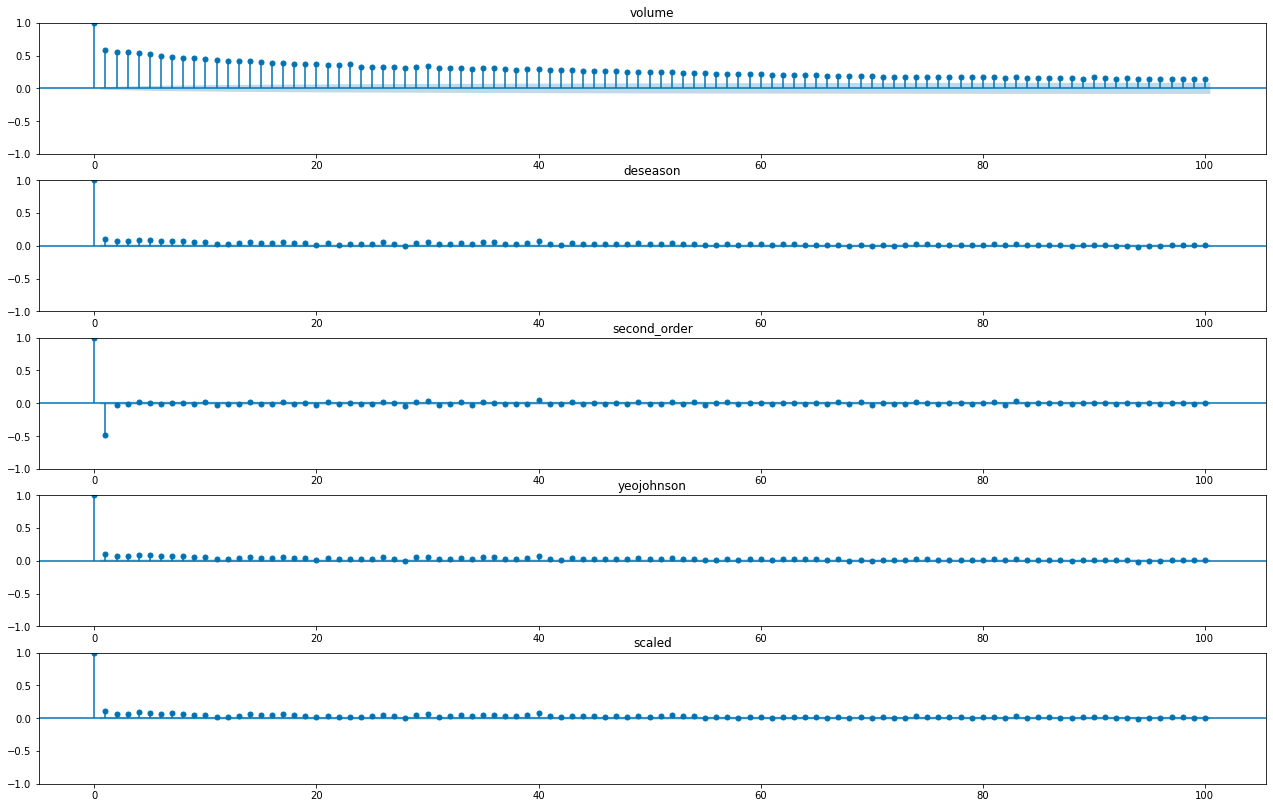

In [219]:
# Now the autocorrelation plots
fig, axf = plt.subplots(5,1,figsize=(22,14), sharex='row')
plot_acf(apple_final[-size:]['volume'], lags=100, ax=axf[0])
plot_acf(apple_final[-size:]['deseason'], lags=100, ax=axf[1])
plot_acf(apple_final[-size:]['second_order'], lags=100, ax=axf[2])
plot_acf(apple_final[-size:]['yeojohnson'], lags=100, ax=axf[3])
plot_acf(apple_final[-size:]['scaled'], lags=100, ax=axf[4])

axf[0].set_title('volume')
axf[1].set_title('deseason')
axf[2].set_title('second_order')
axf[3].set_title('yeojohnson')
axf[4].set_title('scaled')


<AxesSubplot:title={'center':'scaled'}>

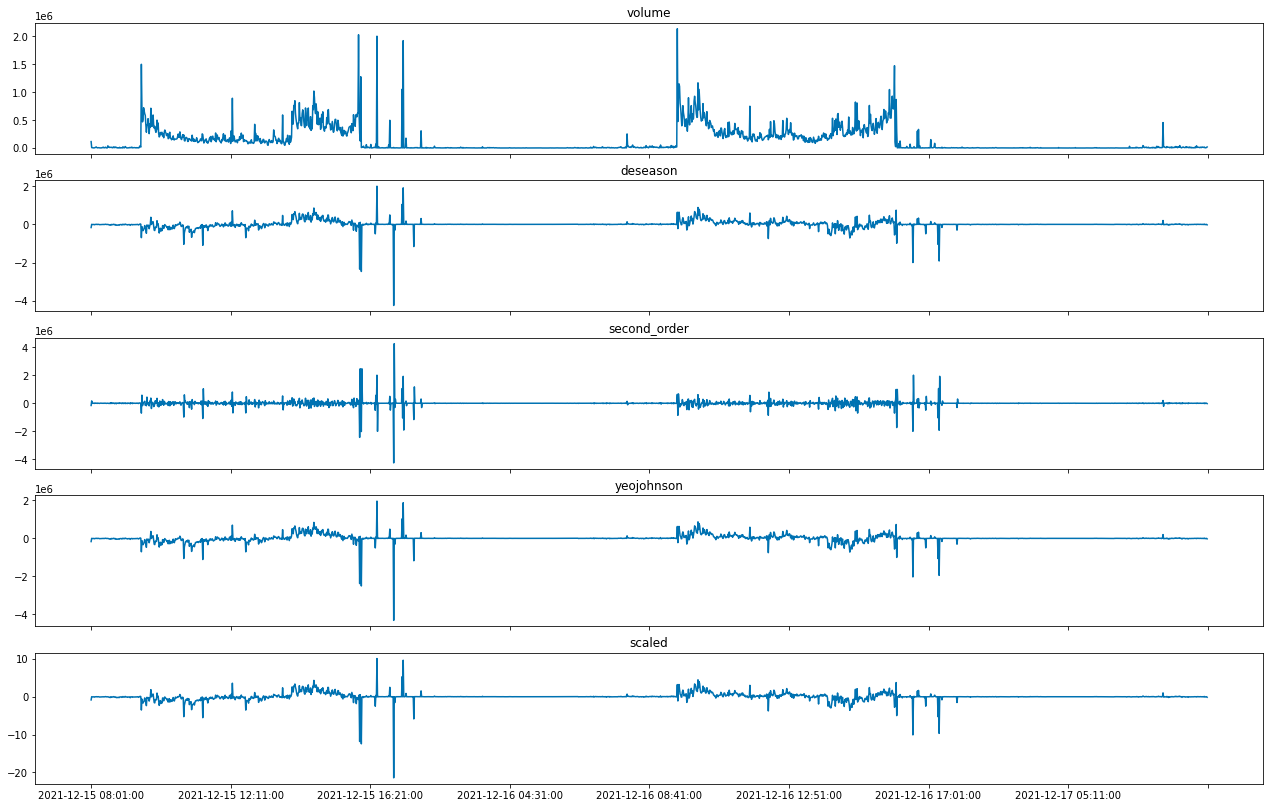

In [220]:
# Let's wathc some of the resulting data
fig, axf = plt.subplots(5,1,figsize=(22,14), sharex=True)
apple_final[390000:392000]['volume'].plot(ax=axf[0], title='volume')
apple_final[390000:392000]['deseason'].plot(ax=axf[1], title='deseason')
apple_final[390000:392000]['second_order'].plot(ax=axf[2], title='second_order')
apple_final[390000:392000]['yeojohnson'].plot(ax=axf[3], title='yeojohnson')
apple_final[390000:392000]['scaled'].plot(ax=axf[4], title='scaled')

All the plots look very nice. We can agree to reject the null hypothesis of non-stationarity in all of them, and the autocorrelation plot look very below of a confidence level of 10% that's good too.
The second order plot looks nicer but is a good practice to avoid more than one level of differencing.
Let's then try again but with the deseason differencing, the Yeo Johnson transforming and the scale simultaneously.

In [221]:
apple_final['deseason_final'] = volume_deseason_yeojohnson(\
                                apple_final['volume'], 960, False, True, True)
apple_final.describe()

market         close        volume            rsi      deseason  \
count  477120.000000  4.771190e+05  4.771200e+05  477089.000000  4.761600e+05   
mean       -0.009271 -1.231008e-15  1.049819e+05      -0.000516 -4.522945e+01   
std         0.076427  1.000001e+00  2.217107e+05       0.047542  1.983693e+05   
min        -0.100000 -5.598547e+01  0.000000e+00      -1.000000 -1.458825e+07   
25%        -0.100000 -2.811766e-01  8.400000e+02      -0.018421 -6.663000e+03   
50%         0.000000 -2.236068e-03  8.080000e+03       0.000000  0.000000e+00   
75%         0.025000  2.903213e-01  1.480920e+05       0.018254  5.998000e+03   
max         0.100000  5.598100e+01  1.798932e+07       0.975000  1.483471e+07   

       second_order    yeojohnson        scaled  deseason_final  
count  4.761590e+05  4.771200e+05  4.761600e+05    4.771200e+05  
mean  -1.369291e-02 -8.813297e+02 -2.860230e-16    8.091186e-16  
std    2.409030e+05  1.981339e+05  1.000001e+00    1.000001e+00  
min   -1.414848e+07 -1.487755e+07 -7.354074e+01   -7.508399e+01  
25%   -7.728000e+03 -6.667555e+03 -3.336090e-02   -2.920364e-02  
50%    0.000000e+00  0.000000e+00  2.280066e-04    4.448157e-03  
75%    7.914000e+03  5.890307e+03  3.046458e-02    3.417711e-02  
max    1.527924e+07  1.454596e+07  7.478361e+01    7.341933e+01

In [222]:
checking_adf(apple_final, globalpar['test1']['structure']['total_size'], 
                          globalpar['test1']['structure']['sequence_size'])

ADF   p-value n_lags        1%        5%       10%  \
market           -5.06172  0.000017     30 -3.431034 -2.861842 -2.566931   
close          -18.051515       0.0     30 -3.431034 -2.861842 -2.566931   
volume          -8.285826       0.0     30 -3.431034 -2.861842 -2.566931   
rsi            -28.052256       0.0     30 -3.431034 -2.861842 -2.566931   
deseason        -12.87445       0.0     30 -3.431034 -2.861842 -2.566931   
second_order   -29.197575       0.0     30 -3.431034 -2.861842 -2.566931   
yeojohnson     -12.881656       0.0     30 -3.431034 -2.861842 -2.566931   
scaled          -12.87445       0.0     30 -3.431034 -2.861842 -2.566931   
deseason_final -12.881656       0.0     30 -3.431034 -2.861842 -2.566931   

                stationary  
market                True  
close                 True  
volume                True  
rsi                   True  
deseason              True  
second_order          True  
yeojohnson            True  
scaled                True  
deseason_final        True

<AxesSubplot:>

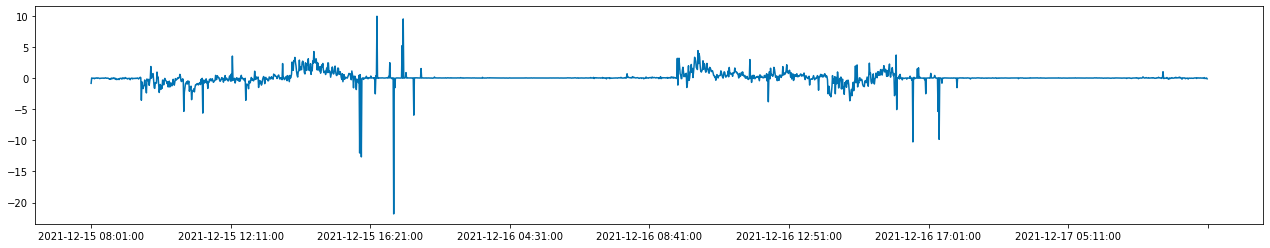

In [223]:
# Let's see the volume data after deseasonilization:
apple_final['deseason_final'][390000:392000].plot(figsize=(22,4))

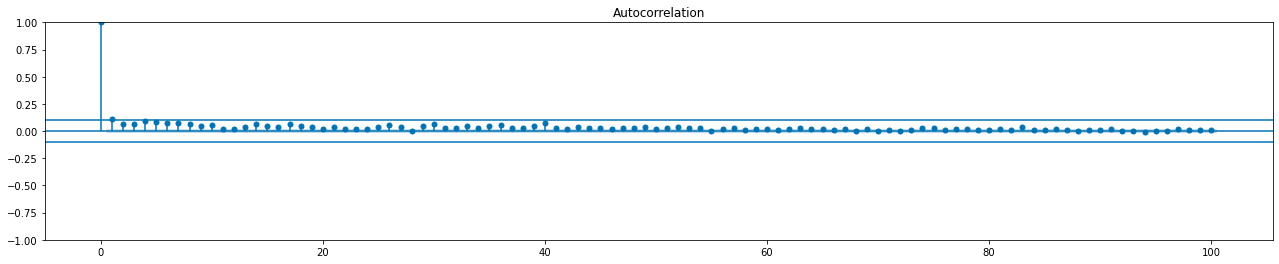

In [227]:
# And our autocorrelation graphic:
fig, ax = plt.subplots(1,1,figsize=(22,4))
plot_acf(apple_final[-size:]['deseason_final'], alpha=0.1, lags=100, ax=ax)
plt.axhline(y=0.1)
plt.axhline(y=-0.1)

Just fine!, below our confidence level of 10%. We then will work with this as our volume data.

In [228]:
#Final clean of our data and let's start to train.
apple_final.drop(columns=['volume','deseason','second_order',
                          'yeojohnson','scaled'], inplace=True)
apple_final.rename(columns={'deseason_final':'volume'}, inplace=True)
apple_final.describe()

market         close            rsi        volume
count  477120.000000  4.771190e+05  477089.000000  4.771200e+05
mean       -0.009271 -1.231008e-15      -0.000516  8.091186e-16
std         0.076427  1.000001e+00       0.047542  1.000001e+00
min        -0.100000 -5.598547e+01      -1.000000 -7.508399e+01
25%        -0.100000 -2.811766e-01      -0.018421 -2.920364e-02
50%         0.000000 -2.236068e-03       0.000000  4.448157e-03
75%         0.025000  2.903213e-01       0.018254  3.417711e-02
max         0.100000  5.598100e+01       0.975000  7.341933e+01

In [229]:
# And a final check of ADF and autorcorrelation:
checking_adf(apple_final, globalpar['test1']['structure']['total_size'], 
                          globalpar['test1']['structure']['sequence_size'])

ADF   p-value n_lags        1%        5%       10%  stationary
market   -5.06172  0.000017     30 -3.431034 -2.861842 -2.566931        True
close  -18.051515       0.0     30 -3.431034 -2.861842 -2.566931        True
rsi    -28.052256       0.0     30 -3.431034 -2.861842 -2.566931        True
volume -12.881656       0.0     30 -3.431034 -2.861842 -2.566931        True

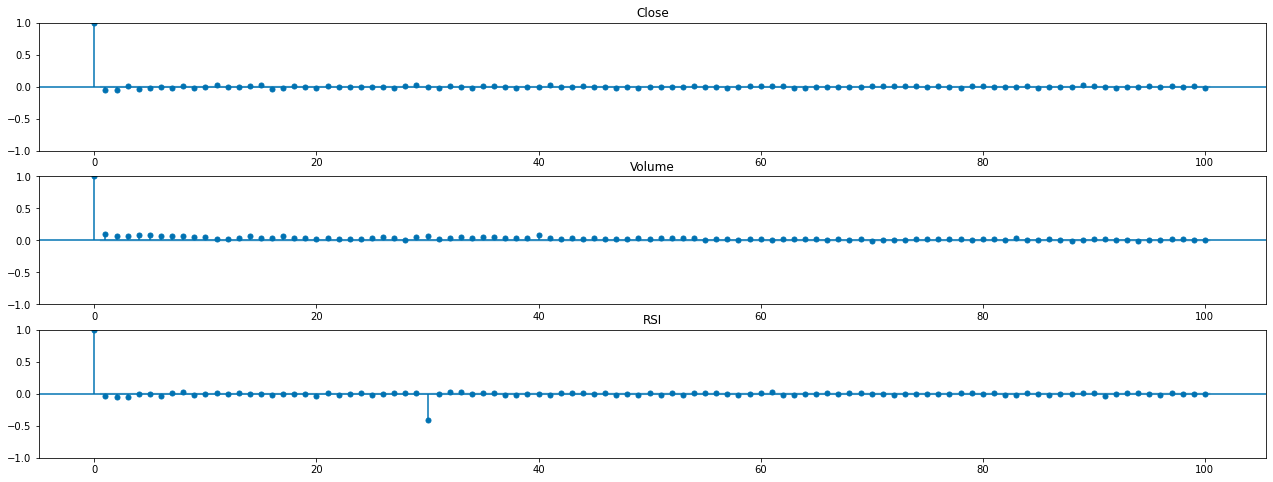

In [241]:
# Autocorrelation
fig, ax = plt.subplots(3,1,figsize=(22,8))
plot_acf(apple_final[-size:]['close'], alpha=0.1, lags=100, ax=ax[0])
plot_acf(apple_final[-size:]['volume'], alpha=0.1, lags=100, ax=ax[1])
plot_acf(apple_final[-size:]['rsi'], alpha=0.1, lags=100, ax=ax[2])

ax[0].set_title('Close')
ax[1].set_title('Volume')
ax[2].set_title('RSI')

plt.savefig('Autocorrelation_1min_stationary.png', bbox_inches='tight')

In [242]:
#########1#########2#########3#########4#########5#########6#########7#########8
###                       FOURTH PART: FINAL TRAINING                       ###8
#########1#########2#########3#########4#########5#########6#########7#########8

In this final part, after several trials, we will be training our final model with the parameters achieved during those trials.

In [243]:
# Final checks and adds to our data:
# The y or target column:
apple_final['next'] = apple_final['close'].shift(-1)
# and convert all data types to float32:
for col in apple_final.columns:
    apple_final[col] = apple_final[col].astype('float32')
# Finally delete the final NaN row in the dataset:
apple_final = apple_final[:-1]
apple_final

market     close       rsi    volume      next
2020-05-07 04:01:00    -0.1       NaN       NaN  0.004448  0.236708
2020-05-07 04:02:00    -0.1  0.236708       NaN  0.004448 -0.002236
2020-05-07 04:03:00    -0.1 -0.002236       NaN  0.004448 -0.002236
2020-05-07 04:04:00    -0.1 -0.002236       NaN  0.004448 -0.002236
2020-05-07 04:05:00    -0.1 -0.002236       NaN  0.004448  0.236669
...                     ...       ...       ...       ...       ...
2022-04-26 19:55:00     0.1 -0.466159  0.000042  0.029280  0.368914
2022-04-26 19:56:00     0.1  0.368914 -0.011635  0.010733  0.090537
2022-04-26 19:57:00     0.1  0.090537  0.038998  0.014893 -0.466159
2022-04-26 19:58:00     0.1 -0.466159 -0.023013  0.016907  0.462614
2022-04-26 19:59:00     0.1  0.462614 -0.018294  0.008302 -0.281499

[477119 rows x 5 columns]

In [245]:
# Checking our parameters
globalpar['test_f']

{'data': {'ticker': 'AAPL', 'interval': '1min', 'minutes': 1, 'sma_range': 30},
 'structure': {'training_size': 0.8,
  'test_size': 0.2,
  'total_size': 38400,
  'sequence_size': 30,
  'batch_size': 64,
  'input_size': 4,
  'weight_decay': 0.0},
 'training': {'sequence_size': 30,
  'batch_size': 64,
  'model_input_size': 4,
  'model_lstm_layers': 3,
  'model_lstm_size': 128,
  'model_dropout': 0.25,
  'model_output': 1,
  'epochs': 600,
  'optimizer': 'Adam',
  'lrs': [0.001, 0.0001, 1e-05],
  'lr_change': True,
  'epochs_change': 450,
  'weight_decay': 0.0}}

In [248]:
# Let's extract our training and testing sets and start to train
train_X, train_y, test_X, test_y = final_array(apple_final, 
                                               globalpar['test_f']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y, 
                                              globalpar['test_f']['training'], 
                                              init_wgs=False)

final train X shape: (30720, 30, 4), train y shape: (30720,)
final test X shape: (7680, 30, 4), test y shape: (7680,)
torch.Size([30720, 30, 4]) torch.Size([30720]) torch.Size([7680, 30, 4]) torch.Size([7680])
Optimizer: Adam, Leaning rate: 0.001
Epoch[10/600] | loss train:6.65762086, test:2.13584673, lr: 0.001
Epoch[20/600] | loss train:6.43898126, test:2.20740945, lr: 0.001
Epoch[30/600] | loss train:5.72477878, test:2.32668150, lr: 0.001
Epoch[40/600] | loss train:4.76837683, test:2.51768015, lr: 0.001
Epoch[50/600] | loss train:3.88774181, test:2.58539601, lr: 0.001
Epoch[60/600] | loss train:3.24302600, test:2.63923962, lr: 0.001
Epoch[70/600] | loss train:2.69874134, test:2.64470973, lr: 0.001
Epoch[80/600] | loss train:2.30264864, test:2.73689437, lr: 0.001
Epoch[90/600] | loss train:2.37969014, test:2.73899080, lr: 0.001
Epoch[100/600] | loss train:1.81183534, test:2.68347528, lr: 0.001
Epoch[110/600] | loss train:1.71741519, test:2.72598711, lr: 0.001
Epoch[120/600] | loss tra

In [249]:
# Saving and reloading the model:
saving_model(model, 'aapl_predicting_Fmodel_1minute')
model = loading_model('aapl_predicting_Fmodel_1minute')

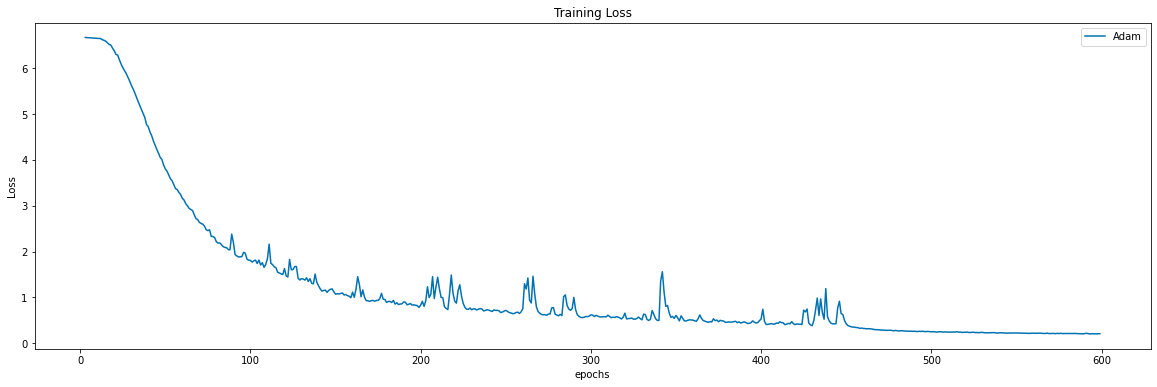

In [253]:
# The resulting training curve
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam'])
graphs_Adam_train.loc[3:].plot(figsize=(20,6), title='Training Loss', 
                               xlabel='epochs', ylabel='Loss')
plt.savefig('FInal_trainingloss_1min_sta.png', bbox_inches='tight')

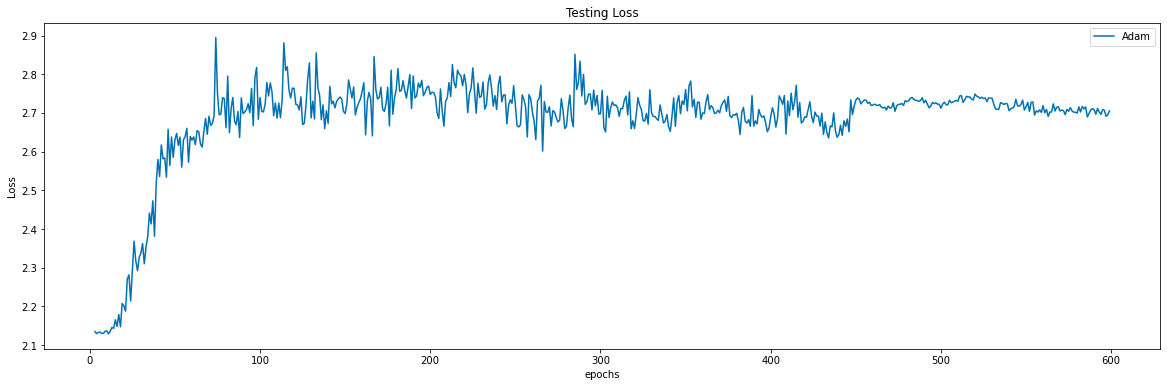

In [255]:
# And the resulting testing curve
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam'])
graphs_Adam_test.loc[3:].plot(figsize=(20,6), title='Testing Loss', 
                              xlabel='epochs', ylabel='Loss')
plt.savefig('Final_testingloss_1min_sta.png', bbox_inches='tight')

In [256]:
# Let's prepare a function to predict values based on the trained model
# In the same process we will denormalized those values and apply
# the exponential function to return to the original return values, a better
# approach to analyze our predictions.
def unlog_predict(data, param, model, scaler):
    '''
    Function that predict the values based on the model, 
    denormalize the data and finally return to the simple return applying
    the exponential function to a log-return kind of data
    
    Function parameteres:
    
        * Required: data: the dataframe to be predicted.
        
        * Required: para: The structure parameters involved.
        
        * Required: model: the trained model to use.
        
        * Required: scaler: the scaler used at the moment of 
                            normalize the 'close' data.
                            
    Returns:
        A Dataframe with the 'close' and the 'close_predicted' returns.
    '''
    # First prepare the data to be predicted and predict
    x_to_predict, y_to_predict = data_to_predict(data, param['structure'])
    predicted = predicted_df(model, x_to_predict, y_to_predict)
    # Now denormalize them
    predicted['close'] = de_normalize(predicted['close'], scaler)
    predicted['close_predicted'] = de_normalize(predicted['close_predicted'], 
                                                scaler)
    # Finally returng the values back to the regular return.
    predicted = np.exp((predicted/10))-1
    
    return predicted

In [257]:
#Let's test the function and see the result for our last training
predicted = unlog_predict(apple_final, globalpar['test_f'], model, 
                          close_scaler)
predicted

close  close_predicted
0     -1.825706e-03        -0.001722
1      6.096817e-05         0.000029
2     -3.048223e-04        -0.000279
3      2.509104e-14         0.000025
4      1.036712e-03         0.001080
...             ...              ...
38366 -3.202049e-04         0.001185
38367  2.562460e-04         0.000483
38368  6.404509e-05        -0.000125
38369 -3.202049e-04        -0.000650
38370  3.209481e-04         0.007903

[38371 rows x 2 columns]

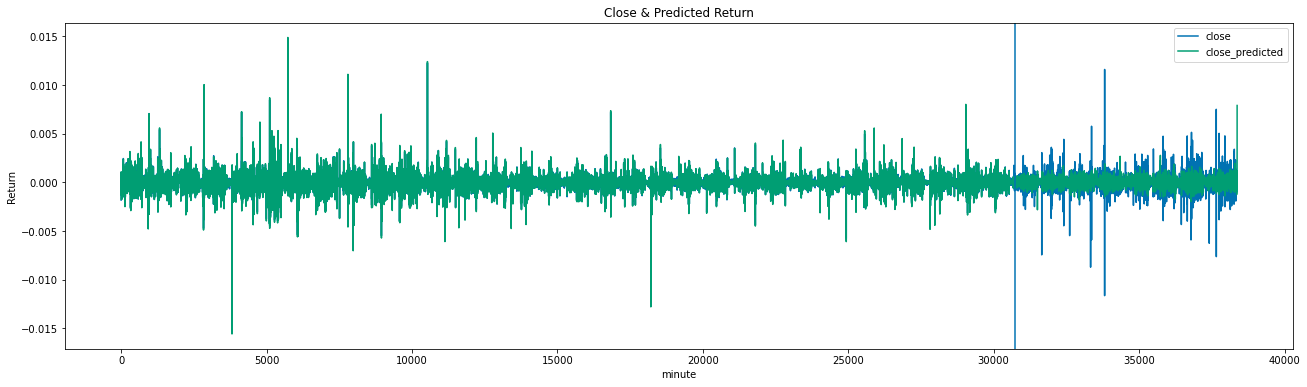

In [260]:
# Plotting the whole data prediction and close base data
predicted[['close','close_predicted']].plot(figsize=(22,6), 
                                            title='Close & Predicted Return',
                                            xlabel = 'minute',
                                            ylabel='Return')
#Where the testing starts
plt.axvline(x=30720)
plt.savefig('Final_predicted_return_1min_sta.png', bbox_inches='tight')

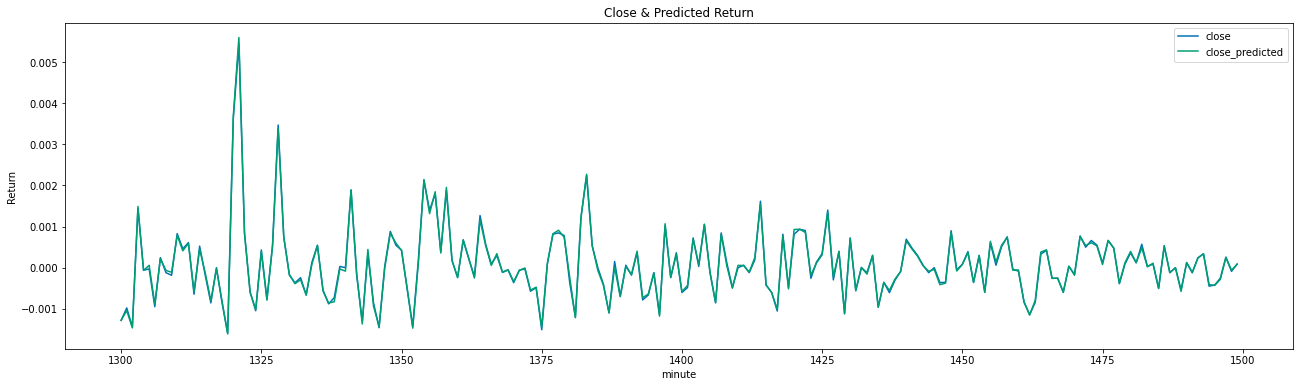

In [261]:
# A beautiful closer look to the training phase
# The lag dissapears!!
predicted[1300:1500][['close','close_predicted']].plot(figsize=(22,6),
                                            title='Close & Predicted Return',
                                            xlabel = 'minute',
                                            ylabel='Return')

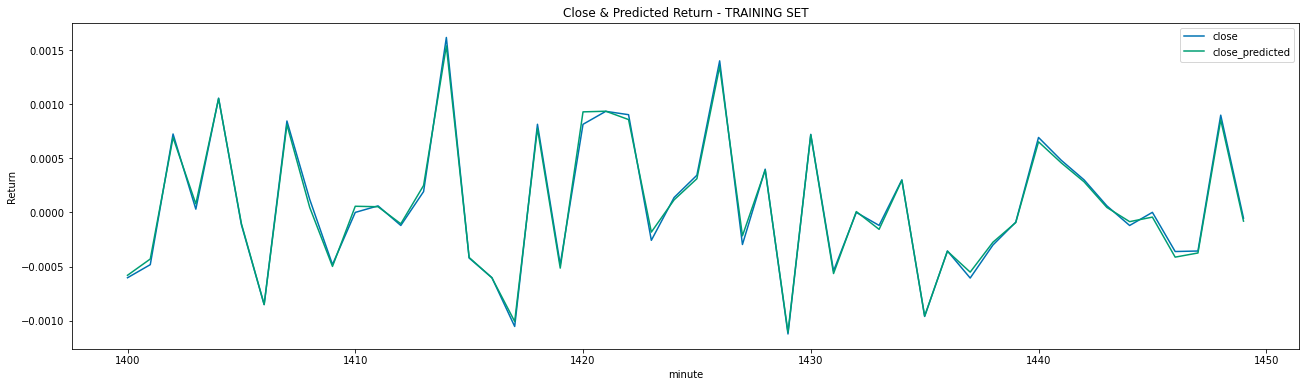

In [263]:
# Closer look
predicted[1400:1450][['close','close_predicted']].plot(figsize=(22,6),
                                title='Close & Predicted Return - TRAINING SET',
                                xlabel = 'minute',
                                ylabel='Return')
plt.savefig('Final_predicted_return_training_1min_sta.png', bbox_inches='tight')

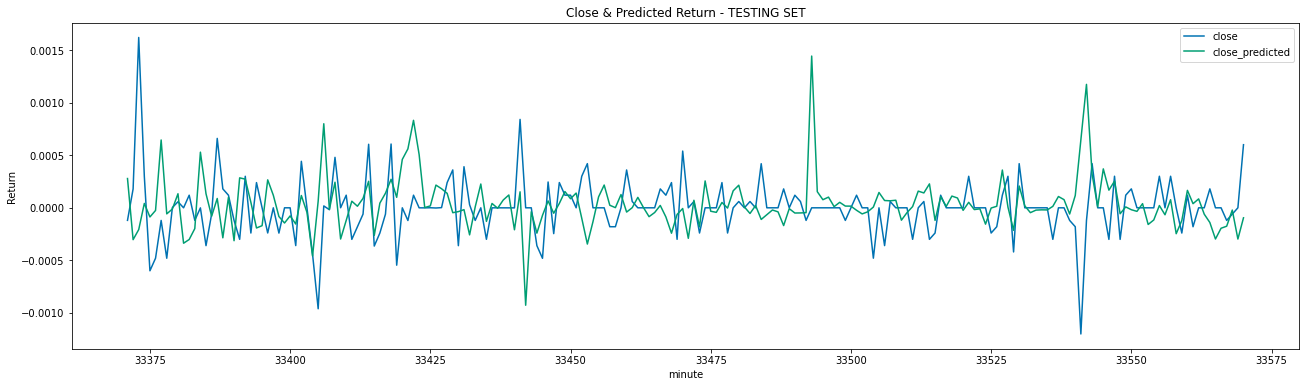

In [264]:
# Now a closer look to the testing phase: (Not that beautiful!)
predicted[-5000:-4800][['close','close_predicted']].plot(figsize=(22,6),
                                title='Close & Predicted Return - TESTING SET',
                                xlabel = 'minute',
                                ylabel='Return')
plt.savefig('Final_predicted_return_testing_1min_sta.png', bbox_inches='tight')

<AxesSubplot:>

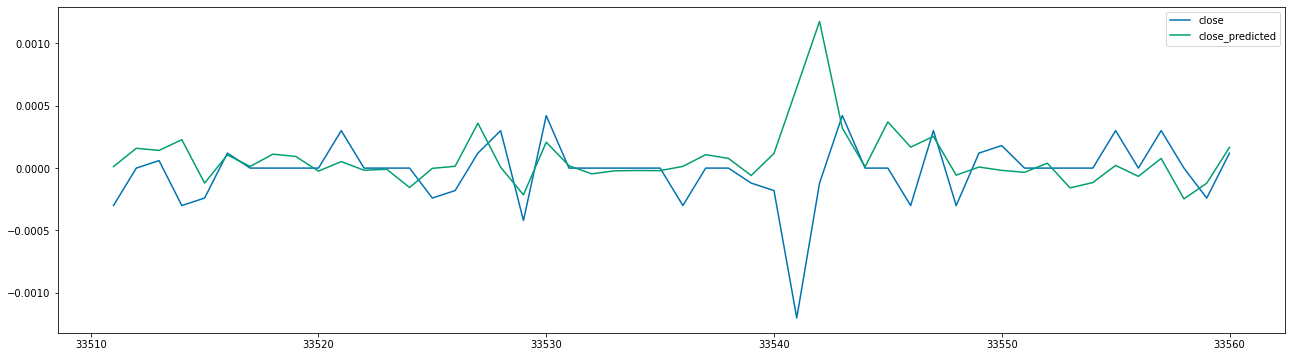

In [265]:
# Closer look
predicted[-4860:-4810][['close','close_predicted']].plot(figsize=(22,6))

What we have here is a perfect example of an Ovefitting result. We definitely solved the lag problem, the training looks beautifullly, but the testing not really.

If we check the training plots we can confirm the overfitting again. The testing is not improving at all. We need to find a way to fit as much as possible the training process but trying to have a better performance on the testing set.

Before we go further let's first check the same accuracy as before, but this time for training and testing parts separately. 

In [271]:
# With this data we need a different accuracy calculation.
# As the other one but woriking with returns.
def new_accuracy(data, test=0.2):
    '''
    Function that calculates the accuracy of predict positive or
    negative returns in the data.
    
    Function parameters:
    
        * Required: data: The data with the 'close' and 'close_predicted'
                          values to compare.
                          
    Returns:
        predicted: a new dataframe with extra columns with the positive
                   or negative returns references.
        acc_pred: The accuracy between predicted and original values.
        acc_base: The accuracy between the baseline performance and the
                  original values.
    '''
    
    predicted = data.copy()
    return_posneg = lambda x: (1 * (x >= 0))
    middle = int(len(data) * (1 - test))
    
    
    predicted['baseline'] = predicted['close'].shift(1)
    # To measure some accuracy we need to have a discrete value. So we create 
    # a new column that only have a 0 if the return is negative and 1 if 
    # positive.
    predicted['close_posneg'] = return_posneg(predicted['close'])
    predicted['predicted_posneg'] = return_posneg(predicted['close_predicted'])
    predicted['baseline_posneg'] = return_posneg(predicted['baseline'])
    # Accuracy calcs
    print('Accuracy on training set:')
    print('Pred/Close: {}'.format(accuracy_score(\
                                predicted.loc[2:middle]['close_posneg'], 
                                predicted.loc[2:middle]['predicted_posneg'])))
    print('Persist/Close: {}'.format(accuracy_score(\
                                predicted.loc[2:middle]['close_posneg'], 
                                predicted.loc[2:middle]['baseline_posneg'])))
    print('Accuracy on testing set:')
    print('Pred/Close: {}'.format(accuracy_score(\
                                predicted.loc[middle:]['close_posneg'], 
                                predicted.loc[middle:]['predicted_posneg'])))
    print('Persist/Close: {}'.format(accuracy_score(\
                                predicted.loc[middle:]['close_posneg'], 
                                predicted.loc[middle:]['baseline_posneg'])))

    return predicted

In [272]:
# Let's check the accuracy:
_ = new_accuracy(predicted)

Accuracy on training set:
Pred/Close: 0.8795895096921322
Persist/Close: 0.5457892164847695
Accuracy on testing set:
Pred/Close: 0.5180456026058632
Persist/Close: 0.5533550488599348


In [329]:
# Let's now check the accuracy only in the periods of regular hours trading.
# With the same training but avoiding only on results the pre and post market
# hours
def accuracy_for_regular_hours(data):
    '''
    This function slices the dataframe with only the regular hours
    trading information, for a further accuracy calculation.
    
    Function parameteres:
    
        * Required: data: The dataframe with the original price and
                          the predicted price to compare.
                          
    Returns:
            Prints the accuracy of the regular hours rows prices and
            predictions
    '''
    #How many days are in the data. Every day data is 960 rows
    days = (len(data) + 29) / 960
    # We make an array of only the rows to choose equivalent to those in regular
    # trading hours, 450 rows every day.
    groups = [y for x in range(240,int(241 + (days-1) * 960),960) \
                for y in range (x, (x + 450))]
    # Now we select only the rows of regular hours trading.
    predicted_regularhours = data.iloc[groups,:]
    # And calculate the accuracy for those predictions
    _ = new_accuracy(predicted_regularhours)

In [330]:
accuracy_for_regular_hours(predicted)

Accuracy on training set:
Pred/Close: 0.9801481481481481
Persist/Close: 0.5013333333333333
Accuracy on testing set:
Pred/Close: 0.8266666666666667
Persist/Close: 0.5072888888888889


BEAUTIFUL!

In [331]:
# Let's do the same training with a much less epochs to grant a smaller
# loss for the test set. Less like only 50 epochs.
globalpar['test_f']['training']['epochs'] = 50
# Let's extract our training and testing sets and start to train
train_X, train_y, test_X, test_y = final_array(apple_final, 
                                               globalpar['test_f']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model_s,loss_train,loss_test = training_model(train_X, train_y, test_X, test_y, 
                                              globalpar['test_f']['training'], 
                                              init_wgs=False)

final train X shape: (30720, 30, 4), train y shape: (30720,)
final test X shape: (7680, 30, 4), test y shape: (7680,)
torch.Size([30720, 30, 4]) torch.Size([30720]) torch.Size([7680, 30, 4]) torch.Size([7680])
Optimizer: Adam, Leaning rate: 0.001
Epoch[10/50] | loss train:6.65226504, test:2.13298341, lr: 0.001
Epoch[20/50] | loss train:6.42479046, test:2.22119081, lr: 0.001
Epoch[30/50] | loss train:5.90069741, test:2.24914737, lr: 0.001
Epoch[40/50] | loss train:5.05706650, test:2.37327989, lr: 0.001
Epoch[50/50] | loss train:4.27959552, test:2.50401871, lr: 0.001
last train: 4.27959552151151, minimo train: 4.27959552151151 
last test: 2.5040187146514654, minimo test: 2.1302070724777877


In [332]:
#Let's predict with the new short model:
predicted_s = unlog_predict(apple_final, globalpar['test_f'], model_s, 
                          close_scaler)
predicted_s

close  close_predicted
0     -1.825706e-03         0.000040
1      6.096817e-05         0.000088
2     -3.048223e-04         0.000178
3      2.509104e-14        -0.000105
4      1.036712e-03        -0.000089
...             ...              ...
38366 -3.202049e-04         0.000033
38367  2.562460e-04         0.000150
38368  6.404509e-05        -0.000022
38369 -3.202049e-04         0.000011
38370  3.209481e-04         0.000048

[38371 rows x 2 columns]

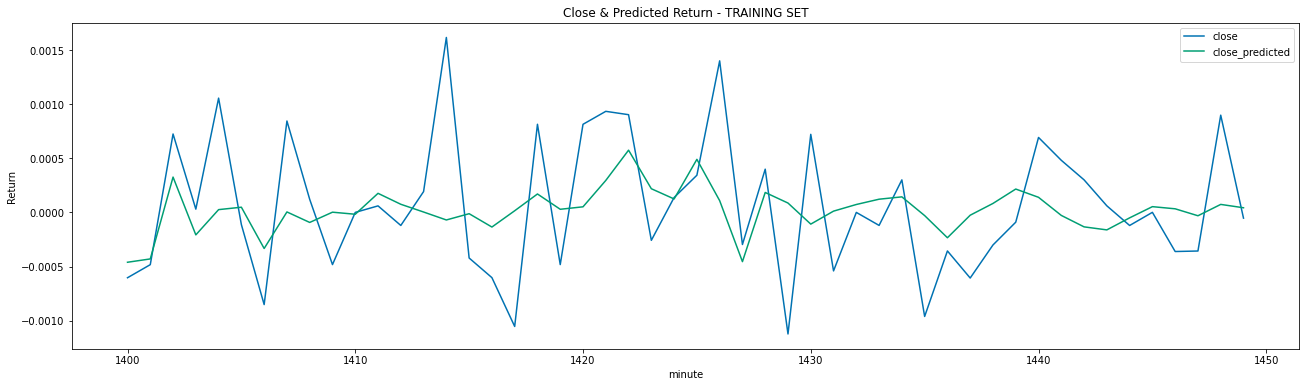

In [333]:
predicted_s[1400:1450][['close','close_predicted']].plot(figsize=(22,6),
                                title='Close & Predicted Return - TRAINING SET',
                                xlabel = 'minute',
                                ylabel='Return')
plt.savefig('Extra_predicted_return_training_1min_sta.png', bbox_inches='tight')

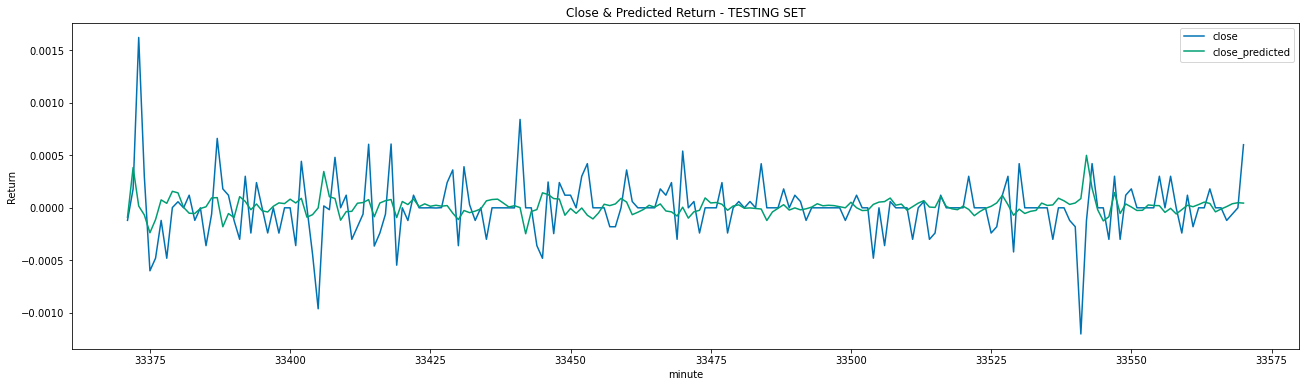

In [334]:
# Now a closer look to the testing phase: (Not that beautiful!)
predicted_s[-5000:-4800][['close','close_predicted']].plot(figsize=(22,6),
                                title='Close & Predicted Return - TESTING SET',
                                xlabel = 'minute',
                                ylabel='Return')
plt.savefig('Extra_predicted_return_testing_1min_sta.png', bbox_inches='tight')

<AxesSubplot:>

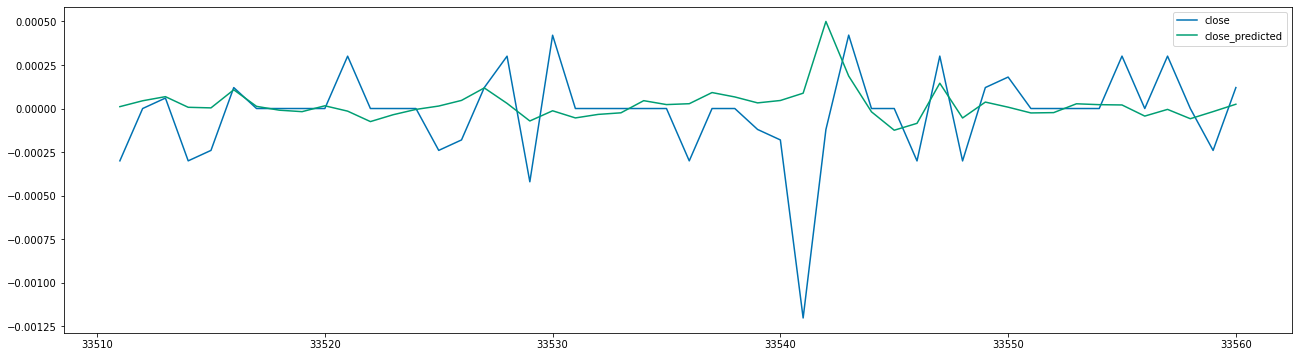

In [335]:
# Closer look
predicted_s[-4860:-4810][['close','close_predicted']].plot(figsize=(22,6))

In [336]:
# Let's check the accuracy:
_ = new_accuracy(predicted_s)

Accuracy on training set:
Pred/Close: 0.6443068903730249
Persist/Close: 0.5457892164847695
Accuracy on testing set:
Pred/Close: 0.5719869706840391
Persist/Close: 0.5533550488599348


In [337]:
# And now the accuracy for regular hours
accuracy_for_regular_hours(predicted_s)

Accuracy on training set:
Pred/Close: 0.7011851851851851
Persist/Close: 0.5013333333333333
Accuracy on testing set:
Pred/Close: 0.5842666666666667
Persist/Close: 0.5072888888888889


Definitely the use of the extra market hours, like pre and post market hours, didn't help to the initial training.

For better future perfomance we will remove this data and deal with the outliers in those areas before start to train the model.

Below these lines you will find more undocumentend trainings performed before our final and above model.

In [273]:
#########1#########2#########3#########4#########5#########6#########7#########8
###             FIFTH PART: OTHER UNSUCCESFUL TRAINING PERFORMED            ###8
#########1#########2#########3#########4#########5#########6#########7#########8

In [660]:
# This time I will use a different approach creating different sets
# of parameters and iterating on each set:
# Create a globalpar dictionary with iterables values for the purpose mention 
# above
multipar = globalpar['test_f']

param_sets = {
    'sizes' : [[19200],[19200],[19200],[19200],[19200],
               [19200],[19200],[19200],[19200],[19200]],
    'sequences' : [30, 30, 30, 30, 30, 
                   30, 30, 30, 30, 30],
    'lstm_sizes' : [[128],[128],[128],[128],[128],
                    [256],[256],[128],[256],[128]],
    'lstm_layers' : [[3],[3],[3],[3],[2],
                     [3],[3],[3],[3],[2]],
    'dropout' : [[0.1],[0.2],[0.1],[0.3],[0.15],
                 [0.25],[0.15],[0.3],[0.1],[0.2]],
    'epochs' : [[150],[150],[150],[150],[150],
                [150],[150],[150],[150],[150]],
    'lrs' : [[[0.01]],[[0.05]],[[0.01]],[[0.005]],[[0.015]],
             [[0.05]],[[0.01]],[[0.005]],[[0.01]],[[0.05]]],
    'weights' : [[0.],[0.01],[0.05],[0.001],[0.],
                 [0.01],[0.05],[0.001],[0.],[0.01]],
    'optimizers' : [['SGD'],['Adam'],['Adam'],['Adam'],['SGD'],
                    ['Adam'],['Adam'],['Adam'],['SGD'],['Adam']]
}
    
for i in range(10):
    multipar['structure']['total_size'] = param_sets['sizes'][i]
    multipar['structure']['sequence_size'] = param_sets['sequences'][i]
    multipar['training']['sequence_size'] = param_sets['sequences'][i]
    multipar['structure']['batch_size'] = [64]
    multipar['training']['model_lstm_size'] = param_sets['lstm_sizes'][i]
    multipar['training']['model_lstm_layers'] = param_sets['lstm_layers'][i]
    multipar['training']['model_dropout'] = param_sets['dropout'][i]
    multipar['training']['epochs'] = param_sets['epochs'][i]
    multipar['training']['lrs'] = param_sets['lrs'][i]
    multipar['training']['weight_decay'] = param_sets['weights'][i]
    multipar['training']['optimizer'] = param_sets['optimizers'][i]

    test, model = multivariate_model_train(apple_final, multipar)
    test = pd.DataFrame(test).T
    
        
    predicted = unlog_predict(apple_final, multipar, model, close_scaler)
    middle = -int(multipar['structure']['total_size'] * \
                  multipar['structure']['test_size'])
    print('Training acc:')
    _, acc_train, acc_base_train  = new_accuracy(predicted[:middle])
    print('Testing acc:')
    _, acc_test, acc_base_test = new_accuracy(predicted[middle:])
    test['acc_train'], test['acc_base_train'] = acc_train, acc_base_train
    test['acc_test'], test['acc_base_test'] = acc_test, acc_base_test
    
    if i==0:
        tests = test
    else:
        tests = pd.concat([tests, test])

tests.reset_index(drop=True, inplace=True)
        

final train X shape: (15360, 30, 4), train y shape: (15360,)
final test X shape: (3840, 30, 4), test y shape: (3840,)
torch.Size([15360, 30, 4]) torch.Size([15360]) torch.Size([3840, 30, 4]) torch.Size([3840])
Optimizer: SGD, Leaning rate: 0.01
Epoch[10/150] | loss train:2.42139335, test:1.29685687, learning rate: 0.01
Epoch[20/150] | loss train:2.41226307, test:1.30924480, learning rate: 0.01
Epoch[30/150] | loss train:2.38595512, test:1.30678129, learning rate: 0.01
Epoch[40/150] | loss train:2.39113836, test:1.31645476, learning rate: 0.01
Epoch[50/150] | loss train:2.36582384, test:1.32275520, learning rate: 0.01
Epoch[60/150] | loss train:2.35030759, test:1.31501408, learning rate: 0.01
Epoch[70/150] | loss train:2.34131747, test:1.32012707, learning rate: 0.01
Epoch[80/150] | loss train:2.32278449, test:1.33668746, learning rate: 0.01
Epoch[90/150] | loss train:2.30026190, test:1.36084859, learning rate: 0.01
Epoch[100/150] | loss train:2.25696209, test:1.34695905, learning rate:

Training acc:
Accuracy Pred/Close: 0.6443342683801944
Accuracy Base/Close: 0.5620066540544066
Testing acc:
Accuracy Pred/Close: 0.5955729166666667
Accuracy Base/Close: 0.5403645833333334
final train X shape: (15360, 30, 4), train y shape: (15360,)
final test X shape: (3840, 30, 4), test y shape: (3840,)
torch.Size([15360, 30, 4]) torch.Size([15360]) torch.Size([3840, 30, 4]) torch.Size([3840])
Optimizer: Adam, Leaning rate: 0.05
Epoch[10/150] | loss train:2.44380367, test:1.29620377, learning rate: 0.05
Epoch[20/150] | loss train:2.87492221, test:1.32340711, learning rate: 0.05
Epoch[30/150] | loss train:2.99772718, test:1.30275051, learning rate: 0.05
Epoch[40/150] | loss train:19.72692827, test:7.40226001, learning rate: 0.05
Epoch[50/150] | loss train:3.29171974, test:1.42627449, learning rate: 0.05
Epoch[60/150] | loss train:3.67737291, test:1.30667015, learning rate: 0.05
Epoch[70/150] | loss train:3.04816785, test:1.86934811, learning rate: 0.05
Epoch[80/150] | loss train:2.77987

Epoch[140/150] | loss train:2.61228424, test:1.32236213, learning rate: 0.05
Epoch[150/150] | loss train:2.77678237, test:1.45923859, learning rate: 0.05
last train: 2.7767823725007474, minimo train: 2.444844394689426 
last test: 1.4592385906726122, minimo test: 1.2949234219267964
Training acc:
Accuracy Pred/Close: 0.3854785047948333
Accuracy Base/Close: 0.5620066540544066
Testing acc:
Accuracy Pred/Close: 0.3997395833333333
Accuracy Base/Close: 0.5403645833333334


In [661]:
tests3 = tests
tests3

batches dropout epochs last_test last_train       lr lstm_layer lstm_size  \
0      64     0.1    150  1.584022   1.997229   [0.01]          3       128   
1      64     0.2    150  1.297006   2.457113   [0.05]          3       128   
2      64     0.1    150  1.296062   2.444442   [0.01]          3       128   
3      64     0.3    150  1.297011   2.443283  [0.005]          3       128   
4      64    0.15    150   1.62045   1.930079  [0.015]          2       128   
5      64    0.25    150  1.297787   2.460882   [0.05]          3       256   
6      64    0.15    150  1.296962   2.448859   [0.01]          3       256   
7      64     0.3    150  1.300739   2.445906  [0.005]          3       128   
8      64     0.1    150  1.626417   1.859301   [0.01]          3       256   
9      64     0.2    150  1.459239   2.776782   [0.05]          2       128   

   min_test min_train   opt seq   size  \
0  1.296247  1.982648   SGD  30  19200   
1  1.294109  2.445117  Adam  30  19200   
2   1.29606  2.441831  Adam  30  19200   
3  1.295828  2.442917  Adam  30  19200   
4  1.297813  1.930079   SGD  30  19200   
5  1.296103  2.443804  Adam  30  19200   
6   1.29606  2.442897  Adam  30  19200   
7  1.295085  2.443045  Adam  30  19200   
8  1.299056  1.859301   SGD  30  19200   
9  1.294923  2.444844  Adam  30  19200   

                                             testing  \
0  [1.3223530747927725, 1.3052335451357067, 1.301...   
1  [1.3326658392325044, 1.295623792335391, 1.3076...   
2  [1.2965045203454792, 1.2973718200810254, 1.296...   
3  [1.2968911258503795, 1.2977777011692524, 1.297...   
4  [1.2992161964066327, 1.3042600806802511, 1.301...   
5  [1.5102047696709633, 5.1584851667284966, 1.461...   
6  [1.29664056468755, 1.2980447802692652, 1.29614...   
7  [1.3078248407691717, 1.2965507758781314, 1.296...   
8  [1.3013274753466249, 1.2990561705082655, 1.304...   
9  [1.2999979117885232, 1.29579599481076, 1.29644...   

                                            training weight_decay  acc_train  \
0  [2.462480017449707, 2.4428815168794245, 2.4336...          0.0   0.631157   
1  [4.830352189484984, 2.5507470273878425, 2.5000...         0.01   0.614391   
2  [2.450479383347556, 2.4443106369581074, 2.4430...         0.05   0.385479   
3  [2.4608876907732338, 2.447161716176197, 2.4436...        0.001   0.614521   
4  [2.4638282069936395, 2.4602044634521008, 2.447...          0.0   0.644334   
5  [21.999105492141098, 3.6678901854902506, 5.289...         0.01   0.614521   
6  [2.471029488835484, 2.4437436377629638, 2.4428...         0.05   0.614521   
7  [2.4673430495895445, 2.446336127119139, 2.4437...        0.001   0.614521   
8  [2.4748954684473574, 2.4652330884709954, 2.445...          0.0   0.636571   
9  [3.562726299278438, 2.5010257912799716, 2.4501...         0.01   0.385479   

   acc_base_train  acc_test  acc_base_test  
0        0.562007  0.582552       0.540365  
1        0.562007  0.600521       0.540365  
2        0.562007  0.399740       0.540365  
3        0.562007  0.600260       0.540365  
4        0.562007  0.595573       0.540365  
5        0.562007  0.600260       0.540365  
6        0.562007  0.600260       0.540365  
7        0.562007  0.600260       0.540365  
8        0.562007  0.585417       0.540365  
9        0.562007  0.399740       0.540365

<AxesSubplot:>

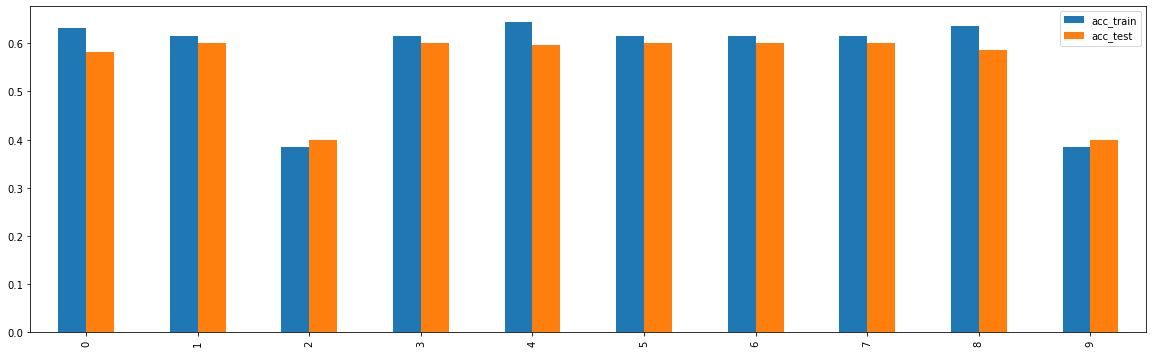

In [662]:
tests3.loc[:,['acc_train','acc_test']].plot(figsize=(20,6), kind='bar')

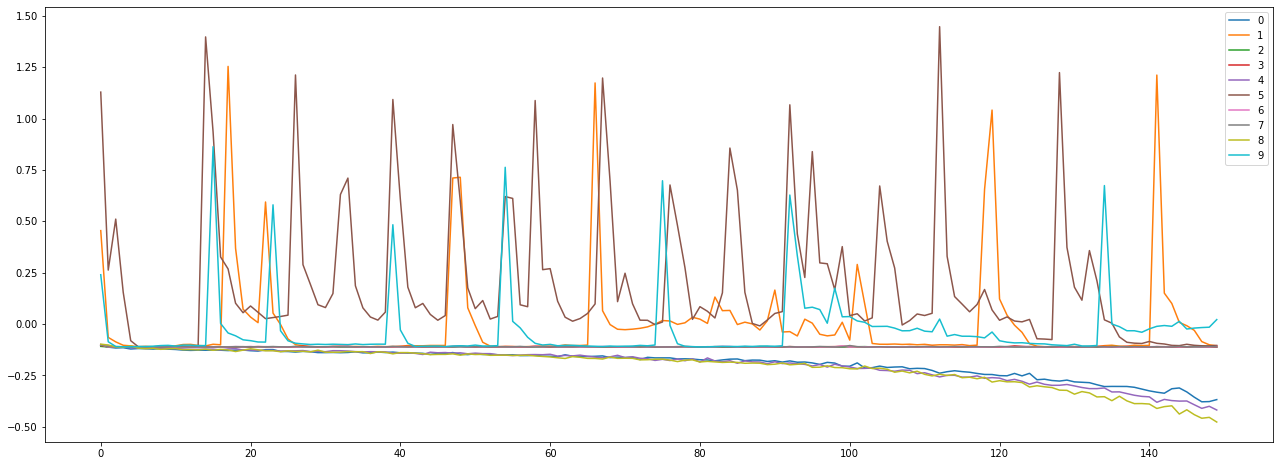

In [706]:
tests3['training'].apply(lambda x: pd.Series(np.log(np.log(x))).\
                         plot(figsize=(22,8)))
plt.legend(labels=[0,1,2,3,4,5,6,7,8,9])

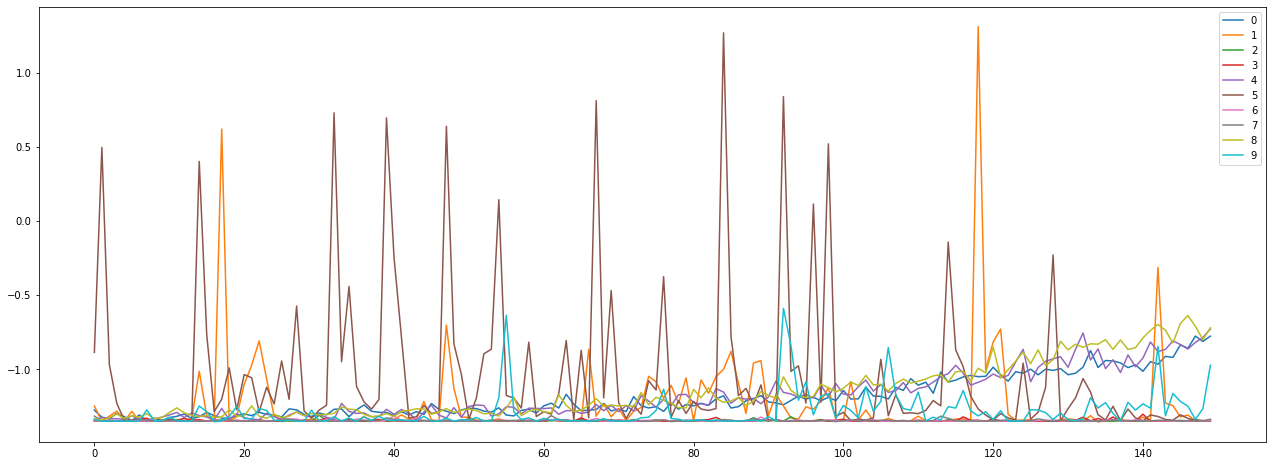

In [705]:
tests3['testing'].apply(lambda x: pd.Series(np.log(np.log(x))).\
                        plot(figsize=(22,8)))
plt.legend(labels=[0,1,2,3,4,5,6,7,8,9])

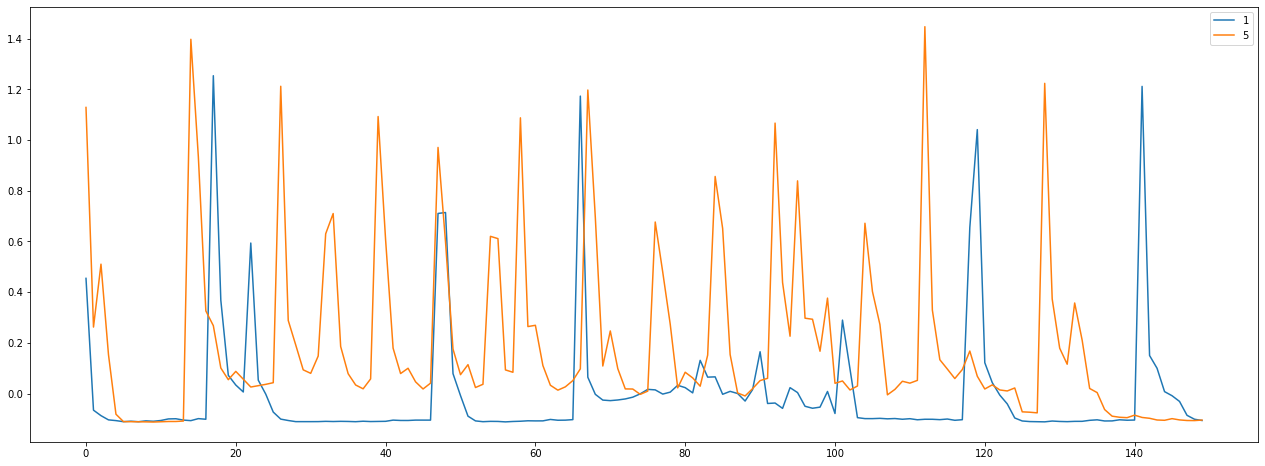

In [707]:
tests3.loc[[1,5]]['training'].apply(lambda x: pd.Series(np.log(np.log(x))).\
                                    plot(figsize=(22,8)))
plt.legend(labels=[1, 5])

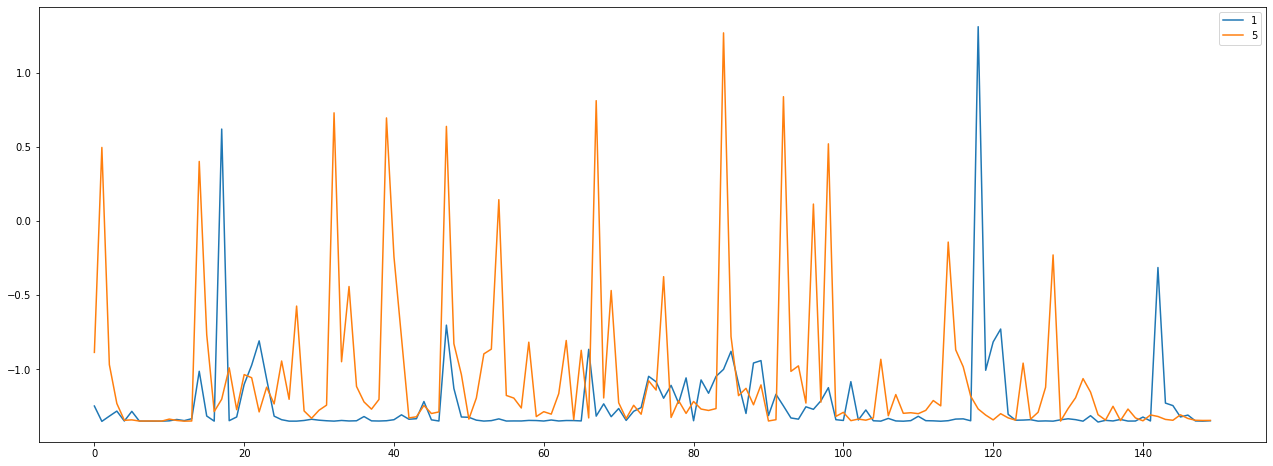

In [708]:
tests3.loc[[1,5]]['testing'].apply(lambda x: pd.Series(np.log(np.log(x))).\
                                   plot(figsize=(22,8)))
plt.legend(labels=[1, 5])

In [709]:
globalpar['test_f']

{'data': {'ticker': 'AAPL', 'interval': '1min', 'minutes': 1, 'sma_range': 30},
 'structure': {'training_size': 0.8,
  'test_size': 0.2,
  'total_size': 19200,
  'sequence_size': 30,
  'batch_size': 64,
  'input_size': 4,
  'weight_decay': 0.0},
 'training': {'sequence_size': 30,
  'batch_size': 64,
  'model_input_size': 4,
  'model_lstm_layers': 2,
  'model_lstm_size': 128,
  'model_dropout': 0.2,
  'model_output': 1,
  'epochs': 150,
  'optimizer': 'Adam',
  'lrs': [0.05],
  'lr_change': False,
  'epochs_change': 450,
  'weight_decay': 0.01}}

In [712]:
globalpar['test_f']['training']['epochs'] = 600
globalpar['test_f']['training']['model_lstm_layers'] = 3
globalpar['test_f']['training']['model_lstm_size'] = 256
globalpar['test_f']['training']['model_dropout'] = 0.25
globalpar['test_f']['training']['lrs'] = [0.05, 0.01, 0.005]
globalpar['test_f']['training']['epochs_change'] = 250
globalpar['test_f']['training']['lr_change'] = True
globalpar['test_f']['structure']['total_size'] = 38400

In [713]:
# Let's extract our training and testing sets and start to train
train_X, train_y, test_X, test_y = final_array(apple_final, 
                                               globalpar['test_f']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y, 
                                              globalpar['test_f']['training'], 
                                              init_wgs=False)

final train X shape: (30720, 30, 4), train y shape: (30720,)
final test X shape: (7680, 30, 4), test y shape: (7680,)
torch.Size([30720, 30, 4]) torch.Size([30720]) torch.Size([7680, 30, 4]) torch.Size([7680])
Optimizer: Adam, Leaning rate: 0.05
Epoch[10/600] | loss train:8.17369070, test:2.38646998, learning rate: 0.05
Epoch[20/600] | loss train:6.68171122, test:2.13213502, learning rate: 0.05
Epoch[30/600] | loss train:6.76568558, test:2.19506605, learning rate: 0.05
Epoch[40/600] | loss train:6.98520566, test:2.14761500, learning rate: 0.05
Epoch[50/600] | loss train:7.97402917, test:2.13770151, learning rate: 0.05
Epoch[60/600] | loss train:7.59789458, test:2.85704463, learning rate: 0.05
Epoch[70/600] | loss train:6.83062632, test:2.13234613, learning rate: 0.05
Epoch[80/600] | loss train:7.63594373, test:2.33507152, learning rate: 0.05
Epoch[90/600] | loss train:6.80647378, test:2.13364079, learning rate: 0.05
Epoch[100/600] | loss train:49.32750329, test:2.37438176, learning rat

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

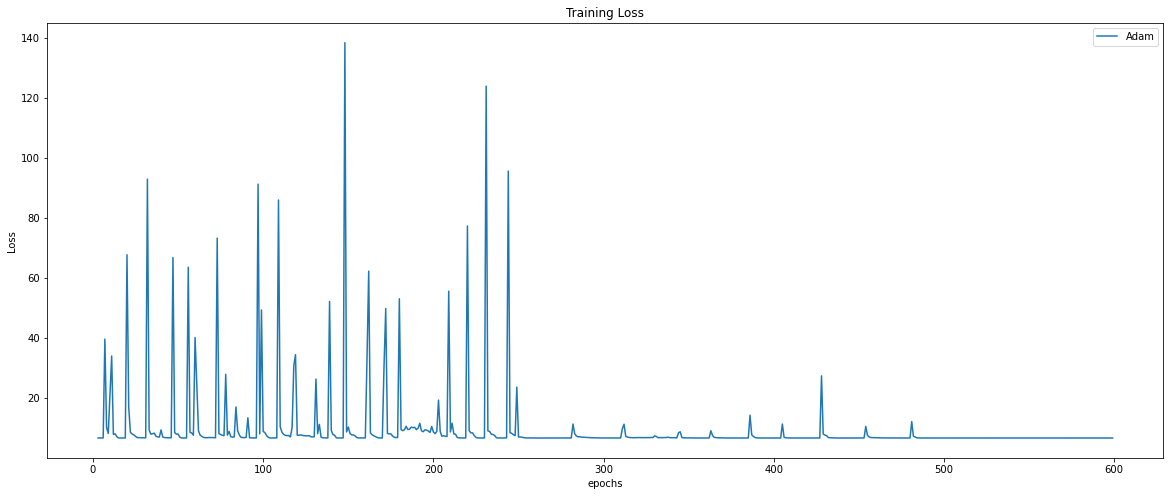

In [714]:
# The resulting training curve
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam'])
graphs_Adam_train.loc[3:].plot(figsize=(20,8), title='Training Loss', 
                               xlabel='epochs', ylabel='Loss')

<AxesSubplot:title={'center':'Testing Loss'}, xlabel='epochs', ylabel='Loss'>

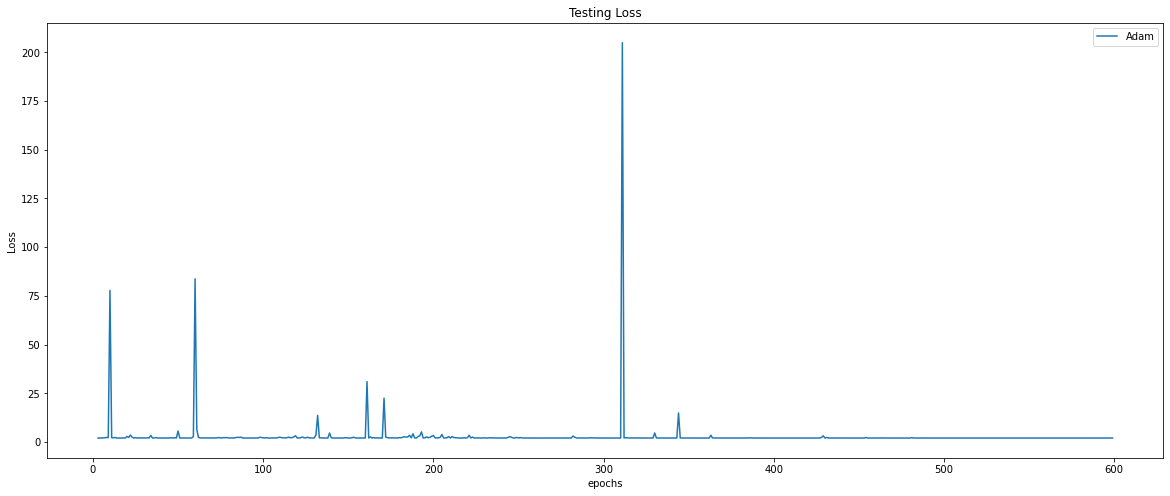

In [715]:
# And the resulting testing curve
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam'])
graphs_Adam_test.loc[3:].plot(figsize=(20,8), title='Testing Loss', 
                              xlabel='epochs', ylabel='Loss')

In [716]:
#Let's test the function and see the result for our last training
predicted = unlog_predict(apple_final, globalpar['test_f'], model, close_scaler)
predicted

close  close_predicted
0     -1.825706e-03        -0.000001
1      6.096817e-05        -0.000001
2     -3.048223e-04        -0.000001
3      2.509104e-14        -0.000001
4      1.036712e-03        -0.000001
...             ...              ...
38366 -3.202049e-04        -0.000001
38367  2.562460e-04        -0.000001
38368  6.404509e-05        -0.000001
38369 -3.202049e-04        -0.000001
38370  3.209481e-04        -0.000001

[38371 rows x 2 columns]

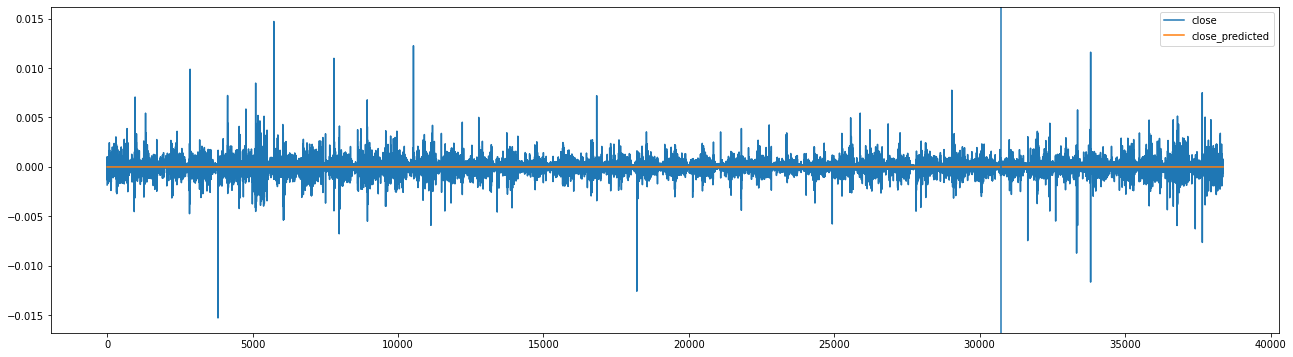

In [717]:
# Plotting the whole data prediction and close base data
predicted[['close','close_predicted']].plot(figsize=(22,6))
#Where the testing starts
plt.axvline(x=30720)

<AxesSubplot:>

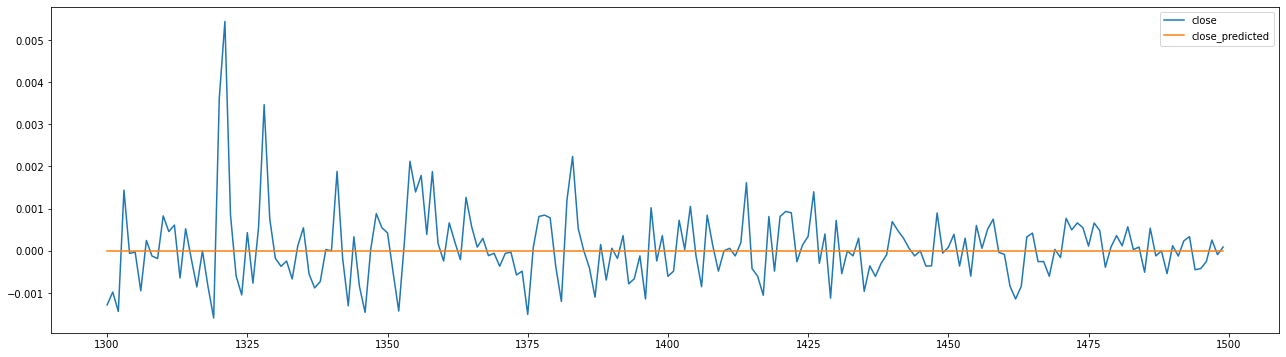

In [718]:
# A beautiful closer look to the training phase
# The lag dissapears!!
predicted[1300:1500][['close','close_predicted']].plot(figsize=(22,6))

<AxesSubplot:>

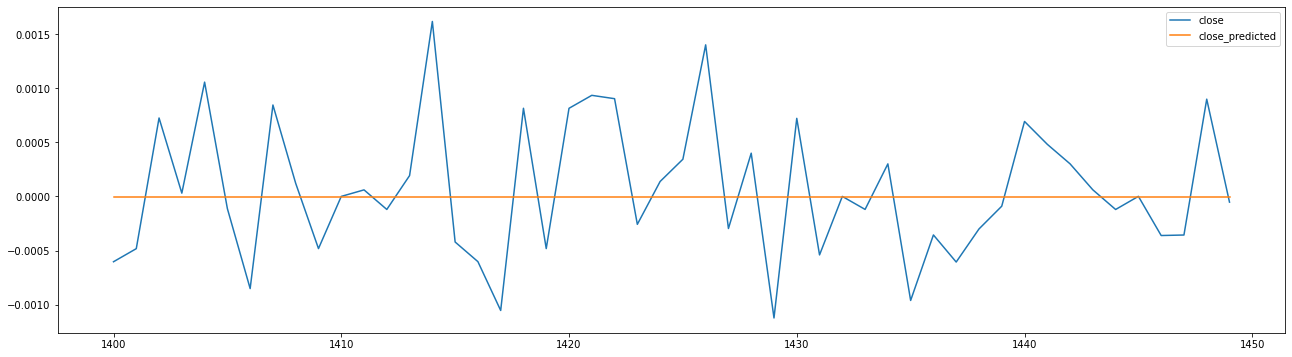

In [719]:
# Closer look
predicted[1400:1450][['close','close_predicted']].plot(figsize=(22,6))

<AxesSubplot:>

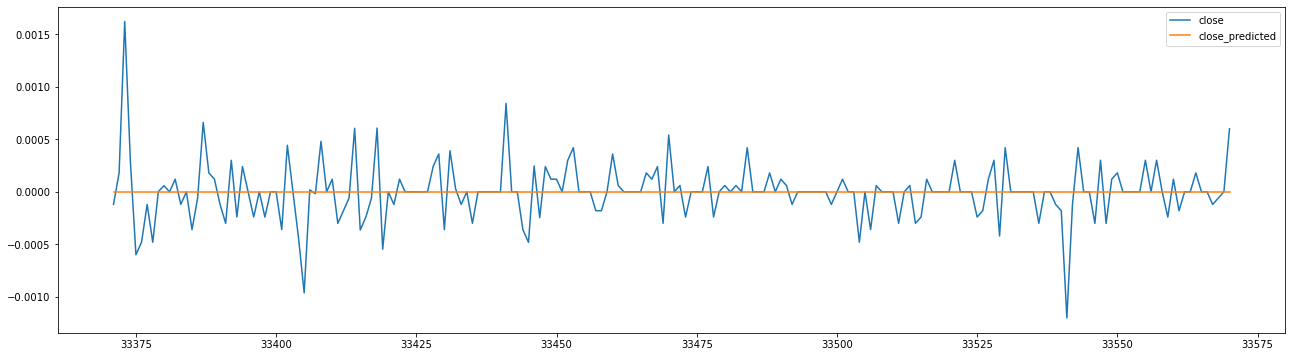

In [720]:
# Now a closer look to the testing phase: (Not that beautiful!)
predicted[-5000:-4800][['close','close_predicted']].plot(figsize=(22,6))

<AxesSubplot:>

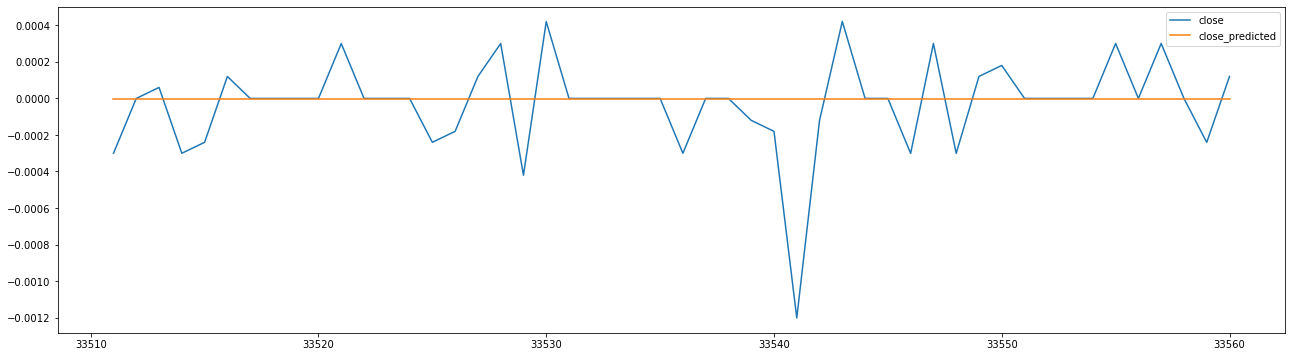

In [721]:
# Closer look
predicted[-4860:-4810][['close','close_predicted']].plot(figsize=(22,6))

In [770]:
globalpar['test_f']['training']['epochs'] = 600
globalpar['test_f']['training']['model_lstm_layers'] = 3
globalpar['test_f']['training']['model_lstm_size'] = 500
globalpar['test_f']['training']['model_dropout'] = 0.3
globalpar['test_f']['training']['lrs'] = [0.005, 0.001, 0.0005]
globalpar['test_f']['training']['epochs_change'] = 250
globalpar['test_f']['training']['lr_change'] = True
globalpar['test_f']['structure']['total_size'] = 19200
globalpar['test_f']['training']['weight_decay'] = 0.0001

In [771]:
# Let's extract our training and testing sets and start to train
train_X, train_y, test_X, test_y = final_array(apple_final, 
                                               globalpar['test_f']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y, 
                                              globalpar['test_f']['training'], 
                                              init_wgs=False)

final train X shape: (15360, 30, 4), train y shape: (15360,)
final test X shape: (3840, 30, 4), test y shape: (3840,)
torch.Size([15360, 30, 4]) torch.Size([15360]) torch.Size([3840, 30, 4]) torch.Size([3840])
Optimizer: Adam, Leaning rate: 0.005
Epoch[10/600] | loss train:2.44466478, test:1.29749373, learning rate: 0.005
Epoch[20/600] | loss train:2.44084162, test:1.30770469, learning rate: 0.005
Epoch[30/600] | loss train:2.51159594, test:1.29988171, learning rate: 0.005
Epoch[40/600] | loss train:2.49211268, test:1.29937382, learning rate: 0.005
Epoch[50/600] | loss train:2.47580179, test:1.30641378, learning rate: 0.005
Epoch[60/600] | loss train:2.45699651, test:1.29661940, learning rate: 0.005
Epoch[70/600] | loss train:2.58412790, test:1.32717435, learning rate: 0.005
Epoch[80/600] | loss train:2.52256990, test:1.30096037, learning rate: 0.005
Epoch[90/600] | loss train:2.49542132, test:1.29996085, learning rate: 0.005
Epoch[100/600] | loss train:2.48194192, test:1.30111561, lea

<AxesSubplot:title={'center':'Training Loss'}, xlabel='epochs', ylabel='Loss'>

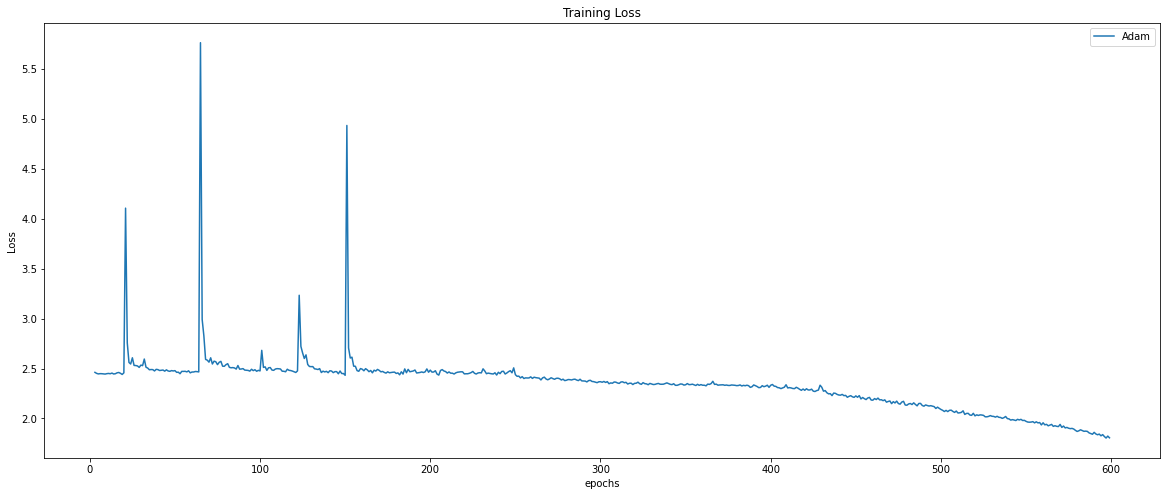

In [772]:
# The resulting training curve
graphs_Adam_train = pd.DataFrame(loss_train, columns=['Adam'])
graphs_Adam_train.loc[3:].plot(figsize=(20,8), title='Training Loss', 
                               xlabel='epochs', ylabel='Loss')

<AxesSubplot:title={'center':'Testing Loss'}, xlabel='epochs', ylabel='Loss'>

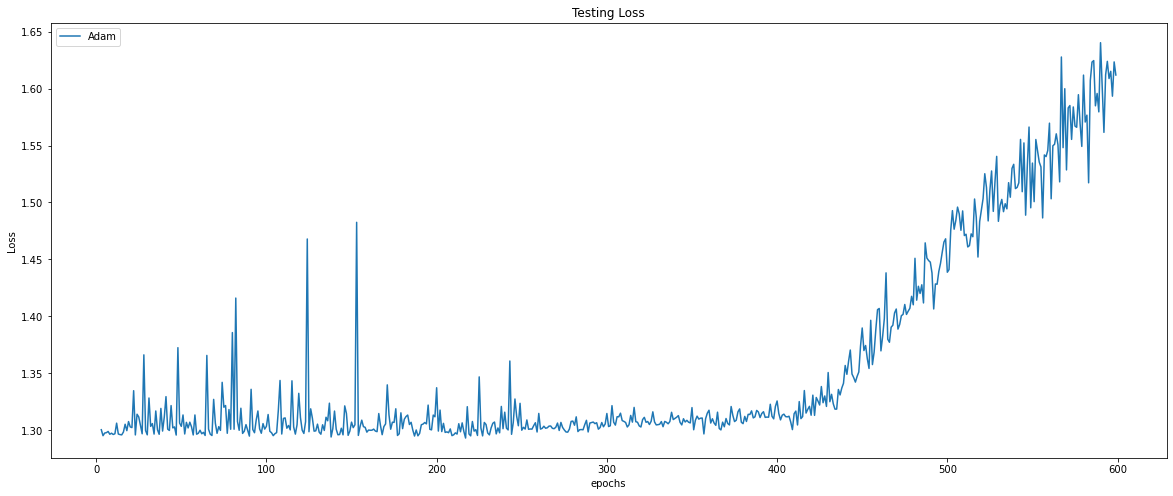

In [773]:
# And the resulting testing curve
graphs_Adam_test = pd.DataFrame(loss_test, columns=['Adam'])
graphs_Adam_test.loc[3:].plot(figsize=(20,8), title='Testing Loss', 
                              xlabel='epochs', ylabel='Loss')

In [774]:
#Let's test the function and see the result for our last training
predicted = unlog_predict(apple_final, globalpar['test_f'], model, close_scaler)
predicted

close  close_predicted
0     -2.843979e-04         0.000012
1      2.509104e-14         0.000010
2      2.509104e-14         0.000016
3      2.509104e-14         0.000021
4     -5.689577e-05         0.000018
...             ...              ...
19166 -3.202049e-04        -0.000057
19167  2.562460e-04         0.000029
19168  6.404509e-05        -0.000032
19169 -3.202049e-04        -0.000002
19170  3.209481e-04         0.000012

[19171 rows x 2 columns]

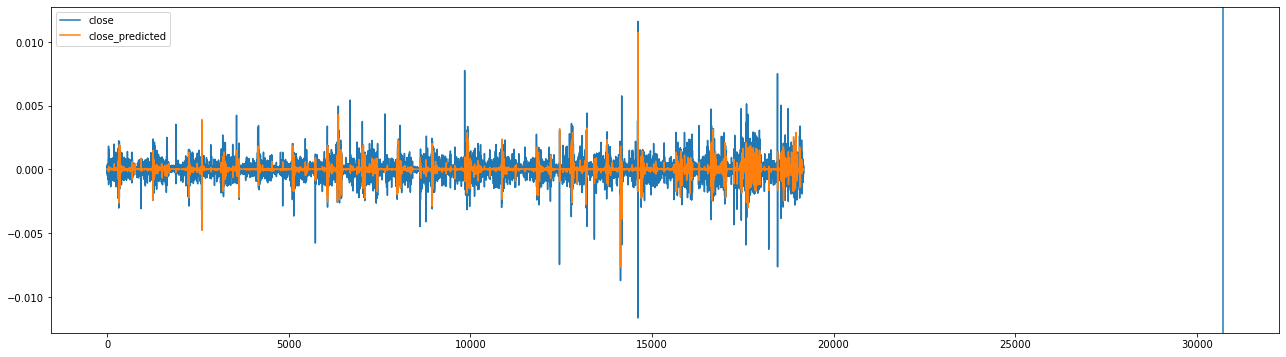

In [775]:
# Plotting the whole data prediction and close base data
predicted[['close','close_predicted']].plot(figsize=(22,6))
#Where the testing starts
plt.axvline(x=30720)

<AxesSubplot:>

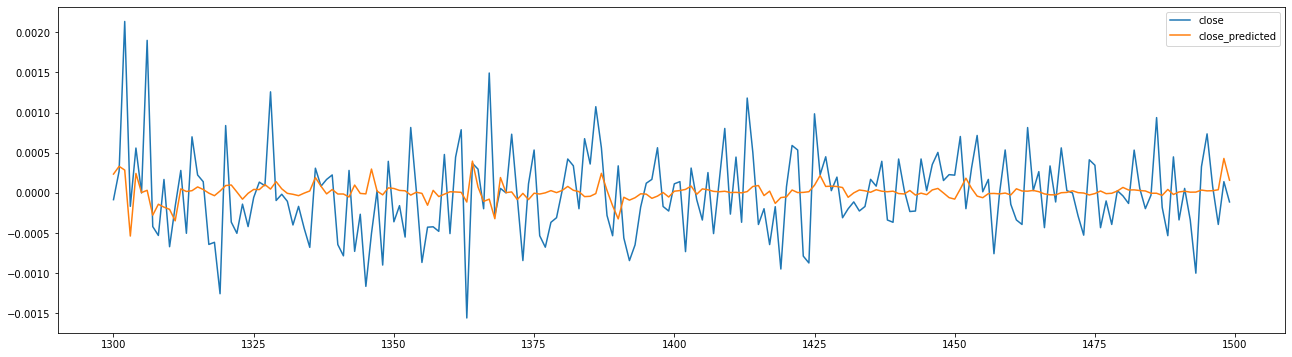

In [776]:
# A beautiful closer look to the training phase
# The lag dissapears!!
predicted[1300:1500][['close','close_predicted']].plot(figsize=(22,6))

<AxesSubplot:>

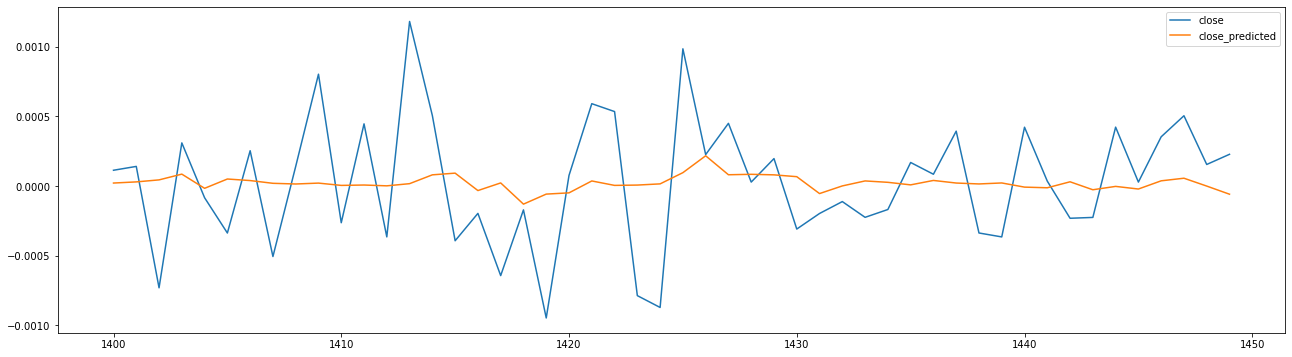

In [777]:
# Closer look
predicted[1400:1450][['close','close_predicted']].plot(figsize=(22,6))

<AxesSubplot:>

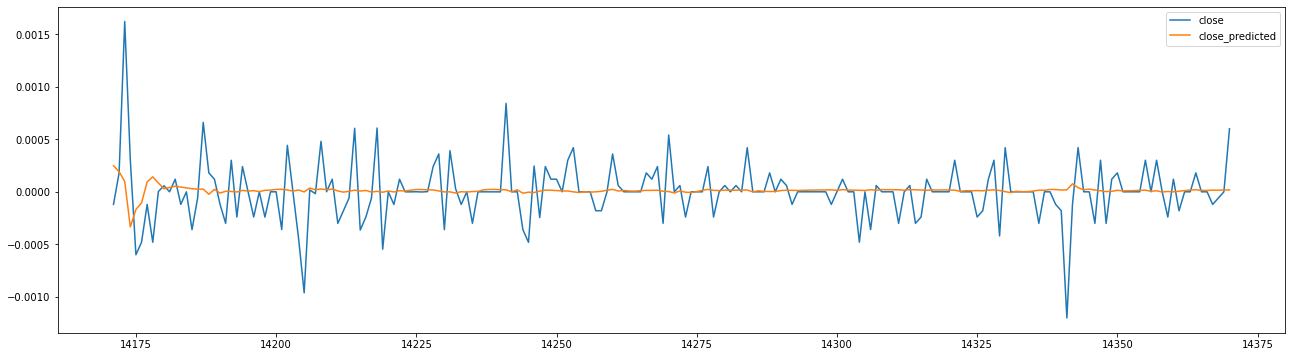

In [778]:
# Now a closer look to the testing phase: (Not that beautiful!)
predicted[-5000:-4800][['close','close_predicted']].plot(figsize=(22,6))

<AxesSubplot:>

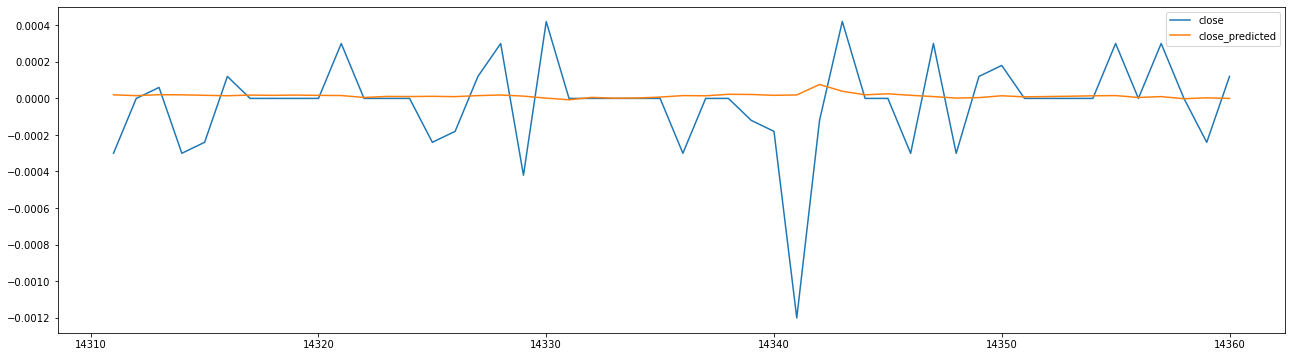

In [779]:
# Closer look
predicted[-4860:-4810][['close','close_predicted']].plot(figsize=(22,6))

In [ ]:
globalpar['test_f']['training']['epochs'] = 600
globalpar['test_f']['training']['model_lstm_layers'] = 3
globalpar['test_f']['training']['model_lstm_size'] = 256
globalpar['test_f']['training']['model_dropout'] = 0.15
globalpar['test_f']['training']['lrs'] = [0.01, 0.005, 0.001]
globalpar['test_f']['training']['epochs_change'] = 250
globalpar['test_f']['training']['lr_change'] = True
globalpar['test_f']['structure']['total_size'] = 38400
globalpar['test_f']['training']['weight_decay'] = 0.0
globalpar['test_f']['training']['optimizer'] = 'SGD'

# Let's extract our training and testing sets and start to train
train_X, train_y, test_X, test_y = final_array(apple_final, 
                                               globalpar['test_f']['structure'])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model, loss_train, loss_test = training_model(train_X, train_y, test_X, test_y, 
                                              globalpar['test_f']['training'], 
                                              init_wgs=False)

final train X shape: (30720, 30, 4), train y shape: (30720,)
final test X shape: (7680, 30, 4), test y shape: (7680,)
torch.Size([30720, 30, 4]) torch.Size([30720]) torch.Size([7680, 30, 4]) torch.Size([7680])
Optimizer: SGD, Leaning rate: 0.01
Epoch[10/600] | loss train:6.68416746, test:2.12951832, learning rate: 0.01
Epoch[20/600] | loss train:6.67649324, test:2.12934479, learning rate: 0.01
Epoch[30/600] | loss train:6.67068988, test:2.13548273, learning rate: 0.01
Epoch[40/600] | loss train:6.66582929, test:2.13009710, learning rate: 0.01
Epoch[50/600] | loss train:6.65916820, test:2.12152555, learning rate: 0.01
Epoch[60/600] | loss train:6.65165952, test:2.13428634, learning rate: 0.01
Epoch[70/600] | loss train:6.65246191, test:2.12589737, learning rate: 0.01
Epoch[80/600] | loss train:6.64236554, test:2.13508638, learning rate: 0.01
Epoch[90/600] | loss train:6.62579493, test:2.13216089, learning rate: 0.01
Epoch[100/600] | loss train:6.62168422, test:2.16047952, learning rate: